In [1]:
!pip download lifelines -q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install autograd-1.7.0-py3-none-any.whl -q
!pip install autograd-gamma-0.5.0.tar.gz -q
!pip install interface_meta-1.3.0-py3-none-any.whl -q
!pip install formulaic-1.1.1-py3-none-any.whl -q
!pip install lifelines-0.30.0-py3-none-any.whl -q
!pip install catboost -q
!pip install kaggle -q
!pip install --upgrade xgboost==2.0.3
!pip install --upgrade lightgbm==4.2.0
# !pip install --upgrade tensorflow==2.16.1 -q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
synthcity 0.2.11 requires lifelines<0.30.0,>=0.29.0, but you have lifelines 0.30.0 which is incompatible.
xgbse 0.3.3 requires lifelines<0.30.0,>=0.29.0, but you have lifelines 0.30.0 which is incompatible.
xgbse 0.3.3 requires xgboost<3.0.0,>=2.1.0, but you have xgboost 2.0.3 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!mkdir -p ~/.kaggle
!copy "C:\Users\Admin\Desktop\mert\kaggle.json"

The syntax of the command is incorrect.


        1 file(s) copied.


In [4]:
!kaggle competitions download -c equity-post-HCT-survival-predictions

equity-post-HCT-survival-predictions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!mkdir -p ./data/cibmtr
!tar -xf "C:\Projects\CIBMTR\equity-post-HCT-survival-predictions.zip" -C ".\data\cibmtr"

The syntax of the command is incorrect.


In [6]:
# @title score
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


"""
To evaluate the equitable prediction of transplant survival outcomes,
we use the concordance index (C-index) between a series of event
times and a predicted score across each race group.

It represents the global assessment of the model discrimination power:
this is the model’s ability to correctly provide a reliable ranking
of the survival times based on the individual risk scores.

The concordance index is a value between 0 and 1 where:

0.5 is the expected result from random predictions,
1.0 is perfect concordance (with no censoring, otherwise <1.0),
0.0 is perfect anti-concordance (with no censoring, otherwise >0.0)

"""

import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))


In [38]:
import pickle

In [39]:
import os

# Define the directory where you want to save your models
catboost_dir = "catboost_models"
lgbm_dir = "lgbm_models"

# Create the directory if it does not exist
os.makedirs(catboost_dir, exist_ok=True)
os.makedirs(lgbm_dir, exist_ok=True)

In [40]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv(r"data\cibmtr\test.csv")
print("Test shape:", test.shape )

train = pd.read_csv(r"data\cibmtr\train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [41]:
import polars

HLA_COLUMNS = [

    'hla_match_a_low', 'hla_match_a_high',
    'hla_match_b_low', 'hla_match_b_high',
    'hla_match_c_low', 'hla_match_c_high',

    'hla_match_dqb1_low', 'hla_match_dqb1_high',
    'hla_match_drb1_low', 'hla_match_drb1_high',
    'hla_nmdp_6',
    'hla_low_res_6', 'hla_high_res_6',
    'hla_low_res_8', 'hla_high_res_8',
    'hla_low_res_10', 'hla_high_res_10'
]

def recalculate_hla_sums(df):

    df = polars.from_pandas(df)
    
    df = df.with_columns(
        (polars.col("hla_match_a_low").fill_null(0) + polars.col("hla_match_b_low").fill_null(0) + 
         polars.col("hla_match_drb1_high").fill_null(0)).alias("hla_nmdp_6"),
        
        (polars.col("hla_match_a_low").fill_null(0) + polars.col("hla_match_b_low").fill_null(0) + 
         polars.col("hla_match_drb1_low").fill_null(0)).alias("hla_low_res_6"),
        
        (polars.col("hla_match_a_high").fill_null(0) + polars.col("hla_match_b_high").fill_null(0) + 
         polars.col("hla_match_drb1_high").fill_null(0)).alias("hla_high_res_6"),
        
        (polars.col("hla_match_a_low").fill_null(0) + polars.col("hla_match_b_low").fill_null(0) + 
         polars.col("hla_match_c_low").fill_null(0) + polars.col("hla_match_drb1_low").fill_null(0)
        ).alias("hla_low_res_8"),
        
        (polars.col("hla_match_a_high").fill_null(0) + polars.col("hla_match_b_high").fill_null(0) + 
         polars.col("hla_match_c_high").fill_null(0) + polars.col("hla_match_drb1_high").fill_null(0)
        ).alias("hla_high_res_8"),
        
        (polars.col("hla_match_a_low").fill_null(0) + polars.col("hla_match_b_low").fill_null(0) + 
         polars.col("hla_match_c_low").fill_null(0) + polars.col("hla_match_drb1_low").fill_null(0) +
         polars.col("hla_match_dqb1_low").fill_null(0)).alias("hla_low_res_10"),
        
        (polars.col("hla_match_a_high").fill_null(0) + polars.col("hla_match_b_high").fill_null(0) + 
         polars.col("hla_match_c_high").fill_null(0) + polars.col("hla_match_drb1_high").fill_null(0) +
         polars.col("hla_match_dqb1_high").fill_null(0)).alias("hla_high_res_10"),
    )

    return df.to_pandas()

train = recalculate_hla_sums(train)
test = recalculate_hla_sums(test)

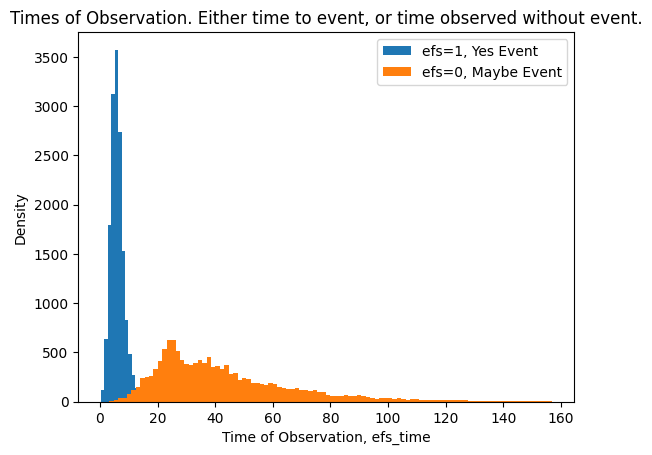

In [42]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

In [43]:
train['cyto_score'].value_counts()

cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Not tested        55
Name: count, dtype: int64

In [44]:
!pip install --upgrade scikit-learn==1.6.1 -q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
from sklearn.preprocessing import OneHotEncoder, quantile_transform, power_transform, FunctionTransformer, PolynomialFeatures, StandardScaler
from lifelines import CoxPHFitter
import warnings

def transform_partial_hazard(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times

    From https://www.kaggle.com/code/andreasbis/cibmtr-eda-ensemble-model
    """
    data = pd.DataFrame({'efs_time': time, 'efs': event, 'time': time, 'event': event})
    cph = CoxPHFitter()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cph.fit(data, duration_col='time', event_col='event')
    return cph.predict_partial_hazard(data)

def transform_separate(time, event):
    """Transform the target by separating events from non-events

    From https://www.kaggle.com/code/mtinti/cibmtr-lofo-feature-importance-gpu-accelerated"""
    transformed = time.values.copy()
    mx = transformed[event == 1].max() # last patient who dies
    mn = transformed[event == 0].min() # first patient who survives
    transformed[event == 0] = time[event == 0] + mx - mn
    transformed = rankdata(transformed)
    transformed[event == 0] += len(transformed) // 2
    transformed = transformed / transformed.max()
    return - transformed

def transform_rank_log(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times

    From https://www.kaggle.com/code/cdeotte/nn-mlp-baseline-cv-670-lb-676"""
    transformed = time.values.copy()
    mx = transformed[event == 1].max() # last patient who dies
    mn = transformed[event == 0].min() # first patient who survives
    transformed[event == 0] = time[event == 0] + mx - mn
    transformed = rankdata(transformed)
    transformed[event == 0] += len(transformed) * 2
    transformed = transformed / transformed.max()
    transformed = np.log(transformed)
    return - transformed

def transform_quantile(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times

    From https://www.kaggle.com/code/ambrosm/esp-eda-which-makes-sense"""
    transformed = np.full(len(time), np.nan)
    transformed_dead = quantile_transform(- time[event == 1].values.reshape(-1, 1)).ravel()
    transformed[event == 1] = transformed_dead
    transformed[event == 0] = transformed_dead.min() - 0.3
    return transformed

In [46]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [47]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")

print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

num_cols = [c for c in FEATURES if not c in CATS]
print(f"In these features, there are {len(num_cols)} NUMERICAL FEATURES: {num_cols}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']
In these features, there are 22 NUMERICAL FEATURES: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8

In [48]:
train['karnofsky_score'].value_counts()

karnofsky_score
90.0     15336
70.0      6690
100.0     2476
80.0      2036
60.0      1291
50.0        91
40.0        10
Name: count, dtype: int64

In [49]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")

    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

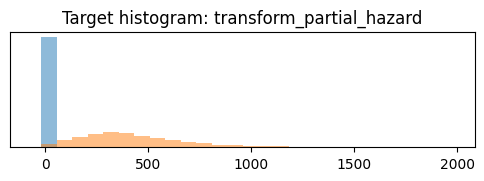

transform_partial_hazard


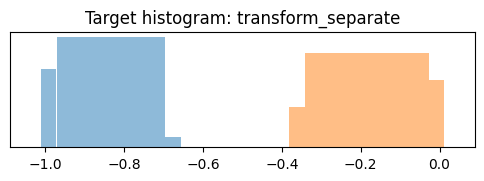

transform_separate


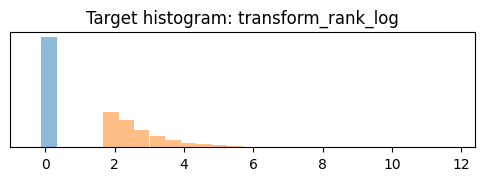

transform_rank_log


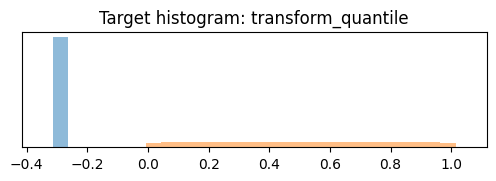

transform_quantile


In [50]:
# XGBoost: MSE loss with five different quantile transformation
for transformation in [
                      transform_partial_hazard,
                       transform_separate,
                       transform_rank_log,
                       transform_quantile
                      ]:
    plt.figure(figsize=(6, 1.5))
    target = transformation(time=train.efs_time, event=train.efs)
    vmin, vmax = 1.09 * target.min() - 0.09 * target.max(), 1.09 * target.max() - 0.09 * target.min()
    plt.hist(target[train.efs == 0], bins=np.linspace(vmin, vmax, 31), density=True, label='efs=0: patient still lives at this time', alpha=0.5)
    plt.hist(target[train.efs == 1], bins=np.linspace(vmin, vmax, 31), density=True, label='efs=1: patient dies at this time', alpha=0.5)
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.title('Target histogram: ' + transformation.__name__)
    plt.show()

    print(transformation.__name__)

In [20]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
print("Using LightGBM version",lgb.__version__) # 4.2.0 olacak
from sklearn.model_selection import StratifiedKFold


Using LightGBM version 4.2.0


In [21]:
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("Using XGBoost version",xgb.__version__) # 2.0.3 olacak

Using XGBoost version 2.0.3


In [74]:
import pandas as pd

def transform_time_qcut(time, event, q=4):
    """
    Discretize event times into q quantile bins using ordinal encoding.
    Censored observations receive the highest ordinal value.
    """
    time_arr = np.array(time)
    event_arr = np.array(event)
    transformed = np.zeros_like(time_arr, dtype=float)
    
    # Only use events to compute quantile bins.
    events_time = time_arr[event_arr == 1]
    if len(events_time) > 0:
        # Use pandas qcut for quantile binning.
        bins = pd.qcut(events_time, q=q, duplicates="drop", labels=False)
        # Assign the ordinal value back to the original indices
        transformed[event_arr == 1] = bins
    # For censored observations, assign the highest ordinal value.
    transformed[event_arr == 0] = q  
    return -transformed

def transform_time_weighted_risk(time, event):
    """
    Incorporates both time-based weighting and event status
    """
    # Convert to numpy arrays if they're pandas Series
    time_arr = time.values if hasattr(time, 'values') else np.array(time)
    event_arr = event.values if hasattr(event, 'values') else np.array(event)

    transformed = np.zeros_like(time_arr, dtype=float)

    # For events: exponential decay with time
    event_mask = (event_arr == 1)
    if event_mask.any():
        mean_time = time_arr[event_mask].mean()
        transformed[event_mask] = np.exp(-time_arr[event_mask] / mean_time)

    # For censored: linear scaling with upper bound
    censored_mask = (event_arr == 0)
    transformed[censored_mask] = 0.1 * (time_arr[censored_mask] / time_arr.max())

    return transformed


from lifelines import KaplanMeierFitter, NelsonAalenFitter
import numpy as np

def transform_neg_log_survival(time, event):
    kmf = KaplanMeierFitter()
    kmf.fit(time, event)
    # Compute survival probabilities at the observed times
    surv_probs = kmf.survival_function_at_times(time).values
    # Transform to negative log survival
    transformed = -np.log(surv_probs + 1e-8)  # add a tiny epsilon to avoid log(0)
    return -transformed

def transform_time_buckets(time, event):
    """Transform using time-based buckets with different weights"""
    time_arr = time.values if hasattr(time, 'values') else np.array(time)
    event_arr = event.values if hasattr(event, 'values') else np.array(event)
    
    # Create buckets based on quantiles of event times
    event_times = time_arr[event_arr == 1]
    quantiles = np.percentile(event_times, [25, 50, 75])
    
    transformed = np.zeros_like(time_arr, dtype=float)
    
    # For events: assign weights based on time buckets
    event_mask = (event_arr == 1)
    transformed[event_mask & (time_arr < quantiles[0])] = 1.0
    transformed[event_mask & (time_arr >= quantiles[0]) & (time_arr < quantiles[1])] = 0.75
    transformed[event_mask & (time_arr >= quantiles[1]) & (time_arr < quantiles[2])] = 0.5
    transformed[event_mask & (time_arr >= quantiles[2])] = 0.25
    
    # For censored: weight based on observation time
    censored_mask = (event_arr == 0)
    transformed[censored_mask] = 0.1 * (time_arr[censored_mask] / time_arr.max())
    
    return transformed


import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines import NelsonAalenFitter

def transform_martingale_residuals(time, event):
    """
    Compute martingale residuals for a no-predictor Cox model as:
        martingale_residual = event - baseline_cumulative_hazard(time)
    using the Nelson-Aalen estimator for the cumulative hazard.
    
    Parameters:
        time (array-like): Observed times.
        event (array-like): Event indicators (1 for event, 0 for censored).
    
    Returns:
        numpy.ndarray: Martingale residuals for each observation.
    """
    time = np.array(time)
    event = np.array(event)
    
    naf = NelsonAalenFitter()
    naf.fit(time, event)
    
    # Evaluate the cumulative hazard at each observed time.
    # The result is a pandas Series; we convert it to a 1D numpy array.
    H_t = naf.cumulative_hazard_at_times(time).values.flatten()
    
    # Martingale residuals: observed event indicator minus estimated cumulative hazard.
    martingale_res = event - H_t
    return martingale_res

### XGBOOST TRANSFORM TIME QCUT

In [22]:
%%time
from sklearn.model_selection import StratifiedKFold
FOLDS = 10
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

oof_xgb_qcut = np.zeros(len(train))
pred_xgb_qcut = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_qcut(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_qcut(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_qcut[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_qcut += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_qcut /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:1.48956
[500]	validation_0-rmse:1.34356
[1000]	validation_0-rmse:1.33366
[1500]	validation_0-rmse:1.33055
[1999]	validation_0-rmse:1.33016


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 2
#########################
[0]	validation_0-rmse:1.48967
[500]	validation_0-rmse:1.34636
[1000]	validation_0-rmse:1.33696
[1500]	validation_0-rmse:1.33502
[1999]	validation_0-rmse:1.33582
#########################
### Fold 3
#########################
[0]	validation_0-rmse:1.48997
[500]	validation_0-rmse:1.33120
[1000]	validation_0-rmse:1.32223
[1500]	validation_0-rmse:1.31745
[1999]	validation_0-rmse:1.31757
#########################
### Fold 4
#########################
[0]	validation_0-rmse:1.49058
[500]	validation_0-rmse:1.33466
[1000]	validation_0-rmse:1.32426
[1500]	validation_0-rmse:1.32068
[1999]	validation_0-rmse:1.31952
#########################
### Fold 5
#########################
[0]	validation_0-rmse:1.48988
[500]	validation_0-rmse:1.35010
[1000]	validation_0-rmse:1.34527
[1500]	validation_0-rmse:1.34456
[1999]	validation_0-rmse:1.34523
#########################
### Fold 6
#########################
[0]	validation_0-rmse:1.48923
[500]	valid

In [23]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_qcut
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost oof_xgb_qcut =",m)


# Option 1: Pickle
import pickle
with open(r'gbdt-models\oof_xgb_qcut.pkl', 'wb') as f:
    pickle.dump(oof_xgb_qcut, f)
# Pickle
with open(r'gbdt-models\oof_xgb_qcut.pkl', 'rb') as f:
    oof_xgb_qcut = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12716\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost oof_xgb_qcut = 0.6789657523234865


### CATBOOST TIME QCUT

In [28]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [35]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_qcut = np.zeros(len(train))
pred_cat_qcut = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_qcut(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_qcut(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        iterations=2000,
        depth=4,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_qcut[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_qcut += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_qcut /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 1.4786160	test: 1.4786314	best: 1.4786314 (0)	total: 9.79ms	remaining: 19.6s
250:	learn: 1.2952836	test: 1.3387678	best: 1.3387678 (250)	total: 3.62s	remaining: 25.2s
500:	learn: 1.2694335	test: 1.3312925	best: 1.3312656 (498)	total: 6.42s	remaining: 19.2s
750:	learn: 1.2499980	test: 1.3296221	best: 1.3291643 (683)	total: 9.16s	remaining: 15.2s
1000:	learn: 1.2335253	test: 1.3291210	best: 1.3286012 (941)	total: 11.8s	remaining: 11.8s
1250:	learn: 1.2180516	test: 1.3301803	best: 1.3286012 (941)	total: 14.4s	remaining: 8.64s
1500:	learn: 1.2038872	test: 1.3292664	best: 1.3286012 (941)	total: 17s	remaining: 5.66s
1750:	learn: 1.1894805	test: 1.3307755	best: 1.3286012 (941)	total: 19.5s	remaining: 2.77s
1999:	learn: 1.1770335	test: 1.3326823	best: 1.3286012 (941)	total: 21.8s	remaining: 0us
bestTest = 1.328601196
bestIteration = 941
Shrink model to first 942 iterations.
#########################
### Fold 2
###########

In [36]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_qcut
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for oof_cat_qcut =",m)


# Option 1: Pickle
import pickle
with open(r'gbdt-models\oof_cat_qcut.pkl', 'wb') as f:
    pickle.dump(oof_cat_qcut, f)
# Pickle
with open(r'gbdt-models\oof_cat_qcut.pkl', 'rb') as f:
    oof_cat_qcut = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12716\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for oof_cat_qcut = 0.678418014641855


In [33]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_qcut_2 = np.zeros(len(train))
pred_cat_qcut_2 = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_qcut(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_qcut(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        iterations=2000,
        depth=4,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_qcut_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_qcut_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_qcut_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 1.4793781	test: 1.4791144	best: 1.4791144 (0)	total: 8.16ms	remaining: 16.3s
250:	learn: 1.3089624	test: 1.3420485	best: 1.3420485 (250)	total: 1.72s	remaining: 12s
500:	learn: 1.2950104	test: 1.3366089	best: 1.3363816 (494)	total: 3.5s	remaining: 10.5s
750:	learn: 1.2852714	test: 1.3349401	best: 1.3346741 (671)	total: 5.17s	remaining: 8.6s
1000:	learn: 1.2769970	test: 1.3324627	best: 1.3324539 (975)	total: 7.11s	remaining: 7.1s
1250:	learn: 1.2687707	test: 1.3312372	best: 1.3311764 (1240)	total: 9.1s	remaining: 5.45s
1500:	learn: 1.2617562	test: 1.3307816	best: 1.3306504 (1496)	total: 10.8s	remaining: 3.58s
1750:	learn: 1.2543715	test: 1.3297262	best: 1.3296931 (1746)	total: 12.4s	remaining: 1.77s
1999:	learn: 1.2477094	test: 1.3290231	best: 1.3289712 (1989)	total: 14.1s	remaining: 0us
bestTest = 1.328971212
bestIteration = 1989
Shrink model to first 1990 iterations.
#########################
### Fold 2
#########

In [34]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_qcut_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for oof_cat_qcut =",m)


# Option 1: Pickle
import pickle
with open(r'gbdt-models\oof_cat_qcut_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_qcut_2, f)
# Pickle
with open(r'gbdt-models\oof_cat_qcut_2.pkl', 'rb') as f:
    oof_cat_qcut_2 = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12716\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for oof_cat_qcut = 0.6781822157858389


# XGBOOST WITH TIME WEIGHTED RISK

In [35]:
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("Using XGBoost version",xgb.__version__) # 2.0.3 olacak

Using XGBoost version 2.0.3


In [45]:
%%time
FOLDS = 10
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

oof_xgb_martingale = np.zeros(len(train))
pred_xgb_martingale = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_martingale_residuals(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_martingale_residuals(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_martingale[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_martingale += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_martingale /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.73275
[500]	validation_0-rmse:0.66273
[1000]	validation_0-rmse:0.66007
[1500]	validation_0-rmse:0.66003
[1999]	validation_0-rmse:0.66057
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.73281
[500]	validation_0-rmse:0.65924
[1000]	validation_0-rmse:0.65630
[1500]	validation_0-rmse:0.65582
[1999]	validation_0-rmse:0.65625
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.73281
[500]	validation_0-rmse:0.65165
[1000]	validation_0-rmse:0.64843
[1500]	validation_0-rmse:0.64789
[1999]	validation_0-rmse:0.64813
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.73272
[500]	validation_0-rmse:0.65912
[1000]	validation_0-rmse:0.65671
[1500]	validation_0-rmse:0.65640
[1999]	validation_0-rmse:0.65686
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.73267
[500]	valid

In [46]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_martingale
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost martingale residuals RMSE =",m)

# Option 1: Pickle
import pickle
with open(r'gbdt-models\oof_xgb_martingale.pkl', 'wb') as f:
    pickle.dump(oof_xgb_martingale, f)
# Pickle
with open(r'gbdt-models\oof_xgb_martingale.pkl', 'rb') as f:
    oof_xgb_martingale = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15160\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost martingale residuals RMSE = 0.6666773334741297


In [22]:
%%time
FOLDS = 10
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

oof_xgb_twr_rmse = np.zeros(len(train))
pred_xgb_twr_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_weighted_risk(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_weighted_risk(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_twr_rmse[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_twr_rmse += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_twr_rmse /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.21265
[500]	validation_0-rmse:0.19195
[1000]	validation_0-rmse:0.19074


KeyboardInterrupt: 

In [24]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_twr_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Quantile Transformation RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Quantile Transformation RMSE = 0.6782156305161005


In [32]:
# Option 1: Pickle
import pickle
with open(r'gbdt-models\oof_xgb_twr_rmse.pkl', 'wb') as f:
    pickle.dump(oof_xgb_twr_rmse, f)
# Pickle
with open(r'gbdt-models\oof_xgb_twr_rmse.pkl', 'rb') as f:
    oof_xgb_twr_rmse = pickle.load(f)

In [25]:
%%time
FOLDS = 10
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

oof_xgb_nls_rmse = np.zeros(len(train))
pred_xgb_nls_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_neg_log_survival(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_neg_log_survival(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_nls_rmse[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_nls_rmse += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_nls_rmse /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.27188
[500]	validation_0-rmse:0.24457
[1000]	validation_0-rmse:0.24233
[1500]	validation_0-rmse:0.24156
[1999]	validation_0-rmse:0.24128
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.27189
[500]	validation_0-rmse:0.24511
[1000]	validation_0-rmse:0.24336
[1500]	validation_0-rmse:0.24286
[1999]	validation_0-rmse:0.24286
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.27180
[500]	validation_0-rmse:0.24228
[1000]	validation_0-rmse:0.24004
[1500]	validation_0-rmse:0.23914
[1999]	validation_0-rmse:0.23889
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.27110
[500]	validation_0-rmse:0.24154
[1000]	validation_0-rmse:0.23909
[1500]	validation_0-rmse:0.23804
[1999]	validation_0-rmse:0.23778
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.27134
[500]	valid

In [26]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_nls_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Quantile Transformation RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Quantile Transformation RMSE = 0.6772112399758733


In [31]:
# Option 1: Pickle
import pickle
with open(r'gbdt-models\oof_xgb_nls_rmse.pkl', 'wb') as f:
    pickle.dump(oof_xgb_nls_rmse, f)
# Pickle
with open(r'gbdt-models\oof_xgb_nls_rmse.pkl', 'rb') as f:
    oof_xgb_nls_rmse = pickle.load(f)

In [27]:
%%time
FOLDS = 10
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

oof_xgb_tb_rmse = np.zeros(len(train))
pred_xgb_tb_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_buckets(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_buckets(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_tb_rmse[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_tb_rmse += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_tb_rmse /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.36051
[500]	validation_0-rmse:0.32498
[1000]	validation_0-rmse:0.32251
[1500]	validation_0-rmse:0.32167
[1999]	validation_0-rmse:0.32162
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.36096
[500]	validation_0-rmse:0.32627
[1000]	validation_0-rmse:0.32420
[1500]	validation_0-rmse:0.32372
[1999]	validation_0-rmse:0.32380
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.36083
[500]	validation_0-rmse:0.32252
[1000]	validation_0-rmse:0.32014
[1500]	validation_0-rmse:0.31911
[1999]	validation_0-rmse:0.31911
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.36032
[500]	validation_0-rmse:0.32260
[1000]	validation_0-rmse:0.31980
[1500]	validation_0-rmse:0.31885
[1999]	validation_0-rmse:0.31855
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.36097
[500]	valid

In [28]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_tb_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Quantile Transformation RMSE =",m)


Overall CV for XGBoost Quantile Transformation RMSE = 0.6792817387222471


C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)


In [30]:
# Option 1: Pickle
import pickle
with open(r'gbdt-models\oof_xgb_tb_rmse.pkl', 'wb') as f:
    pickle.dump(oof_xgb_tb_rmse, f)
# Pickle
with open(r'gbdt-models\oof_xgb_tb_rmse.pkl', 'rb') as f:
    oof_xgb_tb_rmse = pickle.load(f)

# XGBOOST WITH QUANTILE TRANSFORM

In [42]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_quantile_rmse = np.zeros(len(train))
pred_xgb_quantile_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_quantile_rmse[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_quantile_rmse += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_quantile_rmse /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.45034
[500]	validation_0-rmse:0.40438
[1000]	validation_0-rmse:0.40176
[1500]	validation_0-rmse:0.40176
[1999]	validation_0-rmse:0.40225
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.45056
[500]	validation_0-rmse:0.40296
[1000]	validation_0-rmse:0.40102
[1500]	validation_0-rmse:0.40022
[1999]	validation_0-rmse:0.40073
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.45092
[500]	validation_0-rmse:0.40147
[1000]	validation_0-rmse:0.39952
[1500]	validation_0-rmse:0.39943
[1999]	validation_0-rmse:0.39970
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.45135
[500]	validation_0-rmse:0.40164
[1000]	validation_0-rmse:0.39943
[1500]	validation_0-rmse:0.39921
[1999]	validation_0-rmse:0.39942
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.45022
[500]	valid

In [43]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_quantile_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Quantile Transformation RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18124\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Quantile Transformation RMSE = 0.6771094786271409


In [24]:
# Option 1: Pickle
import pickle
with open(r'gbdt-models\oof_xgb_quantile_rmse.pkl', 'wb') as f:
    pickle.dump(oof_xgb_quantile_rmse, f)
# Pickle
with open(r'gbdt-models\oof_xgb_quantile_rmse.pkl', 'rb') as f:
    oof_xgb_quantile_rmse = pickle.load(f)

In [44]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

oof_xgb_quantile_rmse_skf = np.zeros(len(train))
pred_xgb_quantile_rmse_skf = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_quantile_rmse_skf[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_quantile_rmse_skf += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_quantile_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.45073
[500]	validation_0-rmse:0.40618
[1000]	validation_0-rmse:0.40357
[1500]	validation_0-rmse:0.40266
[1999]	validation_0-rmse:0.40259
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.45062
[500]	validation_0-rmse:0.40675
[1000]	validation_0-rmse:0.40489
[1500]	validation_0-rmse:0.40450
[1999]	validation_0-rmse:0.40463
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.45072
[500]	validation_0-rmse:0.40232
[1000]	validation_0-rmse:0.39931
[1500]	validation_0-rmse:0.39837
[1999]	validation_0-rmse:0.39866
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.45068
[500]	validation_0-rmse:0.40339
[1000]	validation_0-rmse:0.40039
[1500]	validation_0-rmse:0.39971
[1999]	validation_0-rmse:0.39965
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.45061
[500]	valid

In [45]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_quantile_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Quantile Transformation RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18124\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Quantile Transformation RMSE = 0.6774133467949522


In [27]:
with open(r'gbdt-models\oof_xgb_quantile_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_xgb_quantile_rmse_skf, f)
with open(r'gbdt-models\oof_xgb_quantile_rmse_skf.pkl', 'rb') as f:
    oof_xgb_quantile_rmse_skf = pickle.load(f)

In [28]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

oof_xgb_quantile_rmse_skf_dri = np.zeros(len(train))
pred_xgb_quantile_rmse_skf_dri = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_quantile_rmse_skf_dri[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_quantile_rmse_skf_dri += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_quantile_rmse_skf_dri /= FOLDS

#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[0]	validation_0-rmse:0.45102
[500]	validation_0-rmse:0.40793
[1000]	validation_0-rmse:0.40592
[1500]	validation_0-rmse:0.40533
[1999]	validation_0-rmse:0.40529
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.45062
[500]	validation_0-rmse:0.40412
[1000]	validation_0-rmse:0.40107
[1500]	validation_0-rmse:0.40051
[1999]	validation_0-rmse:0.40072
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.45065
[500]	validation_0-rmse:0.40085
[1000]	validation_0-rmse:0.39772
[1500]	validation_0-rmse:0.39693
[1999]	validation_0-rmse:0.39651
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.45064
[500]	validation_0-rmse:0.40589
[1000]	validation_0-rmse:0.40323
[1500]	validation_0-rmse:0.40226
[1999]	validation_0-rmse:0.40166
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.45044
[500]	validation_0-rmse:0.41046
[1000]	validation_0-rmse:0.40882
[1500]	va

In [29]:
# 0.6796 with max_cat_to_onehot=15

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_quantile_rmse_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Quantile Transformation RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Quantile Transformation RMSE = 0.6785241432663061


In [30]:
with open(r'gbdt-models\oof_xgb_quantile_rmse_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_xgb_quantile_rmse_skf_dri, f)
with open(r'gbdt-models\oof_xgb_quantile_rmse_skf_dri.pkl', 'rb') as f:
    oof_xgb_quantile_rmse_skf_dri = pickle.load(f)



In [31]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_quantile_mae = np.zeros(len(train))
pred_xgb_quantile_mae = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        objective="reg:absoluteerror",
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_quantile_mae[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_quantile_mae += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_quantile_mae /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-mae:0.40289
[500]	validation_0-mae:0.32449
[1000]	validation_0-mae:0.32063
[1500]	validation_0-mae:0.31875
[1999]	validation_0-mae:0.31815
#########################
### Fold 2
#########################
[0]	validation_0-mae:0.40326
[500]	validation_0-mae:0.32044
[1000]	validation_0-mae:0.31755
[1500]	validation_0-mae:0.31621
[1999]	validation_0-mae:0.31577
#########################
### Fold 3
#########################
[0]	validation_0-mae:0.40380
[500]	validation_0-mae:0.32082
[1000]	validation_0-mae:0.31741
[1500]	validation_0-mae:0.31599
[1999]	validation_0-mae:0.31541
#########################
### Fold 4
#########################
[0]	validation_0-mae:0.40454
[500]	validation_0-mae:0.32438
[1000]	validation_0-mae:0.32103
[1500]	validation_0-mae:0.31998
[1999]	validation_0-mae:0.31940
#########################
### Fold 5
#########################
[0]	validation_0-mae:0.40253
[500]	validation_0-mae:0.31966
[

In [32]:
# 0.6712

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_quantile_mae
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Quantile Transformation MAE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Quantile Transformation MAE = 0.6709307629690304


In [33]:
with open(r'gbdt-models\oof_xgb_quantile_mae.pkl', 'wb') as f:
    pickle.dump(oof_xgb_quantile_mae, f)
with open(r'gbdt-models\oof_xgb_quantile_mae.pkl', 'rb') as f:
    oof_xgb_quantile_mae = pickle.load(f)



# CATBOOST WITH TIME WEIGHTED RISK

In [23]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [ ]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_twr_rmse_skf = np.zeros(len(train))
pred_cat_twr_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_weighted_risk(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_weighted_risk(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        iterations=2000,
        depth=3,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_twr_rmse_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_twr_rmse_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_twr_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.2110450	test: 0.2111892	best: 0.2111892 (0)	total: 87ms	remaining: 2m 53s
250:	learn: 0.1875125	test: 0.1918196	best: 0.1918196 (250)	total: 1.56s	remaining: 10.8s
500:	learn: 0.1846824	test: 0.1907990	best: 0.1907811 (494)	total: 3.15s	remaining: 9.44s
750:	learn: 0.1828481	test: 0.1905635	best: 0.1905435 (727)	total: 4.61s	remaining: 7.67s
1000:	learn: 0.1814956	test: 0.1904289	best: 0.1904215 (983)	total: 6.14s	remaining: 6.13s
1250:	learn: 0.1802913	test: 0.1903515	best: 0.1902454 (1120)	total: 8.04s	remaining: 4.81s
1500:	learn: 0.1791718	test: 0.1901151	best: 0.1901084 (1497)	total: 10.1s	remaining: 3.35s
1750:	learn: 0.1781762	test: 0.1900199	best: 0.1900199 (1750)	total: 12s	remaining: 1.7s
1999:	learn: 0.1771890	test: 0.1900071	best: 0.1900070 (1998)	total: 13.5s	remaining: 0us
bestTest = 0.1900070291
bestIteration = 1998
Shrink model to first 1999 iterations.
#########################
### Fold 2
######

In [38]:
# 0.6773- 0.6775

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_twr_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)

with open(r'gbdt-models\oof_cat_twr_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_twr_rmse_skf, f)
with open(r'gbdt-models\oof_cat_twr_rmse_skf.pkl', 'rb') as f:
    oof_cat_twr_rmse_skf = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.6768714529498231


In [39]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_twr_rmse_skf_2 = np.zeros(len(train))
pred_cat_twr_rmse_skf_2 = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_weighted_risk(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_weighted_risk(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        iterations=2000,
        depth=3,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_twr_rmse_skf_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_twr_rmse_skf_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_twr_rmse_skf_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.2110407	test: 0.2112148	best: 0.2112148 (0)	total: 18.3ms	remaining: 36.6s
250:	learn: 0.1884951	test: 0.1922432	best: 0.1922432 (250)	total: 1.57s	remaining: 10.9s
500:	learn: 0.1867120	test: 0.1914147	best: 0.1914043 (494)	total: 3.06s	remaining: 9.14s
750:	learn: 0.1857085	test: 0.1911044	best: 0.1911019 (743)	total: 4.47s	remaining: 7.44s
1000:	learn: 0.1849163	test: 0.1909552	best: 0.1909374 (988)	total: 6.12s	remaining: 6.11s
1250:	learn: 0.1841393	test: 0.1907897	best: 0.1907896 (1249)	total: 8s	remaining: 4.79s
1500:	learn: 0.1834904	test: 0.1905983	best: 0.1905977 (1493)	total: 9.77s	remaining: 3.25s
1750:	learn: 0.1828930	test: 0.1904486	best: 0.1904383 (1746)	total: 11.2s	remaining: 1.59s
1999:	learn: 0.1823296	test: 0.1903998	best: 0.1903877 (1941)	total: 12.8s	remaining: 0us
bestTest = 0.190387699
bestIteration = 1941
Shrink model to first 1942 iterations.
#########################
### Fold 2
######

In [40]:
# 0.6773- 0.6775

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_twr_rmse_skf_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)

with open(r'gbdt-models\oof_cat_twr_rmse_skf_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_twr_rmse_skf_2, f)
with open(r'gbdt-models\oof_cat_twr_rmse_skf_2.pkl', 'rb') as f:
    oof_cat_twr_rmse_skf_2 = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.6760072793559708


In [41]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_nl_rmse_skf = np.zeros(len(train))
pred_cat_nl_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_neg_log_survival(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_neg_log_survival(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        iterations=2000,
        depth=3,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_nl_rmse_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_nl_rmse_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_nl_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.2696158	test: 0.2701109	best: 0.2701109 (0)	total: 6.81ms	remaining: 13.6s
250:	learn: 0.2393312	test: 0.2443175	best: 0.2443175 (250)	total: 1.4s	remaining: 9.74s
500:	learn: 0.2357183	test: 0.2425516	best: 0.2425376 (494)	total: 2.64s	remaining: 7.9s
750:	learn: 0.2333270	test: 0.2418608	best: 0.2418535 (739)	total: 4.04s	remaining: 6.73s
1000:	learn: 0.2312758	test: 0.2414641	best: 0.2414259 (979)	total: 5.3s	remaining: 5.29s
1250:	learn: 0.2295571	test: 0.2411987	best: 0.2411987 (1250)	total: 6.68s	remaining: 4s
1500:	learn: 0.2280634	test: 0.2409886	best: 0.2409643 (1488)	total: 7.95s	remaining: 2.64s
1750:	learn: 0.2266313	test: 0.2409494	best: 0.2409418 (1748)	total: 9.32s	remaining: 1.32s
1999:	learn: 0.2251686	test: 0.2408825	best: 0.2408591 (1958)	total: 10.5s	remaining: 0us
bestTest = 0.2408591316
bestIteration = 1958
Shrink model to first 1959 iterations.
#########################
### Fold 2
########

In [42]:
# 0.6773- 0.6775

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_nl_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)

with open(r'gbdt-models\oof_cat_nl_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_nl_rmse_skf, f)
with open(r'gbdt-models\oof_cat_nl_rmse_skf.pkl', 'rb') as f:
    oof_cat_nl_rmse_skf = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.6766804380151484


In [43]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_nl_rmse_skf_2 = np.zeros(len(train))
pred_cat_nl_rmse_skf_2 = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_neg_log_survival(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_neg_log_survival(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        iterations=2000,
        depth=3,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_nl_rmse_skf_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_nl_rmse_skf_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_nl_rmse_skf_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.2696284	test: 0.2700675	best: 0.2700675 (0)	total: 6.43ms	remaining: 12.9s
250:	learn: 0.2408714	test: 0.2451819	best: 0.2451567 (248)	total: 1.17s	remaining: 8.13s
500:	learn: 0.2384489	test: 0.2439424	best: 0.2439374 (494)	total: 2.39s	remaining: 7.16s
750:	learn: 0.2370787	test: 0.2433620	best: 0.2433583 (747)	total: 3.68s	remaining: 6.13s
1000:	learn: 0.2360501	test: 0.2429454	best: 0.2429372 (983)	total: 4.95s	remaining: 4.94s
1250:	learn: 0.2349934	test: 0.2425866	best: 0.2425759 (1206)	total: 6.21s	remaining: 3.72s
1500:	learn: 0.2341486	test: 0.2423427	best: 0.2423387 (1499)	total: 7.51s	remaining: 2.5s
1750:	learn: 0.2331258	test: 0.2420720	best: 0.2420711 (1746)	total: 8.79s	remaining: 1.25s
1999:	learn: 0.2322590	test: 0.2418714	best: 0.2418705 (1995)	total: 10.1s	remaining: 0us
bestTest = 0.2418705004
bestIteration = 1995
Shrink model to first 1996 iterations.
#########################
### Fold 2
###

In [44]:
# 0.6773- 0.6775

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_nl_rmse_skf_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)

with open(r'gbdt-models\oof_cat_nl_rmse_skf_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_nl_rmse_skf_2, f)
with open(r'gbdt-models\oof_cat_nl_rmse_skf_2.pkl', 'rb') as f:
    oof_cat_nl_rmse_skf_2 = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.674701656305505


In [45]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_tb_rmse_skf = np.zeros(len(train))
pred_cat_tb_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_buckets(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_buckets(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        iterations=2000,
        depth=3,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_tb_rmse_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_tb_rmse_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_tb_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.3586945	test: 0.3581204	best: 0.3581204 (0)	total: 7.32ms	remaining: 14.6s
250:	learn: 0.3191476	test: 0.3242754	best: 0.3242629 (248)	total: 1.73s	remaining: 12.1s
500:	learn: 0.3144804	test: 0.3223031	best: 0.3223031 (500)	total: 3.33s	remaining: 9.97s
750:	learn: 0.3116351	test: 0.3217786	best: 0.3217776 (746)	total: 4.91s	remaining: 8.16s
1000:	learn: 0.3092264	test: 0.3213652	best: 0.3213531 (988)	total: 6.41s	remaining: 6.39s
1250:	learn: 0.3070492	test: 0.3211704	best: 0.3211134 (1185)	total: 8.08s	remaining: 4.84s
1500:	learn: 0.3050871	test: 0.3209816	best: 0.3209618 (1498)	total: 9.99s	remaining: 3.32s
1750:	learn: 0.3032034	test: 0.3209284	best: 0.3209284 (1750)	total: 11.8s	remaining: 1.67s
1999:	learn: 0.3016069	test: 0.3209433	best: 0.3208563 (1897)	total: 13.4s	remaining: 0us
bestTest = 0.3208562934
bestIteration = 1897
Shrink model to first 1898 iterations.
#########################
### Fold 2
##

In [46]:
# 0.6773- 0.6775

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_tb_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)

with open(r'gbdt-models\oof_cat_tb_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_tb_rmse_skf, f)
with open(r'gbdt-models\oof_cat_tb_rmse_skf.pkl', 'rb') as f:
    oof_cat_tb_rmse_skf = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.6779154983427099


In [47]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_tb_rmse_skf_2 = np.zeros(len(train))
pred_cat_tb_rmse_skf_2 = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_time_buckets(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_time_buckets(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        iterations=2000,
        depth=3,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_tb_rmse_skf_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_tb_rmse_skf_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_tb_rmse_skf_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.3587549	test: 0.3581114	best: 0.3581114 (0)	total: 6.21ms	remaining: 12.4s
250:	learn: 0.3209076	test: 0.3249885	best: 0.3249885 (250)	total: 1.22s	remaining: 8.49s
500:	learn: 0.3181007	test: 0.3237164	best: 0.3236848 (491)	total: 2.44s	remaining: 7.29s
750:	learn: 0.3164688	test: 0.3229814	best: 0.3229814 (750)	total: 3.89s	remaining: 6.47s
1000:	learn: 0.3149116	test: 0.3225051	best: 0.3224956 (998)	total: 5.15s	remaining: 5.14s
1250:	learn: 0.3136072	test: 0.3220429	best: 0.3220429 (1250)	total: 6.56s	remaining: 3.93s
1500:	learn: 0.3125688	test: 0.3217856	best: 0.3217704 (1498)	total: 7.8s	remaining: 2.59s
1750:	learn: 0.3115559	test: 0.3215679	best: 0.3215502 (1746)	total: 9.18s	remaining: 1.3s
1999:	learn: 0.3106153	test: 0.3214829	best: 0.3214591 (1994)	total: 10.4s	remaining: 0us
bestTest = 0.3214591161
bestIteration = 1994
Shrink model to first 1995 iterations.
#########################
### Fold 2
####

In [48]:
# 0.6773- 0.6775

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_tb_rmse_skf_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)

with open(r'gbdt-models\oof_cat_tb_rmse_skf_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_tb_rmse_skf_2, f)
with open(r'gbdt-models\oof_cat_tb_rmse_skf_2.pkl', 'rb') as f:
    oof_cat_tb_rmse_skf_2 = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.6759074792999481


# CATBOOST WITH QUANTILE TRANSFORM

In [33]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_quantile_rmse_skf = np.zeros(len(train))
pred_cat_quantile_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.075,
        grow_policy='Lossguide',
        objective="RMSE",
        iterations=2000,
        depth=4,
        l2_leaf_reg=150,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_quantile_rmse_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_quantile_rmse_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_quantile_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.4480522	test: 0.4482871	best: 0.4482871 (0)	total: 14.1ms	remaining: 28.2s
250:	learn: 0.3934750	test: 0.4058064	best: 0.4058064 (250)	total: 1.99s	remaining: 13.9s
500:	learn: 0.3858461	test: 0.4033494	best: 0.4033315 (495)	total: 3.82s	remaining: 11.4s
750:	learn: 0.3808203	test: 0.4026323	best: 0.4026110 (730)	total: 5.85s	remaining: 9.73s
1000:	learn: 0.3768368	test: 0.4023566	best: 0.4023374 (980)	total: 8.16s	remaining: 8.14s
1250:	learn: 0.3729088	test: 0.4021163	best: 0.4020757 (1217)	total: 10.2s	remaining: 6.1s
1500:	learn: 0.3691814	test: 0.4021336	best: 0.4020660 (1336)	total: 12.1s	remaining: 4.01s
1750:	learn: 0.3659477	test: 0.4022575	best: 0.4020622 (1525)	total: 14s	remaining: 1.99s
1999:	learn: 0.3626888	test: 0.4023339	best: 0.4020622 (1525)	total: 15.9s	remaining: 0us
bestTest = 0.4020622446
bestIteration = 1525
Shrink model to first 1526 iterations.
#########################
### Fold 2
#####

In [34]:
# 0.67866

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_quantile_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9924\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.6792092266092771


In [35]:
with open(r'gbdt-models\oof_cat_quantile_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_quantile_rmse_skf, f)
with open(r'gbdt-models\oof_cat_quantile_rmse_skf.pkl', 'rb') as f:
    oof_cat_quantile_rmse_skf = pickle.load(f)

In [40]:
%%time
FOLDS = 10
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_quantile_rmse_2_skf = np.zeros(len(train))
pred_cat_quantile_rmse_2_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.075,
        grow_policy='Depthwise',
        objective="RMSE",
        iterations=3000,
        depth=4,
        l2_leaf_reg=200,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_quantile_rmse_2_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_quantile_rmse_2_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_quantile_rmse_2_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.4482739	test: 0.4482128	best: 0.4482128 (0)	total: 10.8ms	remaining: 32.5s
250:	learn: 0.3970042	test: 0.4068996	best: 0.4068929 (249)	total: 1.91s	remaining: 20.9s
500:	learn: 0.3918619	test: 0.4048768	best: 0.4048768 (500)	total: 3.75s	remaining: 18.7s
750:	learn: 0.3887032	test: 0.4039473	best: 0.4039473 (750)	total: 5.53s	remaining: 16.6s
1000:	learn: 0.3862004	test: 0.4033000	best: 0.4033000 (1000)	total: 7.72s	remaining: 15.4s
1250:	learn: 0.3836301	test: 0.4027782	best: 0.4027779 (1249)	total: 9.95s	remaining: 13.9s
1500:	learn: 0.3814829	test: 0.4024448	best: 0.4024211 (1419)	total: 11.7s	remaining: 11.7s
1750:	learn: 0.3792405	test: 0.4025259	best: 0.4024211 (1419)	total: 13.3s	remaining: 9.5s
2000:	learn: 0.3772123	test: 0.4022570	best: 0.4022181 (1989)	total: 14.9s	remaining: 7.45s
2250:	learn: 0.3752120	test: 0.4020484	best: 0.4020484 (2250)	total: 16.6s	remaining: 5.51s
2500:	learn: 0.3731686	test: 

In [42]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_quantile_rmse_2_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE 2 =",m)
with open(r'gbdt-models\oof_cat_quantile_rmse_2_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_quantile_rmse_2_skf, f)
with open(r'gbdt-models\oof_cat_quantile_rmse_2_skf.pkl', 'rb') as f:
    oof_cat_quantile_rmse_2_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9924\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE 2 = 0.678557153788564


In [43]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_quantile_rmse_skf_dri = np.zeros(len(train))
pred_cat_quantile_rmse_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()
    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.075,
        grow_policy='Lossguide',
        objective="RMSE",
        iterations=2000,
        depth=4,
        l2_leaf_reg=150,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_quantile_rmse_skf_dri[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_quantile_rmse_skf_dri += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_quantile_rmse_skf_dri /= FOLDS

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


#########################
### Fold 1
#########################
0:	learn: 0.4480384	test: 0.4485448	best: 0.4485448 (0)	total: 7.95ms	remaining: 15.9s
250:	learn: 0.3932781	test: 0.4090532	best: 0.4090532 (250)	total: 2.1s	remaining: 14.7s
500:	learn: 0.3864177	test: 0.4073432	best: 0.4072962 (480)	total: 4.08s	remaining: 12.2s
750:	learn: 0.3815318	test: 0.4068356	best: 0.4067963 (736)	total: 6.53s	remaining: 10.9s
1000:	learn: 0.3773176	test: 0.4063435	best: 0.4063435 (1000)	total: 9.14s	remaining: 9.12s
1250:	learn: 0.3735526	test: 0.4064143	best: 0.4062889 (1068)	total: 11.4s	remaining: 6.85s
1500:	learn: 0.3701335	test: 0.4064211	best: 0.4062862 (1333)	total: 13.9s	remaining: 4.62s
1750:	learn: 0.3666866	test: 0.4063241	best: 0.4062454 (1648)	total: 16.1s	remaining: 2.29s
1999:	learn: 0.3632878	test: 0.4063347	best: 0.4061256 (1912)	total: 18.2s	remaining: 0us
bestTest = 0.4061256153
bestIteration = 1912
Shrink model to first 1913 iterations.
#########################
### Fold 2
##

In [44]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_quantile_rmse_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)
with open(r'gbdt-models\oof_cat_quantile_rmse_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_quantile_rmse_skf_dri, f)
with open(r'gbdt-models\oof_cat_quantile_rmse_skf_dri.pkl', 'rb') as f:
    oof_cat_quantile_rmse_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9924\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.6788623195613459


In [42]:
%%time
FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_quantile_rmse_2_skf_dri = np.zeros(len(train))
pred_cat_quantile_rmse_2_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",

        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_quantile_rmse_2_skf_dri[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_quantile_rmse_2_skf_dri += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_quantile_rmse_2_skf_dri /= FOLDS

#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: 0.4454267	test: 0.4463383	best: 0.4463383 (0)	total: 13.6ms	remaining: 13.6s
250:	learn: 0.3605450	test: 0.4079392	best: 0.4077729 (248)	total: 2.84s	remaining: 8.47s
500:	learn: 0.3346857	test: 0.4078853	best: 0.4073938 (280)	total: 6.27s	remaining: 6.24s
750:	learn: 0.3114826	test: 0.4094214	best: 0.4073938 (280)	total: 8.93s	remaining: 2.96s
999:	learn: 0.2909992	test: 0.4107619	best: 0.4073938 (280)	total: 11.3s	remaining: 0us
bestTest = 0.4073937772
bestIteration = 280
Shrink model to first 281 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.4455138	test: 0.4460280	best: 0.4460280 (0)	total: 15ms	remaining: 14.9s
250:	learn: 0.3573168	test: 0.4047268	best: 0.4040309 (184)	total: 2.46s	remaining: 7.35s
500:	learn: 0.3299693	test: 0.4048160	best: 0.4040309 (184)	total: 5.05s	remaining: 5.03s
750:	learn: 0.3074008	test: 0.4071276	best: 0.4040309 (184)	total: 7.71s	remaining: 2.56s
999:	learn: 0.2860868	test: 0.4088583	best: 0.4040309 (

In [43]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_quantile_rmse_2_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE 2 =",m)
with open(r'gbdt-models\oof_cat_quantile_rmse_2_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_quantile_rmse_2_skf_dri, f)
with open(r'gbdt-models\oof_cat_quantile_rmse_2_skf_dri.pkl', 'rb') as f:
    oof_cat_quantile_rmse_2_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE 2 = 0.6755442527273428


In [54]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_quantile_rmse = np.zeros(len(train))
pred_cat_quantile_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.08,
        grow_policy='Lossguide',
        objective="RMSE",
        iterations=2000,
        depth=4,
        l2_leaf_reg=150,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_quantile_rmse[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_quantile_rmse += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_quantile_rmse /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.4478327	test: 0.4477156	best: 0.4477156 (0)	total: 9.18ms	remaining: 18.3s
250:	learn: 0.3928843	test: 0.4052125	best: 0.4052125 (250)	total: 2.86s	remaining: 19.9s
500:	learn: 0.3851420	test: 0.4029180	best: 0.4028690 (493)	total: 5.7s	remaining: 17.1s
750:	learn: 0.3794405	test: 0.4018095	best: 0.4017732 (744)	total: 8.08s	remaining: 13.4s
1000:	learn: 0.3744557	test: 0.4013919	best: 0.4013919 (1000)	total: 10.6s	remaining: 10.5s
1250:	learn: 0.3698503	test: 0.4013917	best: 0.4012792 (1095)	total: 14.3s	remaining: 8.57s
1500:	learn: 0.3660580	test: 0.4014474	best: 0.4012792 (1095)	total: 19.8s	remaining: 6.58s
1750:	learn: 0.3623072	test: 0.4013841	best: 0.4012792 (1095)	total: 22.5s	remaining: 3.2s
1999:	learn: 0.3585569	test: 0.4016738	best: 0.4012792 (1095)	total: 25.5s	remaining: 0us
bestTest = 0.4012791975
bestIteration = 1095
Shrink model to first 1096 iterations.
#########################
### Fold 2
###

In [57]:
# 0.6773- 0.6775

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_quantile_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9924\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE = 0.6789652581600057


In [58]:
with open(r'gbdt-models\oof_cat_quantile_rmse.pkl', 'wb') as f:
    pickle.dump(oof_cat_quantile_rmse, f)
with open(r'gbdt-models\oof_cat_quantile_rmse.pkl', 'rb') as f:
    oof_cat_quantile_rmse = pickle.load(f)



In [62]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_quantile_rmse_2 = np.zeros(len(train))
pred_cat_quantile_rmse_2 = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_quantile(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_quantile(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.08,
        grow_policy='Depthwise',
        objective="RMSE",
        iterations=3000,
        depth=4,
        l2_leaf_reg=150,
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_quantile_rmse_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_quantile_rmse_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_quantile_rmse_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.4479211	test: 0.4478763	best: 0.4478763 (0)	total: 9.53ms	remaining: 28.6s
250:	learn: 0.3959640	test: 0.4064940	best: 0.4064810 (249)	total: 2.38s	remaining: 26.1s
500:	learn: 0.3904486	test: 0.4048693	best: 0.4048353 (493)	total: 5.45s	remaining: 27.2s
750:	learn: 0.3870038	test: 0.4038661	best: 0.4038570 (747)	total: 7.62s	remaining: 22.8s
1000:	learn: 0.3840073	test: 0.4032378	best: 0.4032378 (1000)	total: 9.93s	remaining: 19.8s
1250:	learn: 0.3814247	test: 0.4025906	best: 0.4025890 (1249)	total: 19.9s	remaining: 27.8s
1500:	learn: 0.3790860	test: 0.4021898	best: 0.4021898 (1500)	total: 24.4s	remaining: 24.4s
1750:	learn: 0.3765350	test: 0.4022470	best: 0.4021518 (1507)	total: 26.8s	remaining: 19.2s
2000:	learn: 0.3741797	test: 0.4018659	best: 0.4018030 (1941)	total: 29.1s	remaining: 14.5s
2250:	learn: 0.3717216	test: 0.4018887	best: 0.4017811 (2063)	total: 31.7s	remaining: 10.6s
2500:	learn: 0.3695293	test:

In [65]:
# 0.6778

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_quantile_rmse_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost QUANTILE TRANSFORMER with RMSE 2 =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9924\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost QUANTILE TRANSFORMER with RMSE 2 = 0.6782515372764767


In [66]:
with open(r'gbdt-models\oof_cat_quantile_rmse_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_quantile_rmse_2, f)
with open(r'gbdt-models\oof_cat_quantile_rmse_2.pkl', 'rb') as f:
    oof_cat_quantile_rmse_2 = pickle.load(f)



# XGBOOST WITH PH TRANSFORM

In [50]:
                      # transform_partial_hazard,
                      #  transform_separate,
                      #  transform_rank_log,
                      #  transform_quantile,

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_ph_rmse = np.zeros(len(train))
pred_xgb_ph_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_partial_hazard(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_partial_hazard(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=10,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_ph_rmse[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_ph_rmse += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_ph_rmse /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:300.48577
[500]	validation_0-rmse:267.09629
[1000]	validation_0-rmse:264.33790
[1500]	validation_0-rmse:263.54116
[1999]	validation_0-rmse:263.30121
#########################
### Fold 2
#########################
[0]	validation_0-rmse:240.30782
[500]	validation_0-rmse:217.85547
[1000]	validation_0-rmse:217.75130
[1500]	validation_0-rmse:217.95349
[1999]	validation_0-rmse:218.29370
#########################
### Fold 3
#########################
[0]	validation_0-rmse:292.08374
[500]	validation_0-rmse:256.84043
[1000]	validation_0-rmse:254.43534
[1500]	validation_0-rmse:253.78407
[1999]	validation_0-rmse:253.45335
#########################
### Fold 4
#########################
[0]	validation_0-rmse:271.98551
[500]	validation_0-rmse:239.03102
[1000]	validation_0-rmse:236.80956
[1500]	validation_0-rmse:236.03476
[1999]	validation_0-rmse:235.71793
#########################
### Fold 5
#########################
[

In [51]:
# 0.674

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_ph_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost PH Transformation RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost PH Transformation RMSE = 0.672582556760701


In [52]:
with open(r'gbdt-models\oof_xgb_ph_rmse.pkl', 'wb') as f:
    pickle.dump(oof_xgb_ph_rmse, f)
with open(r'gbdt-models\oof_xgb_ph_rmse.pkl', 'rb') as f:
    oof_xgb_ph_rmse = pickle.load(f)



In [53]:
                      # transform_partial_hazard,
                      #  transform_separate,
                      #  transform_rank_log,
                      #  transform_quantile,

FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_ph_rmse_skf = np.zeros(len(train))
pred_xgb_ph_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_partial_hazard(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_partial_hazard(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=20,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_ph_rmse_skf[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_ph_rmse_skf += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_ph_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:420.22222
[500]	validation_0-rmse:386.02609
[1000]	validation_0-rmse:382.21552
[1500]	validation_0-rmse:380.62013
[1999]	validation_0-rmse:379.61978
#########################
### Fold 2
#########################
[0]	validation_0-rmse:300.32246
[500]	validation_0-rmse:270.85427
[1000]	validation_0-rmse:268.97780
[1500]	validation_0-rmse:268.41994
[1999]	validation_0-rmse:268.30845
#########################
### Fold 3
#########################
[0]	validation_0-rmse:399.81561
[500]	validation_0-rmse:364.09833
[1000]	validation_0-rmse:360.53507
[1500]	validation_0-rmse:358.65586
[1999]	validation_0-rmse:357.91377
#########################
### Fold 4
#########################
[0]	validation_0-rmse:415.98576
[500]	validation_0-rmse:377.50797
[1000]	validation_0-rmse:373.04630
[1500]	validation_0-rmse:370.94262
[1999]	validation_0-rmse:369.91964
#########################
### Fold 5
#########################
[

In [54]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_ph_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost PH Transformation with Stratified KFold RMSE =",m)
with open(r'gbdt-models\oof_xgb_ph_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_xgb_ph_rmse_skf, f)
with open(r'gbdt-models\oof_xgb_ph_rmse_skf.pkl', 'rb') as f:
    oof_xgb_ph_rmse_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost PH Transformation with Stratified KFold RMSE = 0.6736115463881612


In [55]:
                      # transform_partial_hazard,
                      #  transform_separate,
                      #  transform_rank_log,
                      #  transform_quantile,

FOLDS = 10

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_ph_rmse_skf_dri = np.zeros(len(train))
pred_xgb_ph_rmse_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = transform_partial_hazard(time=train.iloc[train_index].efs_time, event=train.iloc[train_index].efs)
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = transform_partial_hazard(time=train.iloc[test_index].efs_time, event=train.iloc[test_index].efs)
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=20,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_ph_rmse_skf_dri[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_ph_rmse_skf_dri += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_ph_rmse_skf_dri /= FOLDS


#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[0]	validation_0-rmse:239.69882
[500]	validation_0-rmse:218.27808
[1000]	validation_0-rmse:217.96234
[1500]	validation_0-rmse:218.06806
[1999]	validation_0-rmse:218.47497
#########################
### Fold 2
#########################
[0]	validation_0-rmse:329.98964
[500]	validation_0-rmse:295.79093
[1000]	validation_0-rmse:292.33537
[1500]	validation_0-rmse:291.23883
[1999]	validation_0-rmse:290.90409
#########################
### Fold 3
#########################
[0]	validation_0-rmse:360.50145
[500]	validation_0-rmse:324.23987
[1000]	validation_0-rmse:320.42718
[1500]	validation_0-rmse:319.00413
[1999]	validation_0-rmse:318.17656
#########################
### Fold 4
#########################
[0]	validation_0-rmse:430.67311
[500]	validation_0-rmse:396.51265
[1000]	validation_0-rmse:392.35075
[1500]	validation_0-rmse:390.26724
[1999]	validation_0-rmse:389.29026
#########################
### Fold 5
#########################
[0]	validation_0-rmse:484.23129
[500]	validation_0-rmse:448.5788

In [56]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_ph_rmse_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost PH Transformation with Stratified KFold RMSE =",m)
with open(r'gbdt-models\oof_xgb_ph_rmse_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_xgb_ph_rmse_skf_dri, f)
with open(r'gbdt-models\oof_xgb_ph_rmse_skf_dri.pkl', 'rb') as f:
    oof_xgb_ph_rmse_skf_dri = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost PH Transformation with Stratified KFold RMSE = 0.6728860499174206


# XGBOOST WITH KAPLANMEIER

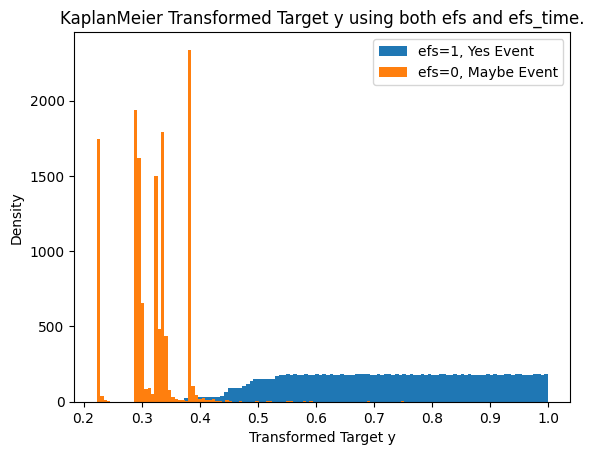

In [65]:
import numpy as np
from lifelines import KaplanMeierFitter

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):

    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities

def update_target_with_survival_probabilities(df, time_col='efs_time', event_col='efs'):

    race_group = sorted(df['race_group'].unique())
    survival_probs_dict = {}
    for race in race_group:
        race_df = df[df['race_group'] == race]
        survival_probs_dict[race] = transform_survival_probability(race_df, time_col, event_col)
    for race in race_group:
        df.loc[df['race_group'] == race, 'target'] = survival_probs_dict[race]
    df.loc[df[event_col] == 0, 'target'] -= 0.15
    
    return df['target']


# Example usage:
train["y"] = update_target_with_survival_probabilities(train, time_col='efs_time', event_col='efs')

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [66]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,target,y
0,0,0,0,0,0,NaN,6.0,0,0,6.0,0,0,0,0,0,6.0,0,8.0,2.0,0,6.0,2.0,0,2.0,2.0,0,0,0,0,2016,0,0,0,0,2.0,0,NaN,0,2.0,0,9.942000,2.0,0,0,0,2.0,0,0.0,90.0,0,0,0,0,8.0,0,2.0,0,10.0,0.0,42.356,0.380674,0.380674
1,1,1,0,1,0,2.0,8.0,1,0,6.0,1,0,0,0,1,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,1,1,0,2008,0,1,1,1,2.0,0,72.290001,0,2.0,0,43.705002,2.0,1,0,1,2.0,1,3.0,90.0,0,1,1,0,8.0,0,2.0,1,10.0,1.0,4.672,0.849116,0.849116
2,2,0,0,0,0,2.0,8.0,0,0,6.0,0,0,0,0,2,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,0,0,0,2019,0,0,0,0,2.0,0,NaN,0,2.0,0,33.997002,2.0,2,0,2,2.0,0,0.0,90.0,0,1,1,0,8.0,0,2.0,0,10.0,0.0,19.793,0.384824,0.384824
3,3,2,0,1,0,2.0,8.0,0,0,6.0,0,0,0,0,3,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,1,1,0,2009,0,1,1,1,2.0,0,29.230000,0,2.0,0,43.244999,2.0,3,0,3,2.0,2,0.0,90.0,1,1,0,0,8.0,0,2.0,0,10.0,0.0,102.349,0.223132,0.223132
4,4,2,0,0,0,2.0,8.0,0,0,6.0,1,0,0,0,4,6.0,0,10.0,2.0,0,6.0,2.0,0,2.0,2.0,1,0,1,1,2018,0,0,0,0,2.0,0,56.810001,0,2.0,0,29.740000,2.0,4,0,0,2.0,3,1.0,90.0,0,1,1,1,8.0,0,2.0,0,10.0,0.0,16.223,0.344127,0.344127


In [67]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_km_rmse = np.zeros(len(train))
pred_xgb_km_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )

    # model_xgb = XGBRegressor(
    #     device="cuda",
    #     max_depth=3,
    #     colsample_bytree=0.5,
    #     subsample=0.8,
    #     n_estimators=2000,
    #     learning_rate=0.02,
    #     enable_categorical=True,
    #     min_child_weight=80,
    #     #early_stopping_rounds=25,
    # )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_km_rmse[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_km_rmse += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_km_rmse /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.24072
[500]	validation_0-rmse:0.21619
[1000]	validation_0-rmse:0.21439
[1500]	validation_0-rmse:0.21382
[1999]	validation_0-rmse:0.21383
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.23630
[500]	validation_0-rmse:0.21090
[1000]	validation_0-rmse:0.20955
[1500]	validation_0-rmse:0.20924
[1999]	validation_0-rmse:0.20906
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.23889
[500]	validation_0-rmse:0.21238
[1000]	validation_0-rmse:0.21085
[1500]	validation_0-rmse:0.21048
[1999]	validation_0-rmse:0.21049
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.24019
[500]	validation_0-rmse:0.21452
[1000]	validation_0-rmse:0.21316
[1500]	validation_0-rmse:0.21276
[1999]	validation_0-rmse:0.21271
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.23474
[500]	valid

In [68]:
# 0.674

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_km_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier RMSE =",m)

C:\Users\Admin\AppData\Local\Temp\ipykernel_4448\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier RMSE = 0.6788090472152802


In [61]:

with open(r'gbdt-models\oof_xgb_km_rmse.pkl', 'wb') as f:
    pickle.dump(oof_xgb_km_rmse, f)
with open(r'gbdt-models\oof_xgb_km_rmse.pkl', 'rb') as f:
    oof_xgb_km_rmse = pickle.load(f)

In [62]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_km_rmse_skf = np.zeros(len(train))
pred_xgb_km_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )

    # model_xgb = XGBRegressor(
    #     device="cuda",
    #     max_depth=3,
    #     colsample_bytree=0.5,
    #     subsample=0.8,
    #     n_estimators=2000,
    #     learning_rate=0.02,
    #     enable_categorical=True,
    #     min_child_weight=80,
    #     #early_stopping_rounds=25,
    # )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_km_rmse_skf[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_km_rmse_skf += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_km_rmse_skf /= FOLDS


#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17642
[500]	validation_0-rmse:0.15825
[1000]	validation_0-rmse:0.15670
[1500]	validation_0-rmse:0.15621
[1999]	validation_0-rmse:0.15595
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17329
[500]	validation_0-rmse:0.15585
[1000]	validation_0-rmse:0.15472
[1500]	validation_0-rmse:0.15436
[1999]	validation_0-rmse:0.15433
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17508
[500]	validation_0-rmse:0.15582
[1000]	validation_0-rmse:0.15434
[1500]	validation_0-rmse:0.15378
[1999]	validation_0-rmse:0.15345
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17822
[500]	validation_0-rmse:0.15824
[1000]	validation_0-rmse:0.15655
[1500]	validation_0-rmse:0.15584
[1999]	validation_0-rmse:0.15552
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17429
[500]	valid

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_km_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier with Stratified KFold RMSE =",m)
with open(r'gbdt-models\oof_xgb_km_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_xgb_km_rmse_skf, f)
with open(r'gbdt-models\oof_xgb_km_rmse_skf.pkl', 'rb') as f:
    oof_xgb_km_rmse_skf = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier with Stratified KFold RMSE = 0.674726357960228


In [64]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_km_rmse_skf_dri = np.zeros(len(train))
pred_xgb_km_rmse_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        max_cat_to_onehot=15,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )

    # model_xgb = XGBRegressor(
    #     device="cuda",
    #     max_depth=3,
    #     colsample_bytree=0.5,
    #     subsample=0.8,
    #     n_estimators=2000,
    #     learning_rate=0.02,
    #     enable_categorical=True,
    #     min_child_weight=80,
    #     #early_stopping_rounds=25,
    # )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_km_rmse_skf_dri[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_km_rmse_skf_dri += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_km_rmse_skf_dri /= FOLDS


#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17688


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[500]	validation_0-rmse:0.15944
[1000]	validation_0-rmse:0.15839
[1500]	validation_0-rmse:0.15806
[1999]	validation_0-rmse:0.15809
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17538
[500]	validation_0-rmse:0.15607
[1000]	validation_0-rmse:0.15439
[1500]	validation_0-rmse:0.15385
[1999]	validation_0-rmse:0.15390
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17663
[500]	validation_0-rmse:0.15619
[1000]	validation_0-rmse:0.15429
[1500]	validation_0-rmse:0.15375
[1999]	validation_0-rmse:0.15338
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17864
[500]	validation_0-rmse:0.15996
[1000]	validation_0-rmse:0.15843
[1500]	validation_0-rmse:0.15770
[1999]	validation_0-rmse:0.15743
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17699
[500]	validation_0-rmse:0.16010
[1000]	validation_0-rmse:0.15892
[1500]	validation_0-rmse:0.15855
[1999]

In [65]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_km_rmse_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier with Stratified KFold RMSE =",m)

with open(r'gbdt-models\oof_xgb_km_rmse_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_xgb_km_rmse_skf_dri, f)
with open(r'gbdt-models\oof_xgb_km_rmse_skf_dri.pkl', 'rb') as f:
    oof_xgb_km_rmse_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier with Stratified KFold RMSE = 0.6749448674119329


# CATBOOST WITH KAPLANMEIER

In [ ]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_km_rmse = np.zeros(len(train))
pred_cat_km_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_km_rmse[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_km_rmse += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_km_rmse /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1743441	test: 0.1759830	best: 0.1759830 (0)	total: 15.3ms	remaining: 15.3s
250:	learn: 0.1415754	test: 0.1573331	best: 0.1573331 (250)	total: 3.45s	remaining: 10.3s
500:	learn: 0.1324307	test: 0.1569226	best: 0.1568219 (483)	total: 6.78s	remaining: 6.75s
750:	learn: 0.1250592	test: 0.1570821	best: 0.1568219 (483)	total: 10.2s	remaining: 3.39s
999:	learn: 0.1184994	test: 0.1571412	best: 0.1568219 (483)	total: 13.5s	remaining: 0us
bestTest = 0.1568218702
bestIteration = 483
Shrink model to first 484 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1748160	test: 0.1717328	best: 0.1717328 (0)	total: 15ms	remaining: 14.9s
250:	learn: 0.1420597	test: 0.1538882	best: 0.1538389 (242)	total: 3.34s	remaining: 9.97s
500:	learn: 0.1324747	test: 0.1533893	best: 0.1533893 (500)	total: 6.61s	remaining: 6.58s
750:	learn: 0.1252242	test: 0.1532621	best: 0.1531541 (567)	total: 9.79s	remaining

In [67]:
# 0.6728 - 0.673
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_km_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier RMSE =",m)

with open(r'gbdt-models\oof_cat_km_rmse.pkl', 'wb') as f:
    pickle.dump(oof_cat_km_rmse, f)
with open(r'gbdt-models\oof_cat_km_rmse.pkl', 'rb') as f:
    oof_cat_km_rmse = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier RMSE = 0.6722658728980095


In [68]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_km_rmse_2 = np.zeros(len(train))
pred_cat_km_rmse_2 = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_km_rmse_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_km_rmse_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_km_rmse_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1742476	test: 0.1759709	best: 0.1759709 (0)	total: 10.5ms	remaining: 10.5s
250:	learn: 0.1372960	test: 0.1575834	best: 0.1575178 (239)	total: 2.35s	remaining: 7s
500:	learn: 0.1263695	test: 0.1573230	best: 0.1572096 (464)	total: 4.68s	remaining: 4.67s
750:	learn: 0.1167433	test: 0.1573633	best: 0.1570298 (618)	total: 7.12s	remaining: 2.36s
999:	learn: 0.1083226	test: 0.1577525	best: 0.1570298 (618)	total: 9.52s	remaining: 0us
bestTest = 0.1570297536
bestIteration = 618
Shrink model to first 619 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1746759	test: 0.1717479	best: 0.1717479 (0)	total: 11.7ms	remaining: 11.7s
250:	learn: 0.1384121	test: 0.1538871	best: 0.1538595 (242)	total: 2.28s	remaining: 6.8s
500:	learn: 0.1270069	test: 0.1535898	best: 0.1535116 (445)	total: 4.49s	remaining: 4.48s
750:	learn: 0.1174540	test: 0.1537542	best: 0.1534150 (577)	total: 6.76s	remaining: 

In [69]:
# 0.6728 - 0.673
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_km_rmse_2    
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier RMSE 2 =",m)

with open(r'gbdt-models\oof_cat_km_rmse_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_km_rmse_2, f)
with open(r'gbdt-models\oof_cat_km_rmse_2.pkl', 'rb') as f:
    oof_cat_km_rmse_2 = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier RMSE 2 = 0.670640498551682


In [90]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_km_rmse_skf = np.zeros(len(train))
pred_cat_km_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_km_rmse_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_km_rmse_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_km_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1744622	test: 0.1748129	best: 0.1748129 (0)	total: 12.4ms	remaining: 12.4s
250:	learn: 0.1416263	test: 0.1570704	best: 0.1570230 (236)	total: 4.12s	remaining: 12.3s
500:	learn: 0.1326645	test: 0.1567563	best: 0.1566953 (478)	total: 11.1s	remaining: 11s
750:	learn: 0.1254028	test: 0.1571950	best: 0.1566953 (478)	total: 15.6s	remaining: 5.17s
999:	learn: 0.1192358	test: 0.1572861	best: 0.1566953 (478)	total: 19.5s	remaining: 0us
bestTest = 0.1566952867
bestIteration = 478
Shrink model to first 479 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1748241	test: 0.1715378	best: 0.1715378 (0)	total: 15.5ms	remaining: 15.5s
250:	learn: 0.1411950	test: 0.1546690	best: 0.1546551 (249)	total: 3.8s	remaining: 11.3s
500:	learn: 0.1319089	test: 0.1544165	best: 0.1542723 (436)	total: 7.34s	remaining: 7.31s
750:	learn: 0.1248767	test: 0.1546865	best: 0.1542723 (436)	total: 10.7s	remaining:

In [91]:
# 0.6746

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_km_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier with Stratified KFold RMSE =",m)
with open(r'gbdt-models\oof_cat_km_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_km_rmse_skf, f)
with open(r'gbdt-models\oof_cat_km_rmse_skf.pkl', 'rb') as f:
    oof_cat_km_rmse_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9924\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier with Stratified KFold RMSE = 0.6746720864865964


In [ ]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_km_rmse_2_skf = np.zeros(len(train))
pred_cat_km_rmse_2_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    model_filename = os.path.join(catboost_dir, f"oof_cat_km_rmse_2_skf{i+1}.cbm")
    model_cat.save_model(model_filename)
    print(f"Model for fold {i+1} saved as {model_filename}")

    # INFER OOF
    oof_cat_km_rmse_2_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_km_rmse_2_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_km_rmse_2_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1743583	test: 0.1747884	best: 0.1747884 (0)	total: 11.4ms	remaining: 11.4s
250:	learn: 0.1386592	test: 0.1568012	best: 0.1567946 (248)	total: 2.69s	remaining: 8.03s
500:	learn: 0.1280801	test: 0.1564848	best: 0.1564288 (369)	total: 5.29s	remaining: 5.27s
750:	learn: 0.1187599	test: 0.1568877	best: 0.1564288 (369)	total: 8.27s	remaining: 2.74s
999:	learn: 0.1105406	test: 0.1573553	best: 0.1564288 (369)	total: 10.8s	remaining: 0us
bestTest = 0.1564288155
bestIteration = 369
Shrink model to first 370 iterations.
Model for fold 1 saved as catboost_models\oof_cat_km_rmse_2_skf1.cbm
#########################
### Fold 2
#########################
0:	learn: 0.1747318	test: 0.1715062	best: 0.1715062 (0)	total: 11.4ms	remaining: 11.4s
250:	learn: 0.1380545	test: 0.1549059	best: 0.1548164 (229)	total: 2.58s	remaining: 7.71s
500:	learn: 0.1264627	test: 0.1553006	best: 0.1548164 (229)	total: 5.16s	remaining: 5.14s
750:	learn:

NameError: name 'pred_cat_km_rmse_2' is not defined

In [99]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_km_rmse_2_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier with Stratified KFold RMSE 2 =",m)
with open(r'gbdt-models\oof_cat_km_rmse_2_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_km_rmse_2_skf, f)
with open(r'gbdt-models\oof_cat_km_rmse_2_skf.pkl', 'rb') as f:
    oof_cat_km_rmse_2_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier with Stratified KFold RMSE 2 = 0.6726921807794476


In [74]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_km_rmse_skf_dri = np.zeros(len(train))
pred_cat_km_rmse_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_km_rmse_skf_dri[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_km_rmse_skf_dri += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_km_rmse_skf_dri /= FOLDS


#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: 0.1744418	test: 0.1751939	best: 0.1751939 (0)	total: 16.9ms	remaining: 16.8s
250:	learn: 0.1420821	test: 0.1591497	best: 0.1591089 (243)	total: 3.99s	remaining: 11.9s
500:	learn: 0.1330076	test: 0.1587591	best: 0.1586959 (421)	total: 8.04s	remaining: 8.01s
750:	learn: 0.1260598	test: 0.1591247	best: 0.1586959 (421)	total: 12.1s	remaining: 4.02s
999:	learn: 0.1200431	test: 0.1595006	best: 0.1586959 (421)	total: 16.2s	remaining: 0us
bestTest = 0.1586958717
bestIteration = 421
Shrink model to first 422 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1745881	test: 0.1736459	best: 0.1736459 (0)	total: 18.5ms	remaining: 18.5s
250:	learn: 0.1421309	test: 0.1553179	best: 0.1552976 (246)	total: 4.06s	remaining: 12.1s
500:	learn: 0.1330785	test: 0.1555650	best: 0.1552772 (258)	total: 8.18s	remaining: 8.15s
750:	learn: 0.1262570	test: 0.1559166	best: 0.1552772 (258)	total: 12.4s	remaining: 4.11s
999:	learn: 0.1199007	test: 0.1563320	best: 0.1552772

In [75]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_km_rmse_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier with Stratified KFold RMSE =",m)

with open(r'gbdt-models\oof_cat_km_rmse_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_km_rmse_skf_dri, f)
with open(r'gbdt-models\oof_cat_km_rmse_skf_dri.pkl', 'rb') as f:
    oof_cat_km_rmse_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier with Stratified KFold RMSE = 0.6729581349575774


In [76]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_km_rmse_2_skf_dri = np.zeros(len(train))
pred_cat_km_rmse_2_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_km_rmse_2_skf_dri[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_km_rmse_2_skf_dri += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_km_rmse_2_skf_dri /= FOLDS


#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: 0.1743184	test: 0.1751648	best: 0.1751648 (0)	total: 14.3ms	remaining: 14.2s
250:	learn: 0.1384311	test: 0.1592264	best: 0.1591930 (249)	total: 2.37s	remaining: 7.08s
500:	learn: 0.1276118	test: 0.1594139	best: 0.1590431 (376)	total: 4.7s	remaining: 4.68s
750:	learn: 0.1189396	test: 0.1596060	best: 0.1590431 (376)	total: 7.06s	remaining: 2.34s
999:	learn: 0.1109848	test: 0.1597919	best: 0.1590431 (376)	total: 9.39s	remaining: 0us
bestTest = 0.1590430632
bestIteration = 376
Shrink model to first 377 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1745002	test: 0.1736756	best: 0.1736756 (0)	total: 10.1ms	remaining: 10.1s
250:	learn: 0.1381659	test: 0.1553413	best: 0.1553323 (249)	total: 2.32s	remaining: 6.92s
500:	learn: 0.1272048	test: 0.1553715	best: 0.1551553 (396)	total: 4.96s	remaining: 4.94s
750:	learn: 0.1180815	test: 0.1558215	best: 0.1551553 (396)	total: 7.62s	remaining: 2.53s
999:	learn: 0.1098441	test: 0.1563419	best: 0.1551553 

In [77]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_km_rmse_2_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier with Stratified KFold RMSE 2 =",m)

with open(r'gbdt-models\oof_cat_km_rmse_2_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_km_rmse_2_skf_dri, f)
with open(r'gbdt-models\oof_cat_km_rmse_2_skf_dri.pkl', 'rb') as f:
    oof_cat_km_rmse_2_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier with Stratified KFold RMSE 2 = 0.6718645156669959


# XGBOOST WITH SURVIVAL:COX

In [78]:
# SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [79]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_cox = np.zeros(len(train))
pred_xgb_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        max_cat_to_onehot=10,
        objective='survival:cox',
        eval_metric='cox-nloglik',
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-cox-nloglik:7.62434
[500]	validation_0-cox-nloglik:7.42358
[1000]	validation_0-cox-nloglik:7.41318
[1500]	validation_0-cox-nloglik:7.41045
[1999]	validation_0-cox-nloglik:7.41069
#########################
### Fold 2
#########################
[0]	validation_0-cox-nloglik:7.61763
[500]	validation_0-cox-nloglik:7.40088
[1000]	validation_0-cox-nloglik:7.39328
[1500]	validation_0-cox-nloglik:7.39131
[1999]	validation_0-cox-nloglik:7.39133
#########################
### Fold 3
#########################
[0]	validation_0-cox-nloglik:7.60952
[500]	validation_0-cox-nloglik:7.39485
[1000]	validation_0-cox-nloglik:7.38799
[1500]	validation_0-cox-nloglik:7.38934
[1999]	validation_0-cox-nloglik:7.39274
#########################
### Fold 4
#########################
[0]	validation_0-cox-nloglik:7.60533
[500]	validation_0-cox-nloglik:7.40404
[1000]	validation_0-cox-nloglik:7.40140
[1500]	validation_0-cox-nloglik:7.40342
[199

In [80]:
# 0.6737
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox =",m)

with open(r'gbdt-models\oof_xgb_cox.pkl', 'wb') as f:
    pickle.dump(oof_xgb_cox, f)
with open(r'gbdt-models\oof_xgb_cox.pkl', 'rb') as f:
    oof_xgb_cox = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Survival:Cox = 0.6731392762072294


In [81]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_cox_skf = np.zeros(len(train))
pred_xgb_cox_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        max_cat_to_onehot=10,
        objective='survival:cox',
        eval_metric='cox-nloglik',
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_cox_skf[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox_skf += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox_skf /= FOLDS



#########################
### Fold 1
#########################
[0]	validation_0-cox-nloglik:7.61743
[500]	validation_0-cox-nloglik:7.42557
[1000]	validation_0-cox-nloglik:7.41763
[1500]	validation_0-cox-nloglik:7.41724
[1999]	validation_0-cox-nloglik:7.41914
#########################
### Fold 2
#########################
[0]	validation_0-cox-nloglik:7.61379
[500]	validation_0-cox-nloglik:7.41600
[1000]	validation_0-cox-nloglik:7.41087
[1500]	validation_0-cox-nloglik:7.41326
[1999]	validation_0-cox-nloglik:7.41631
#########################
### Fold 3
#########################
[0]	validation_0-cox-nloglik:7.61853
[500]	validation_0-cox-nloglik:7.39921
[1000]	validation_0-cox-nloglik:7.39054
[1500]	validation_0-cox-nloglik:7.39155
[1999]	validation_0-cox-nloglik:7.39257
#########################
### Fold 4
#########################
[0]	validation_0-cox-nloglik:7.61916
[500]	validation_0-cox-nloglik:7.41658
[1000]	validation_0-cox-nloglik:7.40533
[1500]	validation_0-cox-nloglik:7.40364
[199

In [82]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox with Stratified KFold =",m)

with open(r'gbdt-models\oof_xgb_cox_skf.pkl', 'wb') as f:
    pickle.dump(oof_xgb_cox_skf, f)
with open(r'gbdt-models\oof_xgb_cox_skf.pkl', 'rb') as f:
    oof_xgb_cox_skf = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Survival:Cox with Stratified KFold = 0.6735783634919592


In [83]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_cox_skf_dri = np.zeros(len(train))
pred_xgb_cox_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        max_cat_to_onehot=10,
        objective='survival:cox',
        eval_metric='cox-nloglik',
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_cox_skf_dri[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox_skf_dri += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox_skf_dri /= FOLDS




#########################
### Fold 1
#########################
[0]	validation_0-cox-nloglik:7.61149


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[500]	validation_0-cox-nloglik:7.42691
[1000]	validation_0-cox-nloglik:7.42243
[1500]	validation_0-cox-nloglik:7.42142
[1999]	validation_0-cox-nloglik:7.42260
#########################
### Fold 2
#########################
[0]	validation_0-cox-nloglik:7.62373
[500]	validation_0-cox-nloglik:7.42603
[1000]	validation_0-cox-nloglik:7.41635
[1500]	validation_0-cox-nloglik:7.41387
[1999]	validation_0-cox-nloglik:7.41658
#########################
### Fold 3
#########################
[0]	validation_0-cox-nloglik:7.62023
[500]	validation_0-cox-nloglik:7.40019
[1000]	validation_0-cox-nloglik:7.38759
[1500]	validation_0-cox-nloglik:7.38323
[1999]	validation_0-cox-nloglik:7.38219
#########################
### Fold 4
#########################
[0]	validation_0-cox-nloglik:7.62328
[500]	validation_0-cox-nloglik:7.42541
[1000]	validation_0-cox-nloglik:7.41581
[1500]	validation_0-cox-nloglik:7.41516
[1999]	validation_0-cox-nloglik:7.41561
#########################
### Fold 5
#########################
[

In [84]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox with Stratified KFold =",m)
with open(r'gbdt-models\oof_xgb_cox_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_xgb_cox_skf_dri, f)
with open(r'gbdt-models\oof_xgb_cox_skf_dri.pkl', 'rb') as f:
    oof_xgb_cox_skf_dri = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Survival:Cox with Stratified KFold = 0.6735465289235288


# CATBOOST WITH SURVIVAL:COX

In [85]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_cox = np.zeros(len(train))
pred_cat_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",
        iterations=400,
        learning_rate=0.1,
        grow_policy='Lossguide',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat_cox[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox /= FOLDS

#########################
### Fold 1
#########################
0:	learn: -137203.4972274	test: -11624.9391519	best: -11624.9391519 (0)	total: 315ms	remaining: 2m 5s
100:	learn: -134274.0334161	test: -11370.5106795	best: -11370.4639798 (99)	total: 28.9s	remaining: 1m 25s
200:	learn: -133556.4677943	test: -11350.8901772	best: -11350.8259345 (193)	total: 57.3s	remaining: 56.7s
300:	learn: -133151.7556222	test: -11345.1824685	best: -11345.0082850 (299)	total: 1m 26s	remaining: 28.4s
399:	learn: -132827.8066020	test: -11344.5990526	best: -11344.5856048 (398)	total: 1m 51s	remaining: 0us

bestTest = -11344.5856
bestIteration = 398

#########################
### Fold 2
#########################
0:	learn: -137010.2663543	test: -11772.7633615	best: -11772.7633615 (0)	total: 260ms	remaining: 1m 43s
100:	learn: -134101.0787289	test: -11481.6234971	best: -11481.2822379 (98)	total: 26.2s	remaining: 1m 17s
200:	learn: -133323.8686807	test: -11459.8203562	best: -11459.8203562 (200)	total: 52.5s	remai

In [86]:
# 0.6707
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",m)

with open(r'gbdt-models\oof_cat_cox.pkl', 'wb') as f:
    pickle.dump(oof_cat_cox, f)
with open(r'gbdt-models\oof_cat_cox.pkl', 'rb') as f:
    oof_cat_cox = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox = 0.6707014043059745


In [87]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_cox_skf = np.zeros(len(train))
pred_cat_cox_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",
        iterations=400,
        learning_rate=0.1,
        grow_policy='Lossguide',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat_cox_skf[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox_skf += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox_skf /= FOLDS


#########################
### Fold 1
#########################
0:	learn: -136958.4423149	test: -11814.2382395	best: -11814.2382395 (0)	total: 315ms	remaining: 2m 5s
100:	learn: -133975.6849288	test: -11539.0804467	best: -11539.0804467 (100)	total: 35.6s	remaining: 1m 45s
200:	learn: -133272.5372561	test: -11521.8997034	best: -11521.4916002 (194)	total: 1m 10s	remaining: 1m 9s
300:	learn: -132842.4875253	test: -11522.5525932	best: -11520.7260673 (244)	total: 1m 48s	remaining: 35.7s
399:	learn: -132477.4412291	test: -11518.1629535	best: -11518.1629535 (398)	total: 2m 21s	remaining: 0us

bestTest = -11518.16295
bestIteration = 398

#########################
### Fold 2
#########################
0:	learn: -136969.8194959	test: -11806.3131465	best: -11806.3131465 (0)	total: 318ms	remaining: 2m 6s
100:	learn: -134055.7724812	test: -11534.8537100	best: -11534.8537100 (100)	total: 35.8s	remaining: 1m 45s
200:	learn: -133362.1359057	test: -11517.5745558	best: -11517.2097074 (196)	total: 1m 13s	r

In [88]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox with Stratified KFold =",m)

with open(r'gbdt-models\oof_cat_cox_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_cox_skf, f)
with open(r'gbdt-models\oof_cat_cox_skf.pkl', 'rb') as f:
    oof_cat_cox_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox with Stratified KFold = 0.6687357396191984


In [89]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_cox_skf_dri = np.zeros(len(train))
pred_cat_cox_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",
        iterations=400,
        learning_rate=0.1,
        grow_policy='Lossguide',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat_cox_skf_dri[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox_skf_dri += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox_skf_dri /= FOLDS


#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: -136794.7056464	test: -11949.2031518	best: -11949.2031518 (0)	total: 748ms	remaining: 4m 58s
100:	learn: -133839.5795620	test: -11700.6804095	best: -11700.6804095 (100)	total: 1m 12s	remaining: 3m 35s
200:	learn: -132996.8145996	test: -11678.3217578	best: -11678.3217578 (200)	total: 2m 24s	remaining: 2m 23s
300:	learn: -132631.3404866	test: -11677.1162556	best: -11676.4186367 (278)	total: 3m 37s	remaining: 1m 11s
399:	learn: -132315.9160740	test: -11678.0003414	best: -11676.4186367 (278)	total: 4m 29s	remaining: 0us

bestTest = -11676.41864
bestIteration = 278

#########################
### Fold 2
#########################
0:	learn: -137093.1013061	test: -11701.6872828	best: -11701.6872828 (0)	total: 597ms	remaining: 3m 58s
100:	learn: -134147.5791324	test: -11431.3901523	best: -11431.3901523 (100)	total: 1m 4s	remaining: 3m 9s
200:	learn: -133426.6942228	test: -11415.1644622	best: -11415.1644622 (200)	total: 2m 14s	remaining: 2m 13s
300:	learn: -132982.2611167	test: -11414.6

In [90]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox with Stratified KFold =",m)

with open(r'gbdt-models\oof_cat_cox_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_cox_skf_dri, f)
with open(r'gbdt-models\oof_cat_cox_skf_dri.pkl', 'rb') as f:
    oof_cat_cox_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox with Stratified KFold = 0.6698488023091367


In [91]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_cox_2 = np.zeros(len(train))
pred_cat_cox_2 = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",
        iterations=400,
        learning_rate=0.1,
        grow_policy='Depthwise',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat_cox_2[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox_2 += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: -137208.4703902	test: -11626.7218301	best: -11626.7218301 (0)	total: 123ms	remaining: 49.2s
100:	learn: -134094.5791192	test: -11368.2494850	best: -11368.2494850 (100)	total: 11s	remaining: 32.5s
200:	learn: -133378.3778626	test: -11348.6758434	best: -11348.6758434 (200)	total: 21.4s	remaining: 21.2s
300:	learn: -132954.9839051	test: -11345.5846532	best: -11345.4481444 (284)	total: 32s	remaining: 10.5s
399:	learn: -132549.5425138	test: -11341.4586962	best: -11341.0423410 (390)	total: 41.9s	remaining: 0us

bestTest = -11341.04234
bestIteration = 390

#########################
### Fold 2
#########################
0:	learn: -137010.1364805	test: -11772.3043169	best: -11772.3043169 (0)	total: 121ms	remaining: 48.2s
100:	learn: -133916.4253420	test: -11477.6057167	best: -11477.5333456 (98)	total: 11.5s	remaining: 34s
200:	learn: -133088.6982362	test: -11463.4749811	best: -11463.3704389 (199)	total: 22.7s	remaining: 22.

In [92]:
# 0.6707
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",m)

with open(r'gbdt-models\oof_cat_cox_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_cox_2, f)
with open(r'gbdt-models\oof_cat_cox_2.pkl', 'rb') as f:
    oof_cat_cox_2 = pickle.load(f)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox = 0.6703700629979105


In [93]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_cox_2_skf = np.zeros(len(train))
pred_cat_cox_2_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",
        iterations=400,
        learning_rate=0.1,
        grow_policy='Depthwise',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat_cox_2_skf[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox_2_skf += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox_2_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: -136963.7671078	test: -11813.7469642	best: -11813.7469642 (0)	total: 136ms	remaining: 54.3s
100:	learn: -133815.7409182	test: -11542.3841609	best: -11541.7210158 (99)	total: 11.2s	remaining: 33.2s
200:	learn: -133045.0717261	test: -11529.0008745	best: -11528.6753638 (172)	total: 21.4s	remaining: 21.2s
300:	learn: -132607.2130648	test: -11528.5963380	best: -11527.9720042 (248)	total: 33.3s	remaining: 10.9s
399:	learn: -132231.7078338	test: -11529.4340470	best: -11526.9927412 (331)	total: 44.3s	remaining: 0us

bestTest = -11526.99274
bestIteration = 331

#########################
### Fold 2
#########################
0:	learn: -136961.6565903	test: -11807.6655626	best: -11807.6655626 (0)	total: 107ms	remaining: 42.8s
100:	learn: -133898.8028599	test: -11541.6413234	best: -11541.3926338 (99)	total: 11.9s	remaining: 35.2s
200:	learn: -133043.4794608	test: -11529.0454784	best: -11526.5261824 (196)	total: 22s	remaining: 

In [94]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox_2_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox with Stratified KFold =",m)

with open(r'gbdt-models\oof_cat_cox_2_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_cox_2_skf, f)
with open(r'gbdt-models\oof_cat_cox_2_skf.pkl', 'rb') as f:
    oof_cat_cox_2_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox with Stratified KFold = 0.6700083269854161


In [95]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_cox_2_skf_dri = np.zeros(len(train))
pred_cat_cox_2_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",
        iterations=400,
        learning_rate=0.1,
        grow_policy='Depthwise',
        use_best_model=False,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat_cox_2_skf_dri[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox_2_skf_dri += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox_2_skf_dri /= FOLDS

#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: -136790.7888492	test: -11949.2991599	best: -11949.2991599 (0)	total: 107ms	remaining: 42.9s
100:	learn: -133692.8360222	test: -11704.0760471	best: -11704.0760471 (100)	total: 12.1s	remaining: 35.9s
200:	learn: -132815.1579827	test: -11694.9860088	best: -11694.5194035 (150)	total: 23.7s	remaining: 23.5s
300:	learn: -132353.6129406	test: -11694.2727664	best: -11693.5725330 (282)	total: 33.7s	remaining: 11.1s
399:	learn: -132044.1020474	test: -11696.3767605	best: -11693.5725330 (282)	total: 43.6s	remaining: 0us

bestTest = -11693.57253
bestIteration = 282

#########################
### Fold 2
#########################
0:	learn: -137105.2904766	test: -11700.7127487	best: -11700.7127487 (0)	total: 121ms	remaining: 48.3s
100:	learn: -133959.2454803	test: -11436.2148031	best: -11436.2148031 (100)	total: 12.2s	remaining: 36s
200:	learn: -133289.3912768	test: -11424.3106209	best: -11422.1885766 (185)	total: 23.6s	remaining: 23.4s
300:	learn: -132792.3979535	test: -11415.8195038	best: 

In [96]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox_2_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox with Stratified KFold =",m)

with open(r'gbdt-models\oof_cat_cox_2_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_cox_2_skf_dri, f)
with open(r'gbdt-models\oof_cat_cox_2_skf_dri.pkl', 'rb') as f:
    oof_cat_cox_2_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox with Stratified KFold = 0.669441916951797


# XGBOOST WITH NELSON-AALEN

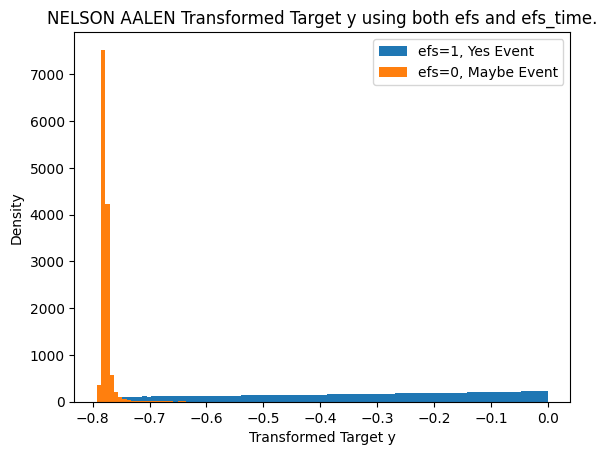

In [79]:
from lifelines import NelsonAalenFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    naf = NelsonAalenFitter()
    naf.fit(df[time_col], df[event_col])
    y = -naf.cumulative_hazard_at_times(df[time_col]).values
    return y

train["y_naf"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')


plt.hist(train.loc[train.efs==1,"y_naf"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_naf"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("NELSON AALEN Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [98]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_naf_rmse = np.zeros(len(train))
pred_xgb_naf_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        max_cat_to_onehot=10,
        objective='reg:squarederror',
        #early_stopping_rounds=25,
    )

    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_naf_rmse[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_naf_rmse += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_naf_rmse /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.27387
[500]	validation_0-rmse:0.24436
[1000]	validation_0-rmse:0.24200
[1500]	validation_0-rmse:0.24114
[1999]	validation_0-rmse:0.24118
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.26774
[500]	validation_0-rmse:0.23855
[1000]	validation_0-rmse:0.23713
[1500]	validation_0-rmse:0.23658
[1999]	validation_0-rmse:0.23639
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.27218
[500]	validation_0-rmse:0.24056
[1000]	validation_0-rmse:0.23841
[1500]	validation_0-rmse:0.23775
[1999]	validation_0-rmse:0.23744
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.27506
[500]	validation_0-rmse:0.24418
[1000]	validation_0-rmse:0.24203
[1500]	validation_0-rmse:0.24137
[1999]	validation_0-rmse:0.24111
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.26816
[500]	valid

In [99]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_naf_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost NelsonAalen RMSE =",m)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost NelsonAalen RMSE = 0.6765736124955821


In [100]:
with open(r'gbdt-models\oof_xgb_naf_rmse.pkl', 'wb') as f:
    pickle.dump(oof_xgb_naf_rmse, f)
with open(r'gbdt-models\oof_xgb_naf_rmse.pkl', 'rb') as f:
    oof_xgb_naf_rmse = pickle.load(f)


In [101]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

oof_xgb_naf_rmse_skf = np.zeros(len(train))
pred_xgb_naf_rmse_skf = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        max_cat_to_onehot=10,
        objective='reg:squarederror',
        #early_stopping_rounds=25,
    )

    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_naf_rmse_skf[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_naf_rmse_skf += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_naf_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.27159
[500]	validation_0-rmse:0.24423
[1000]	validation_0-rmse:0.24216
[1500]	validation_0-rmse:0.24139
[1999]	validation_0-rmse:0.24103
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.26755
[500]	validation_0-rmse:0.24101
[1000]	validation_0-rmse:0.23925
[1500]	validation_0-rmse:0.23892
[1999]	validation_0-rmse:0.23884
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.26952
[500]	validation_0-rmse:0.24007
[1000]	validation_0-rmse:0.23793
[1500]	validation_0-rmse:0.23693
[1999]	validation_0-rmse:0.23673
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.27382
[500]	validation_0-rmse:0.24390
[1000]	validation_0-rmse:0.24137
[1500]	validation_0-rmse:0.24046
[1999]	validation_0-rmse:0.24001
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.26877
[500]	valid

In [102]:
# 0.6782

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_naf_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost NelsonAalen RMSE =",m)

with open(r'gbdt-models\oof_xgb_naf_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_xgb_naf_rmse_skf, f)
with open(r'gbdt-models\oof_xgb_naf_rmse_skf.pkl', 'rb') as f:
    oof_xgb_naf_rmse_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost NelsonAalen RMSE = 0.6770227854259684


In [103]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_naf_rmse_skf_dri = np.zeros(len(train))
pred_xgb_naf_rmse_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        max_cat_to_onehot=10,
        objective='reg:squarederror',
        #early_stopping_rounds=25,
    )

    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_naf_rmse_skf_dri[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_naf_rmse_skf_dri += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_naf_rmse_skf_dri /= FOLDS

#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[0]	validation_0-rmse:0.27221
[500]	validation_0-rmse:0.24591
[1000]	validation_0-rmse:0.24433
[1500]	validation_0-rmse:0.24381
[1999]	validation_0-rmse:0.24393
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.27059
[500]	validation_0-rmse:0.24142
[1000]	validation_0-rmse:0.23911
[1500]	validation_0-rmse:0.23833
[1999]	validation_0-rmse:0.23821
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.27113
[500]	validation_0-rmse:0.24036
[1000]	validation_0-rmse:0.23764
[1500]	validation_0-rmse:0.23678
[1999]	validation_0-rmse:0.23646
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.27458
[500]	validation_0-rmse:0.24636
[1000]	validation_0-rmse:0.24408
[1500]	validation_0-rmse:0.24314
[1999]	validation_0-rmse:0.24280
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.27254
[500]	validation_0-rmse:0.24727
[1000]	validation_0-rmse:0.24566
[1500]	va

In [104]:
# 0.6775

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_naf_rmse_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost NelsonAalen RMSE =",m)

with open(r'gbdt-models\oof_xgb_naf_rmse_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_xgb_naf_rmse_skf_dri, f)
with open(r'gbdt-models\oof_xgb_naf_rmse_skf_dri.pkl', 'rb') as f:
    oof_xgb_naf_rmse_skf_dri = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost NelsonAalen RMSE = 0.6779471427734963


# CATBOOST WITH NELSON-AALEN

In [105]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_naf = np.zeros(len(train))
pred_cat_naf = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_naf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_naf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_naf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.2683309	test: 0.2712302	best: 0.2712302 (0)	total: 28.2ms	remaining: 28.2s
250:	learn: 0.2192409	test: 0.2440841	best: 0.2440841 (250)	total: 4.62s	remaining: 13.8s
500:	learn: 0.2057863	test: 0.2437180	best: 0.2436848 (498)	total: 9.09s	remaining: 9.06s
750:	learn: 0.1942168	test: 0.2439837	best: 0.2434811 (624)	total: 13.5s	remaining: 4.47s
999:	learn: 0.1839738	test: 0.2443616	best: 0.2434811 (624)	total: 17.9s	remaining: 0us
bestTest = 0.2434811079
bestIteration = 624
Shrink model to first 625 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.2690791	test: 0.2648683	best: 0.2648683 (0)	total: 17.8ms	remaining: 17.8s
250:	learn: 0.2199136	test: 0.2377919	best: 0.2377226 (232)	total: 4.51s	remaining: 13.5s
500:	learn: 0.2056468	test: 0.2380074	best: 0.2376590 (386)	total: 9.17s	remaining: 9.13s
750:	learn: 0.1945701	test: 0.2381098	best: 0.2376590 (386)	total: 13.8s	remaini

In [106]:
# 0.6755
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_naf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost NelsonAalen =",m)

with open(r'gbdt-models\oof_cat_naf.pkl', 'wb') as f:
    pickle.dump(oof_cat_naf, f)
with open(r'gbdt-models\oof_cat_naf.pkl', 'rb') as f:
    oof_cat_naf = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost NelsonAalen = 0.674175376995045


In [107]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_naf_skf = np.zeros(len(train))
pred_cat_naf_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_naf_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_naf_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_naf_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.2685552	test: 0.2689149	best: 0.2689149 (0)	total: 21.4ms	remaining: 21.4s
250:	learn: 0.2199203	test: 0.2414250	best: 0.2414170 (243)	total: 4.55s	remaining: 13.6s
500:	learn: 0.2072176	test: 0.2407246	best: 0.2405092 (465)	total: 9.2s	remaining: 9.17s
750:	learn: 0.1965140	test: 0.2404213	best: 0.2403906 (741)	total: 13.6s	remaining: 4.5s
999:	learn: 0.1869646	test: 0.2410923	best: 0.2403906 (741)	total: 17.3s	remaining: 0us
bestTest = 0.2403906117
bestIteration = 741
Shrink model to first 742 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.2690532	test: 0.2648150	best: 0.2648150 (0)	total: 14.9ms	remaining: 14.9s
250:	learn: 0.2194403	test: 0.2400219	best: 0.2399683 (244)	total: 3.79s	remaining: 11.3s
500:	learn: 0.2062269	test: 0.2400933	best: 0.2398700 (406)	total: 7.51s	remaining: 7.48s
750:	learn: 0.1950230	test: 0.2402228	best: 0.2398169 (539)	total: 11s	remaining: 

In [108]:
# 0.6755
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_naf_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost NelsonAalen =",m)

with open(r'gbdt-models\oof_cat_naf_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_naf_skf, f)
with open(r'gbdt-models\oof_cat_naf_skf.pkl', 'rb') as f:
    oof_cat_naf_skf = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost NelsonAalen = 0.6752916877046071


In [109]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_naf_skf_dri = np.zeros(len(train))
pred_cat_naf_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_naf_skf_dri[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_naf_skf_dri += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_naf_skf_dri /= FOLDS

#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: 0.2685314	test: 0.2695283	best: 0.2695283 (0)	total: 28.2ms	remaining: 28.2s
250:	learn: 0.2199870	test: 0.2463929	best: 0.2462404 (243)	total: 4.96s	remaining: 14.8s
500:	learn: 0.2070521	test: 0.2455885	best: 0.2455042 (494)	total: 9.73s	remaining: 9.69s
750:	learn: 0.1958294	test: 0.2456578	best: 0.2453504 (646)	total: 14.3s	remaining: 4.73s
999:	learn: 0.1867568	test: 0.2459190	best: 0.2453504 (646)	total: 18.8s	remaining: 0us
bestTest = 0.2453503665
bestIteration = 646
Shrink model to first 647 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.2687121	test: 0.2678454	best: 0.2678454 (0)	total: 19.7ms	remaining: 19.6s
250:	learn: 0.2198327	test: 0.2406652	best: 0.2406634 (247)	total: 4.72s	remaining: 14.1s
500:	learn: 0.2069814	test: 0.2404796	best: 0.2401899 (470)	total: 9.35s	remaining: 9.31s
750:	learn: 0.1962062	test: 0.2410021	best: 0.2401899 (470)	total: 13.9s	remaining: 4.61s
999:	learn: 0.1863228	test: 0.2416749	best: 0.2401899

In [110]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_naf_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost NelsonAalen =",m)

with open(r'gbdt-models\oof_cat_naf_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_naf_skf_dri, f)
with open(r'gbdt-models\oof_cat_naf_skf_dri.pkl', 'rb') as f:
    oof_cat_naf_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost NelsonAalen = 0.6753797380863803


In [111]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_naf_2 = np.zeros(len(train))
pred_cat_naf_2 = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_naf_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_naf_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_naf_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.2682203	test: 0.2712034	best: 0.2712034 (0)	total: 14.7ms	remaining: 14.7s
250:	learn: 0.2137695	test: 0.2434507	best: 0.2434202 (246)	total: 3.39s	remaining: 10.1s
500:	learn: 0.1969416	test: 0.2429297	best: 0.2429275 (495)	total: 6.68s	remaining: 6.65s
750:	learn: 0.1816245	test: 0.2438983	best: 0.2429267 (574)	total: 10s	remaining: 3.32s
999:	learn: 0.1687159	test: 0.2449304	best: 0.2429267 (574)	total: 13s	remaining: 0us
bestTest = 0.2429266694
bestIteration = 574
Shrink model to first 575 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.2690153	test: 0.2648916	best: 0.2648916 (0)	total: 14.5ms	remaining: 14.5s
250:	learn: 0.2143584	test: 0.2371077	best: 0.2370034 (236)	total: 2.92s	remaining: 8.72s
500:	learn: 0.1970557	test: 0.2369884	best: 0.2365782 (372)	total: 5.87s	remaining: 5.84s
750:	learn: 0.1823919	test: 0.2372532	best: 0.2365782 (372)	total: 8.8s	remaining: 2

In [112]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_naf_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost NelsonAalen =",m)

with open(r'gbdt-models\oof_cat_naf_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_naf_2, f)
with open(r'gbdt-models\oof_cat_naf_2.pkl', 'rb') as f:
    oof_cat_naf_2 = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost NelsonAalen = 0.6740437877492221


In [80]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_naf_2_skf = np.zeros(len(train))
pred_cat_naf_2_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)
    
    model_filename = os.path.join(catboost_dir, f"oof_cat_naf_2_skf{i+1}.cbm")
    model_cat.save_model(model_filename)
    print(f"Model for fold {i+1} saved as {model_filename}")


    # INFER OOF
    oof_cat_naf_2_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_naf_2_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_naf_2_skf /= FOLDS


#########################
### Fold 1
#########################
0:	learn: 0.2684455	test: 0.2688291	best: 0.2688291 (0)	total: 14.3ms	remaining: 14.2s
250:	learn: 0.2152832	test: 0.2413171	best: 0.2411197 (235)	total: 2.23s	remaining: 6.67s
500:	learn: 0.1987649	test: 0.2409096	best: 0.2408278 (464)	total: 4.71s	remaining: 4.69s
750:	learn: 0.1847202	test: 0.2410899	best: 0.2407408 (658)	total: 7.24s	remaining: 2.4s
999:	learn: 0.1721565	test: 0.2419136	best: 0.2407408 (658)	total: 9.72s	remaining: 0us
bestTest = 0.2407408134
bestIteration = 658
Shrink model to first 659 iterations.
Model for fold 1 saved as catboost_models\oof_cat_naf_2_skf1.cbm
#########################
### Fold 2
#########################
0:	learn: 0.2689649	test: 0.2648031	best: 0.2648031 (0)	total: 10.4ms	remaining: 10.4s
250:	learn: 0.2131089	test: 0.2402576	best: 0.2401906 (239)	total: 2.48s	remaining: 7.41s
500:	learn: 0.1960154	test: 0.2401455	best: 0.2400152 (465)	total: 4.81s	remaining: 4.79s
750:	learn: 0.18

In [82]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_naf_2_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost NelsonAalen =",m)

with open(r'gbdt-models\oof_cat_naf_2_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_naf_2_skf, f)
with open(r'gbdt-models\oof_cat_naf_2_skf.pkl', 'rb') as f:
    oof_cat_naf_2_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost NelsonAalen = 0.6751845698914398


In [115]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_naf_2_skf_dri = np.zeros(len(train))
pred_cat_naf_2_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_naf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_naf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_naf_2_skf_dri[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_naf_2_skf_dri += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_naf_2_skf_dri /= FOLDS


#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: 0.2684172	test: 0.2694428	best: 0.2694428 (0)	total: 13.6ms	remaining: 13.6s
250:	learn: 0.2151673	test: 0.2456772	best: 0.2454806 (189)	total: 3.17s	remaining: 9.46s
500:	learn: 0.1987124	test: 0.2461690	best: 0.2454806 (189)	total: 6.12s	remaining: 6.1s
750:	learn: 0.1855335	test: 0.2455046	best: 0.2454235 (745)	total: 9.48s	remaining: 3.14s
999:	learn: 0.1726639	test: 0.2461419	best: 0.2454235 (745)	total: 12.6s	remaining: 0us
bestTest = 0.2454235174
bestIteration = 745
Shrink model to first 746 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.2686187	test: 0.2678123	best: 0.2678123 (0)	total: 10.8ms	remaining: 10.8s
250:	learn: 0.2137303	test: 0.2407942	best: 0.2407678 (247)	total: 2.4s	remaining: 7.18s
500:	learn: 0.1975118	test: 0.2405552	best: 0.2405212 (296)	total: 4.71s	remaining: 4.7s
750:	learn: 0.1831438	test: 0.2418750	best: 0.2404807 (504)	total: 6.98s	remaining: 2.31s
999:	learn: 0.1708180	test: 0.2423835	best: 0.2404807 (5

In [116]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_naf_2_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost NelsonAalen =",m)

with open(r'gbdt-models\oof_cat_naf_2_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_naf_2_skf_dri, f)
with open(r'gbdt-models\oof_cat_naf_2_skf_dri.pkl', 'rb') as f:
    oof_cat_naf_2_skf_dri = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost NelsonAalen = 0.673689015920544


# XGB WITH SURVIVAL:AFT

In [117]:
%%time


FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_aft = np.zeros(len(train))
pred_xgb_aft = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    x_valid = train.loc[test_index,FEATURES].copy()
    d_tr = xgb.DMatrix(x_train, enable_categorical=True)
    d_tr.set_float_info('label_lower_bound', train.efs_time.iloc[train_index])
    d_tr.set_float_info('label_upper_bound', np.where(train.efs.iloc[train_index]==0, np.inf,
                                                      train.efs_time.iloc[train_index]))
    d_val = xgb.DMatrix(x_valid, enable_categorical=True)
    d_val.set_float_info('label_lower_bound', train.efs_time.iloc[test_index])
    d_val.set_float_info('label_upper_bound', np.where(train.efs.iloc[test_index]==0, np.inf,
                                                      train.efs_time.iloc[test_index]))


    y_train = train.loc[train_index,"efs_time2"]
    y_valid = train.loc[test_index,"efs_time2"]


    x_test = test[FEATURES].copy()

    xgboost_aft_params = {'learning_rate': 0.025, 'max_depth': 3,
                          'colsample_bytree': 0.5, 'subsample': 0.8,
                          'min_child_weight': 100,
                          'enable_categorical': True, 'objective': 'survival:aft',
                          'aft_loss_distribution_scale': 0.9,
                          'aft_loss_distribution': 'normal',
                          'eval_metric': 'aft-nloglik'}

    model_xgb_aft = xgb.train(xgboost_aft_params, d_tr, num_boost_round=2000)

    # INFER OOF
    oof_xgb_aft[test_index] = -(model_xgb_aft.predict(d_val))
    # INFER TEST
#     pred_xgb_aft += model_xgb_cox.predict(x_test)

# # COMPUTE AVERAGE TEST PREDS
# pred_xgb_aft /= FOLDS

#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 2
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 3
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 4
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 5
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 6
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 7
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 8
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 9
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 10
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: total: 3min 54s
Wall time: 1min 20s


In [118]:
# 0.6698

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_aft
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost PartialHazard =",m)

with open(r'gbdt-models\oof_xgb_aft.pkl', 'wb') as f:
    pickle.dump(oof_xgb_aft, f)
with open(r'gbdt-models\oof_xgb_aft.pkl', 'rb') as f:
    oof_xgb_aft = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost PartialHazard = 0.6690121722241725


# CATBOOST WITH SURVIVAL:AFT

In [119]:
%%time

y_aft = np.column_stack([train.efs_time,
                     np.where(train.efs == 1, train.efs_time, -1)])

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_aft = np.zeros(len(train))
pred_cat_aft = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = y_aft[train_index]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = y_aft[test_index]
    x_test = test[FEATURES].copy()

    model_cat_aft = CatBoostRegressor(
        loss_function='SurvivalAft:dist=Normal',
        eval_metric='SurvivalAft',
        #task_type="GPU",
        iterations=600,
        learning_rate=0.1,
        grow_policy='SymmetricTree',
        use_best_model=False,
    )
    model_cat_aft.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat_aft[test_index] = -(model_cat_aft.predict(x_valid))
    # INFER TEST
    pred_cat_aft += model_cat_aft.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_aft /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 21.8717561	test: 22.3376875	best: 22.3376875 (0)	total: 241ms	remaining: 2m 24s
100:	learn: 14.7171837	test: 15.2797781	best: 15.2797781 (100)	total: 19.3s	remaining: 1m 35s
200:	learn: 14.1559479	test: 15.0164458	best: 15.0164458 (200)	total: 39.7s	remaining: 1m 18s
300:	learn: 13.7914969	test: 14.9619486	best: 14.9619486 (300)	total: 59.3s	remaining: 58.9s
400:	learn: 13.5066766	test: 14.9164597	best: 14.9078232 (375)	total: 1m 18s	remaining: 39.1s
500:	learn: 13.3013207	test: 14.9008621	best: 14.8995607 (499)	total: 1m 38s	remaining: 19.4s
599:	learn: 13.0973408	test: 14.8746940	best: 14.8736462 (567)	total: 1m 57s	remaining: 0us

bestTest = 14.87364621
bestIteration = 567

#########################
### Fold 2
#########################
0:	learn: 21.9012230	test: 22.0708620	best: 22.0708620 (0)	total: 202ms	remaining: 2m
100:	learn: 14.7381783	test: 14.8836429	best: 14.8836429 (100)	total: 19.3s	remaining: 1m 35

In [120]:
# 0.6682
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_aft
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost AFT =",m)

with open(r'gbdt-models\oof_cat_aft.pkl', 'wb') as f:
    pickle.dump(oof_cat_aft, f)
with open(r'gbdt-models\oof_cat_aft.pkl', 'rb') as f:
    oof_cat_aft = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost AFT = 0.6672899114986485


# XGBOOST WITH BreslowFlemingHarringtonFitter

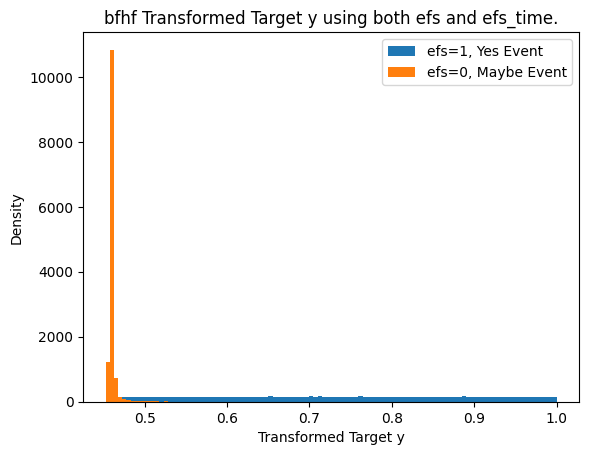

In [67]:
from lifelines import BreslowFlemingHarringtonFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    bfhf = BreslowFlemingHarringtonFitter()
    bfhf.fit(df[time_col], df[event_col])
    y = bfhf.survival_function_at_times(df[time_col]).values
    return y
train["y_bfhf"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

plt.hist(train.loc[train.efs==1,"y_bfhf"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_bfhf"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("bfhf Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [122]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_bfhf_rmse = np.zeros(len(train))
pred_xgb_bfhf_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )

    # model_xgb = XGBRegressor(
    #     device="cuda",
    #     max_depth=3,
    #     colsample_bytree=0.5,
    #     subsample=0.8,
    #     n_estimators=2000,
    #     learning_rate=0.02,
    #     enable_categorical=True,
    #     min_child_weight=80,
    #     #early_stopping_rounds=25,
    # )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_bfhf_rmse[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_bfhf_rmse += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_bfhf_rmse /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17773
[500]	validation_0-rmse:0.15757
[1000]	validation_0-rmse:0.15629
[1500]	validation_0-rmse:0.15575
[1999]	validation_0-rmse:0.15569
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17351
[500]	validation_0-rmse:0.15434
[1000]	validation_0-rmse:0.15320
[1500]	validation_0-rmse:0.15285
[1999]	validation_0-rmse:0.15268
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17724
[500]	validation_0-rmse:0.15610
[1000]	validation_0-rmse:0.15473
[1500]	validation_0-rmse:0.15443
[1999]	validation_0-rmse:0.15425
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17922
[500]	validation_0-rmse:0.15829
[1000]	validation_0-rmse:0.15683
[1500]	validation_0-rmse:0.15637
[1999]	validation_0-rmse:0.15632
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17367
[500]	valid

In [123]:
# 0.6745

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_bfhf_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_xgb_bfhf_rmse.pkl', 'wb') as f:
    pickle.dump(oof_xgb_bfhf_rmse, f)
with open(r'gbdt-models\oof_xgb_bfhf_rmse.pkl', 'rb') as f:
    oof_xgb_bfhf_rmse = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost BFHF RMSE = 0.6738312312823979


In [124]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_bfhf_rmse_skf = np.zeros(len(train))
pred_xgb_bfhf_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )

    # model_xgb = XGBRegressor(
    #     device="cuda",
    #     max_depth=3,
    #     colsample_bytree=0.5,
    #     subsample=0.8,
    #     n_estimators=2000,
    #     learning_rate=0.02,
    #     enable_categorical=True,
    #     min_child_weight=80,
    #     #early_stopping_rounds=25,
    # )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_bfhf_rmse_skf[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_bfhf_rmse_skf += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_bfhf_rmse_skf /= FOLDS


#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17642
[500]	validation_0-rmse:0.15762
[1000]	validation_0-rmse:0.15627
[1500]	validation_0-rmse:0.15578
[1999]	validation_0-rmse:0.15565
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17328
[500]	validation_0-rmse:0.15560
[1000]	validation_0-rmse:0.15449
[1500]	validation_0-rmse:0.15420
[1999]	validation_0-rmse:0.15419
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17507
[500]	validation_0-rmse:0.15532
[1000]	validation_0-rmse:0.15403
[1500]	validation_0-rmse:0.15354
[1999]	validation_0-rmse:0.15345
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17821
[500]	validation_0-rmse:0.15797
[1000]	validation_0-rmse:0.15649
[1500]	validation_0-rmse:0.15585
[1999]	validation_0-rmse:0.15547
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17429
[500]	valid

In [125]:
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_bfhf_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_xgb_bfhf_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_xgb_bfhf_rmse_skf, f)
with open(r'gbdt-models\oof_xgb_bfhf_rmse_skf.pkl', 'rb') as f:
    oof_xgb_bfhf_rmse_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost BFHF RMSE = 0.6743607351009834


In [126]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb_bfhf_rmse_skf_dri = np.zeros(len(train))
pred_xgb_bfhf_rmse_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=4,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.025,
        enable_categorical=True,
        min_child_weight=100,
        #early_stopping_rounds=25,
    )

    # model_xgb = XGBRegressor(
    #     device="cuda",
    #     max_depth=3,
    #     colsample_bytree=0.5,
    #     subsample=0.8,
    #     n_estimators=2000,
    #     learning_rate=0.02,
    #     enable_categorical=True,
    #     min_child_weight=80,
    #     #early_stopping_rounds=25,
    # )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb_bfhf_rmse_skf_dri[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb_bfhf_rmse_skf_dri += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_bfhf_rmse_skf_dri /= FOLDS



#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[0]	validation_0-rmse:0.17687
[500]	validation_0-rmse:0.15928
[1000]	validation_0-rmse:0.15847
[1500]	validation_0-rmse:0.15822
[1999]	validation_0-rmse:0.15824
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17537
[500]	validation_0-rmse:0.15558
[1000]	validation_0-rmse:0.15431
[1500]	validation_0-rmse:0.15393
[1999]	validation_0-rmse:0.15382
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17662
[500]	validation_0-rmse:0.15569
[1000]	validation_0-rmse:0.15394
[1500]	validation_0-rmse:0.15353
[1999]	validation_0-rmse:0.15327
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17864
[500]	validation_0-rmse:0.15951
[1000]	validation_0-rmse:0.15830
[1500]	validation_0-rmse:0.15770
[1999]	validation_0-rmse:0.15734
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17699
[500]	validation_0-rmse:0.15967
[1000]	validation_0-rmse:0.15858
[1500]	va

In [127]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_bfhf_rmse_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_xgb_bfhf_rmse_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_xgb_bfhf_rmse_skf_dri, f)
with open(r'gbdt-models\oof_xgb_bfhf_rmse_skf_dri.pkl', 'rb') as f:
    oof_xgb_bfhf_rmse_skf_dri = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost BFHF RMSE = 0.6743244767576209


# CATBOOST WITH BFHF

In [128]:

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_bfhf_rmse = np.zeros(len(train))
pred_cat_bfhf_rmse = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.05,
        grow_policy='Lossguide',
        objective="RMSE",
        l2_leaf_reg=200,
        iterations=2000,
        bootstrap_type='Bernoulli'
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_bfhf_rmse[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_bfhf_rmse += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_bfhf_rmse /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1756098	test: 0.1772064	best: 0.1772064 (0)	total: 24.4ms	remaining: 48.8s
250:	learn: 0.1505071	test: 0.1586091	best: 0.1586091 (250)	total: 4.22s	remaining: 29.4s
500:	learn: 0.1466688	test: 0.1574350	best: 0.1574285 (498)	total: 8.31s	remaining: 24.9s
750:	learn: 0.1444850	test: 0.1568915	best: 0.1568906 (749)	total: 12.4s	remaining: 20.7s
1000:	learn: 0.1423950	test: 0.1566445	best: 0.1566441 (997)	total: 16.6s	remaining: 16.5s
1250:	learn: 0.1408816	test: 0.1564840	best: 0.1564736 (1242)	total: 20.8s	remaining: 12.4s
1500:	learn: 0.1394341	test: 0.1564591	best: 0.1564554 (1301)	total: 25s	remaining: 8.3s
1750:	learn: 0.1377394	test: 0.1563374	best: 0.1563302 (1733)	total: 29s	remaining: 4.12s
1999:	learn: 0.1360069	test: 0.1562916	best: 0.1562648 (1951)	total: 33.3s	remaining: 0us
bestTest = 0.1562647834
bestIteration = 1951
Shrink model to first 1952 iterations.
#########################
### Fold 2
#######

In [129]:
# 0.6732
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_bfhf_rmse
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_cat_bfhf_rmse.pkl', 'wb') as f:
    pickle.dump(oof_cat_bfhf_rmse, f)
with open(r'gbdt-models\oof_cat_bfhf_rmse.pkl', 'rb') as f:
    oof_cat_bfhf_rmse = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost BFHF RMSE = 0.6729847536437481


In [73]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_bfhf_rmse_skf = np.zeros(len(train))
pred_cat_bfhf_rmse_skf = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)
    # Save the model for this fold to the specified directory
    model_filename = os.path.join(catboost_dir, f"cat_bfhf_rmse_skf_fold_{i+1}.cbm")
    model_cat.save_model(model_filename)
    print(f"Model for fold {i+1} saved as {model_filename}")

    # INFER OOF
    oof_cat_bfhf_rmse_skf[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_bfhf_rmse_skf += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_bfhf_rmse_skf /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1744563	test: 0.1748096	best: 0.1748096 (0)	total: 18.4ms	remaining: 18.4s
250:	learn: 0.1421676	test: 0.1573556	best: 0.1573333 (193)	total: 3.36s	remaining: 10s
500:	learn: 0.1335111	test: 0.1568778	best: 0.1566531 (465)	total: 6.79s	remaining: 6.76s
750:	learn: 0.1261802	test: 0.1567680	best: 0.1565328 (649)	total: 14.3s	remaining: 4.73s
999:	learn: 0.1198873	test: 0.1568795	best: 0.1565328 (649)	total: 20.1s	remaining: 0us
bestTest = 0.1565327862
bestIteration = 649
Shrink model to first 650 iterations.
Model for fold 1 saved as catboost_models\cat_bfhf_rmse_skf_fold_1.cbm
#########################
### Fold 2
#########################
0:	learn: 0.1748210	test: 0.1715347	best: 0.1715347 (0)	total: 17ms	remaining: 17s
250:	learn: 0.1413288	test: 0.1546900	best: 0.1545969 (222)	total: 3.89s	remaining: 11.6s
500:	learn: 0.1319018	test: 0.1544166	best: 0.1541817 (422)	total: 8.37s	remaining: 8.33s
750:	learn: 0.1

In [75]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_bfhf_rmse_skf
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_cat_bfhf_rmse_skf.pkl', 'wb') as f:
    pickle.dump(oof_cat_bfhf_rmse_skf, f)
with open(r'gbdt-models\oof_cat_bfhf_rmse_skf.pkl', 'rb') as f:
    oof_cat_bfhf_rmse_skf = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost BFHF RMSE = 0.6739923188751561


In [132]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_bfhf_rmse_skf_dri = np.zeros(len(train))
pred_cat_bfhf_rmse_skf_dri = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Lossguide',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_bfhf_rmse_skf_dri[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_bfhf_rmse_skf_dri += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_bfhf_rmse_skf_dri /= FOLDS

#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: 0.1744386	test: 0.1751907	best: 0.1751907 (0)	total: 14.9ms	remaining: 14.9s
250:	learn: 0.1420826	test: 0.1589297	best: 0.1588775 (244)	total: 3.54s	remaining: 10.6s
500:	learn: 0.1332472	test: 0.1589031	best: 0.1586914 (378)	total: 7.33s	remaining: 7.3s
750:	learn: 0.1263090	test: 0.1589297	best: 0.1586914 (378)	total: 11.2s	remaining: 3.7s
999:	learn: 0.1201706	test: 0.1588346	best: 0.1586914 (378)	total: 15.6s	remaining: 0us
bestTest = 0.1586914229
bestIteration = 378
Shrink model to first 379 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1745849	test: 0.1736427	best: 0.1736427 (0)	total: 17.2ms	remaining: 17.1s
250:	learn: 0.1420292	test: 0.1550804	best: 0.1550804 (250)	total: 3.54s	remaining: 10.6s
500:	learn: 0.1333572	test: 0.1548443	best: 0.1548378 (486)	total: 9.14s	remaining: 9.11s
750:	learn: 0.1261658	test: 0.1552098	best: 0.1547953 (553)	total: 14.5s	remaining: 4.81s
999:	learn: 0.1197739	test: 0.1555925	best: 0.1547953 (

In [133]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_bfhf_rmse_skf_dri
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_cat_bfhf_rmse_skf_dri.pkl', 'wb') as f:
    pickle.dump(oof_cat_bfhf_rmse_skf_dri, f)
with open(r'gbdt-models\oof_cat_bfhf_rmse_skf_dri.pkl', 'rb') as f:
    oof_cat_bfhf_rmse_skf_dri = pickle.load(f)




C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost BFHF RMSE = 0.6718711658877086


In [134]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_bfhf_rmse_2 = np.zeros(len(train))
pred_cat_bfhf_rmse_2 = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",

        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_bfhf_rmse_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_bfhf_rmse_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_bfhf_rmse_2 /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1742466	test: 0.1759677	best: 0.1759677 (0)	total: 11.9ms	remaining: 11.9s
250:	learn: 0.1373321	test: 0.1576469	best: 0.1576469 (250)	total: 2.61s	remaining: 7.78s
500:	learn: 0.1261654	test: 0.1573980	best: 0.1573932 (489)	total: 5.15s	remaining: 5.13s
750:	learn: 0.1168545	test: 0.1574848	best: 0.1572977 (587)	total: 7.72s	remaining: 2.56s
999:	learn: 0.1086275	test: 0.1573717	best: 0.1572677 (902)	total: 10.6s	remaining: 0us
bestTest = 0.1572676685
bestIteration = 902
Shrink model to first 903 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1746694	test: 0.1717464	best: 0.1717464 (0)	total: 10.9ms	remaining: 10.9s
250:	learn: 0.1388923	test: 0.1530308	best: 0.1530246 (249)	total: 2.45s	remaining: 7.32s
500:	learn: 0.1274070	test: 0.1530425	best: 0.1529565 (286)	total: 4.91s	remaining: 4.89s
750:	learn: 0.1176758	test: 0.1532199	best: 0.1528583 (593)	total: 7.35s	remaini

In [135]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_bfhf_rmse_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_cat_bfhf_rmse_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_bfhf_rmse_2, f)
with open(r'gbdt-models\oof_cat_bfhf_rmse_2.pkl', 'rb') as f:
    oof_cat_bfhf_rmse_2 = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost BFHF RMSE = 0.6703776557380512


In [76]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_bfhf_rmse_skf_2 = np.zeros(len(train))
pred_cat_bfhf_rmse_skf_2 = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["efs"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)
    
    model_filename = os.path.join(catboost_dir, f"cat_bfhf_rmse_skf_2_fold_{i+1}.cbm")
    model_cat.save_model(model_filename)
    print(f"Model for fold {i+1} saved as {model_filename}")

    # INFER OOF
    oof_cat_bfhf_rmse_skf_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_bfhf_rmse_skf_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_bfhf_rmse_skf_2 /= FOLDS


#########################
### Fold 1
#########################
0:	learn: 0.1743553	test: 0.1747908	best: 0.1747908 (0)	total: 13.3ms	remaining: 13.2s
250:	learn: 0.1386553	test: 0.1566824	best: 0.1566211 (221)	total: 2.62s	remaining: 7.81s
500:	learn: 0.1281147	test: 0.1567745	best: 0.1563205 (404)	total: 4.96s	remaining: 4.93s
750:	learn: 0.1190672	test: 0.1571808	best: 0.1563205 (404)	total: 7.52s	remaining: 2.49s
999:	learn: 0.1106336	test: 0.1573479	best: 0.1563205 (404)	total: 10.2s	remaining: 0us
bestTest = 0.1563205475
bestIteration = 404
Shrink model to first 405 iterations.
Model for fold 1 saved as catboost_models\cat_bfhf_rmse_skf_2_fold_1.cbm
#########################
### Fold 2
#########################
0:	learn: 0.1747287	test: 0.1715031	best: 0.1715031 (0)	total: 13.4ms	remaining: 13.4s
250:	learn: 0.1374883	test: 0.1547152	best: 0.1546013 (223)	total: 2.27s	remaining: 6.76s
500:	learn: 0.1263383	test: 0.1549544	best: 0.1545583 (361)	total: 4.53s	remaining: 4.51s
750:	le

In [78]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_bfhf_rmse_skf_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_cat_bfhf_rmse_skf_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_bfhf_rmse_skf_2, f)
with open(r'gbdt-models\oof_cat_bfhf_rmse_skf_2.pkl', 'rb') as f:
    oof_cat_bfhf_rmse_skf_2 = pickle.load(f)



C:\Users\Admin\AppData\Local\Temp\ipykernel_8424\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost BFHF RMSE = 0.6727617812803904


In [138]:
%%time
FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat_bfhf_rmse_skf_dri_2 = np.zeros(len(train))
pred_cat_bfhf_rmse_skf_dri_2 = np.zeros(len(test))

stratify_labels = train["race_group"].astype(str) + "_" + train["dri_score"].astype(str)

for i, (train_index, test_index) in enumerate(skf.split(train, stratify_labels)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_bfhf"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_bfhf"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",
        learning_rate=0.1,
        grow_policy='Depthwise',
        objective="RMSE",
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat_bfhf_rmse_skf_dri_2[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat_bfhf_rmse_skf_dri_2 += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_bfhf_rmse_skf_dri_2 /= FOLDS

#########################
### Fold 1
#########################


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0:	learn: 0.1743153	test: 0.1751616	best: 0.1751616 (0)	total: 13.9ms	remaining: 13.9s
250:	learn: 0.1381729	test: 0.1594624	best: 0.1594138 (245)	total: 3.51s	remaining: 10.5s
500:	learn: 0.1271793	test: 0.1595033	best: 0.1593263 (421)	total: 7.41s	remaining: 7.38s
750:	learn: 0.1179419	test: 0.1598935	best: 0.1593263 (421)	total: 11s	remaining: 3.64s
999:	learn: 0.1101433	test: 0.1601388	best: 0.1593263 (421)	total: 14.2s	remaining: 0us
bestTest = 0.1593262708
bestIteration = 421
Shrink model to first 422 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1745015	test: 0.1736620	best: 0.1736620 (0)	total: 11.7ms	remaining: 11.7s
250:	learn: 0.1383268	test: 0.1553886	best: 0.1553755 (225)	total: 3.13s	remaining: 9.36s
500:	learn: 0.1275601	test: 0.1553948	best: 0.1551970 (330)	total: 6.92s	remaining: 6.89s
750:	learn: 0.1183383	test: 0.1558029	best: 0.1551970 (330)	total: 10.3s	remaining: 3.42s
999:	learn: 0.1100829	test: 0.1560892	best: 0.1551970 (

In [139]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_bfhf_rmse_skf_dri_2
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost BFHF RMSE =",m)

with open(r'gbdt-models\oof_cat_bfhf_rmse_skf_dri_2.pkl', 'wb') as f:
    pickle.dump(oof_cat_bfhf_rmse_skf_dri_2, f)
with open(r'gbdt-models\oof_cat_bfhf_rmse_skf_dri_2.pkl', 'rb') as f:
    oof_cat_bfhf_rmse_skf_dri_2 = pickle.load(f)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7440\2685751116.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost BFHF RMSE = 0.6709422019221764


# ENSEMBLE

In [ ]:
# 0.6823

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb_km_rmse) + rankdata(oof_cat_km_rmse) + rankdata(oof_cat_naf) + rankdata(oof_cat_quantile_rmse)\
                        + rankdata(oof_xgb_quantile_rmse)\
                     + rankdata(oof_xgb_quantile_mae) + rankdata(oof_xgb_naf_rmse) + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)\
                    + rankdata(oof_cat_aft) + rankdata(oof_xgb_ph_rmse)\
                     + rankdata(oof_cat_quantile_rmse_2) + rankdata(oof_cat_km_rmse_2) + rankdata(oof_cat_cox_2)

m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

<ipython-input-8-aea0c4d0cc49>:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6823033996077411


# NN PART

In [7]:
!pip download -q lightning pytorch-tabular



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install -q /content/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install -q /content/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /content/torchmetrics-1.5.2-py3-none-any.whl
!pip install -q /content/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install -q /content/einops-0.7.0-py3-none-any.whl
!pip install -q /content/pytorch_tabular-1.1.1-py2.py3-none-any.whl

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\content\\pytorch_lightning-2.4.0-py3-none-any.whl'


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl is not a supported wheel on this platform.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\content\\torchmetrics-1.5.2-py3-none-any.whl'


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\content\\pytorch_tabnet-4.1.0-py3-none-any.whl'


[notice] A new release of pip is available: 24.0 -> 25.0.1
[not

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset


def get_X_cat(df, cat_cols, transformers=None):
    """
    Apply a specific categorical data transformer or a LabelEncoder if None.
    """
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T


def preprocess_data(train, val):
    """
    Standardize numerical variables and transform (Label-encode) categoricals.
    Fill NA values with mean for numerical.
    Create torch dataloaders to prepare data for training and evaluation.
    """
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


def get_categoricals(train, val):
    """
    Remove constant categorical columns and transform them using LabelEncoder.
    Return the label-transformers for each categorical column, categorical dataframes and numerical columns.
    """
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers


def init_dl(X_cat, X_num, df, training=False):
    """
    Initialize data loaders with 4 dimensions : categorical dataframe, numerical dataframe and target values (efs and efs_time).
    Notice that efs_time is log-transformed.
    Fix batch size to 2048 and return dataloader for training or validation depending on training value.
    """
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
    bs = 2048
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train


def get_feature_types(train):
    """
    Utility function to return categorical and numerical column names.
    """
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical


def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    df['year_hct'] -= 2000

    return df


def load_data():
    """
    Load data and add features.
    """
    test = pd.read_csv(r"data\cibmtr\test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv(r"data\cibmtr\train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train

In [ ]:
import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm


class CatEmbeddings(nn.Module):
    """
    Embedding module for the categorical dataframe.
    """
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        """
        projection_dim: The dimension of the final output after projecting the concatenated embeddings into a lower-dimensional space.
        categorical_cardinality: A list where each element represents the number of unique categories (cardinality) in each categorical feature.
        embedding_dim: The size of the embedding space for each categorical feature.
        self.embeddings: list of embedding layers for each categorical feature.
        self.projection: sequential neural network that goes from the embedding to the output projection dimension with GELU activation.
        """
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        """
        Apply the projection on concatened embeddings that contains all categorical features.
        """
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    """
    Train a model on both categorical embeddings and numerical data.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        """
        continuous_dim: The number of continuous features.
        categorical_cardinality: A list of integers representing the number of unique categories in each categorical feature.
        embedding_dim: The dimensionality of the embedding space for each categorical feature.
        projection_dim: The size of the projected output space for the categorical embeddings.
        hidden_dim: The number of neurons in the hidden layer of the MLP.
        dropout: The dropout rate applied in the network.
        self.embeddings: previous embeddings for categorical data.
        self.mlp: defines an MLP model with an ODST layer followed by batch normalization and dropout.
        self.out: linear output layer that maps the output of the MLP to a single value
        self.dropout: defines dropout
        Weights initialization with xavier normal algorithm and biases with zeros.
        """
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        """
        Create embedding layers for categorical data, concatenate with continous variables.
        Add dropout and goes through MLP and return raw output and 1-dimensional output as well.
        """
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x


@functools.lru_cache
def combinations(N):
    """
    calculates all possible 2-combinations (pairs) of a tensor of indices from 0 to N-1,
    and caches the result using functools.lru_cache for optimization
    """
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()


class LitNN(pl.LightningModule):
    """
    Main Model creation and losses definition to fully train the model.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        """
        continuous_dim: The number of continuous input features.
        categorical_cardinality: A list of integers, where each element corresponds to the number of unique categories for each categorical feature.
        embedding_dim: The dimension of the embeddings for the categorical features.
        projection_dim: The dimension of the projected space after embedding concatenation.
        hidden_dim: The size of the hidden layers in the feedforward network (MLP).
        lr: The learning rate for the optimizer.
        dropout: Dropout probability to avoid overfitting.
        weight_decay: The L2 regularization term for the optimizer.
        aux_weight: Weight used for auxiliary tasks.
        margin: Margin used in some loss functions.
        race_index: An index that refer to race_group in the input data.
        """
        super(LitNN, self).__init__()
        self.save_hyperparameters()

        # Creates an instance of the NN model defined above
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []

        # Defines a small feedforward neural network that performs an auxiliary task with 1-dimensional output
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )

    def on_before_optimizer_step(self, optimizer):
        """
        Compute the 2-norm for each layer
        If using mixed precision, the gradients are already unscaled here
        """
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        """
        Forward pass that outputs the 1-dimensional prediction and the embeddings (raw output)
        """
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        """
        defines how the model processes each batch of data during training.
        A batch is a combination of : categorical data, continuous data, efs_time (y) and efs event.
        y_hat is the efs_time prediction on all data and aux_pred is auxiliary prediction on embeddings.
        Calculates loss and race_group loss on full data.
        Auxiliary loss is calculated with an event mask, ignoring efs=0 predictions and taking the average.
        Returns loss and aux_loss multiplied by weight defined above.
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat):
        """
        Output loss and race_group loss.
        """
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        """
        Calculate loss for each race_group based on deviation/variance.
        """
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        """
        Most important part of the model : loss function used for training.
        We face survival data with event indicators along with time-to-event.

        This function computes the main loss by the following the steps :
        * create all data pairs with "combinations" function (= all "two subjects" combinations)
        * make sure that we have at least 1 event in each pair
        * convert y to +1 or -1 depending on the correct ranking
        * loss is computed using a margin-based hinge loss
        * mask is applied to ensure only valid pairs are being used (censored data can't be ranked with event in some cases)
        * average loss on all pairs is returned
        """
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        """
        Defines all invalid comparisons :
        * Case 1: "Left outlived Right" but Right is censored
        * Case 2: "Right outlived Left" but Left is censored
        Masks for case 1 and case 2 are combined using |= operator and inverted using ~ to create a "valid pair mask"
        """
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def validation_step(self, batch, batch_idx):
        """
        This method defines how the model processes each batch during validation
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        """
        At the end of the validation epoch, it computes and logs the concordance index
        """
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        """
        Calculate c-index accounting for each race_group or global.
        """
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    def _metric(self, efs, races, y, y_hat):
        """
        Calculate c-index accounting for each race_group
        """
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    def test_step(self, batch, batch_idx):
        """
        Same as training step but to log test data
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self) -> None:
        """
        At the end of the test epoch, calculates and logs the concordance index for the test set
        """
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()


    def configure_optimizers(self):
        """
        configures the optimizer and learning rate scheduler:
        * Optimizer: Adam optimizer with weight decay (L2 regularization).
        * Scheduler: Cosine Annealing scheduler, which adjusts the learning rate according to a cosine curve.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [ ]:
import json
import pytorch_lightning as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold

pl.seed_everything(42)

def main(hparams):
    """
    Main function to train the model.
    The steps are as following :
    * load data and fill efs and efs time for test data with 1
    * initialize pred array with 0
    * get categorical and numerical columns
    * split the train data on the stratified criterion : race_group * newborns yes/no
    * preprocess the fold data (create dataloaders)
    * train the model and create final submission output
    * SAVE OOF predictions as well
    """
    # 1) Load data
    test, train_original = load_data()
    test['efs_time'] = 1
    test['efs'] = 1

    # 2) Initialize arrays to store predictions
    test_pred = np.zeros(test.shape[0])  # For final test predictions
    oof_pred = np.zeros(train_original.shape[0])  # For OOF predictions

    # 3) Get feature columns
    categorical_cols, numerical = get_feature_types(train_original)

    # 4) Set up folds
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    stratify_col = train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str)

    for i, (train_index, val_index) in enumerate(kf.split(train_original, stratify_col)):
        print(f"\n=== Fold {i+1} / {kf.n_splits} ===")

        # Split the data
        tt = train_original.copy()
        train_df = tt.iloc[train_index]
        val_df = tt.iloc[val_index]

        # 5) Preprocess train/val
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train_df, val_df)

        # 6) Train the model on this fold
        model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)

        # 7) Inference on validation set => store OOF
        with torch.no_grad():
            val_preds, _ = model.cuda().eval()(
                torch.tensor(X_cat_val, dtype=torch.long).cuda(),
                torch.tensor(X_num_val, dtype=torch.float32).cuda()
            )
        # Place the predictions into our OOF array
        oof_pred[val_index] = val_preds.detach().cpu().numpy()

        # 8) Inference on test set => accumulate for final submission
        #    (We typically preprocess the test with the train_df from the same fold)
        X_cat_test, _, X_num_test, _, _, _ = preprocess_data(train_df, test)
        with torch.no_grad():
            fold_test_pred, _ = model.cuda().eval()(
                torch.tensor(X_cat_test, dtype=torch.long).cuda(),
                torch.tensor(X_num_test, dtype=torch.float32).cuda()
            )
        test_pred += fold_test_pred.detach().cpu().numpy()

    # 9) Average the test predictions across folds
    test_pred /= kf.n_splits

    # 10) Save final submission
    subm_data = pd.read_csv("/content/data/cibmtr/sample_submission.csv")
    subm_data['prediction'] = -test_pred
    subm_data.to_csv('submission.csv', index=False)
    display(subm_data.head())

    # 11) Optionally, save the OOF predictions
    # Attach oof_pred to the original train data or store in a separate CSV
    train_original["oof_pred"] = -oof_pred
    train_original.to_csv("oof_predictions.csv", index=False)

    return -test_pred, -oof_pred  # Return them if desired



def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    """
    Defines model hyperparameters and fit the model.
    """
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.06464861983337984,
            "dropout": 0.05463240181423116,
            "aux_weight": 0.26545778308743806,
            "margin": 0.2588153271003354,
            "weight_decay": 0.0002773544957610778
        }
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        save_top_k=1,
        mode='min'
    )
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=60,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()


hparams = None
test_pred_nn, oof_pred_nn = main(hparams)
print("done")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Test shape: (3, 59)
Train shape: (28800, 61)
There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['lr-Adam', 'train_loss', 'train_loss_step', 'grad_2.0_norm/embeddings.embeddings.0.weight', 'grad_2.0_norm/embeddings.embeddings.1.weight', 'grad_2.0_norm/embeddings.embeddings.2.weight', 'grad_2.0_norm/embeddings.embeddings.3.weight', 'grad_2.0_norm/embeddings.embeddings.4.weight', 'grad_2.0_norm/embeddings.embeddings.5.weight', 'grad_2.0_norm/embeddings.embeddings.6.weight', 'grad_2.0_norm/embeddings.embeddings.7.weight', 'grad_2.0_norm/embeddings.embeddings.8.weight', 'grad_2.0_norm/embeddings.embeddings.9.weight', 'grad_2.0_norm/embeddings.embeddings.10.weight', 'grad_2.0_norm/embeddings.embeddings.11.weight', 'grad_2.0_norm/embeddings.embeddings.12.weight', 'grad_2.0_norm/embeddings.embeddings.13.weight', 'grad_2.0_norm/embeddings.embeddings.14.weight', 'grad_2.0_norm/embeddings.embeddings.15.w

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6774613261222839     │
│    test_cindex_simple     │     0.691961944103241     │
│         test_loss         │    0.1821960078937616     │
└───────────────────────────┴───────────────────────────┘

There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'is_cyto_score_same']

=== Fold 2 / 5 ==

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 159 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
159 K     Trainable params
769       Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Swapping scheduler `CosineAnnealingLR` for `SWALR`
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=61` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │     0.676098644733429     │
│    test_cindex_simple     │    0.6855000853538513     │
│         test_loss         │    0.18503686837709823    │
└───────────────────────────┴───────────────────────────┘

There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'is_cyto_score_same']

=== Fold 3 / 5 ==

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 159 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
159 K     Trainable params
769       Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Swapping scheduler `CosineAnnealingLR` for `SWALR`
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=61` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6816598773002625     │
│    test_cindex_simple     │     0.691376805305481     │
│         test_loss         │    0.18330728821556594    │
└───────────────────────────┴───────────────────────────┘

There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'is_cyto_score_same']

=== Fold 4 / 5 ==

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 159 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
159 K     Trainable params
769       Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Swapping scheduler `CosineAnnealingLR` for `SWALR`
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=61` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6844000220298767     │
│    test_cindex_simple     │    0.6968127489089966     │
│         test_loss         │    0.1796522285223816     │
└───────────────────────────┴───────────────────────────┘

There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'is_cyto_score_same']

=== Fold 5 / 5 ==

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | NN         | 159 K  | train
1 | aux_cls | Sequential | 1.0 K  | train
-----------------------------------------------
159 K     Trainable params
769       Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Swapping scheduler `CosineAnnealingLR` for `SWALR`
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=61` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6733452677726746     │
│    test_cindex_simple     │    0.6804147958755493     │
│         test_loss         │    0.1891578939768247     │
└───────────────────────────┴───────────────────────────┘

There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'is_cyto_score_same']


,ID,prediction
0,28800,-0.445977
1,28801,0.029797
2,28802,-0.564200


done


In [ ]:
# 0.6820

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb_km_rmse) + rankdata(oof_cat_km_rmse) + rankdata(oof_cat_naf) + rankdata(oof_cat_quantile_rmse)\
                        + rankdata(oof_xgb_quantile_rmse) + rankdata(oof_xgb_quantile_mae) + rankdata(oof_xgb_naf_rmse) + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)\
                    + rankdata(oof_cat_aft) + rankdata(oof_xgb_ph_rmse) + rankdata(oof_cat_quantile_rmse_2) + rankdata(oof_cat_km_rmse_2) + rankdata(oof_cat_cox_2)\
                    + rankdata(oof_pred_nn)



m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

<ipython-input-8-aea0c4d0cc49>:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6831551569554924


# TABM FIRST MODEL

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip download hillclimbers -q
!pip download scikit-learn==1.4.0 -q
!pip download ydf -q
!pip download rtdl_num_embeddings -q
!pip download delu -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn==1.4.0 -q --no-index --find-links=/content/scikit_learn-1.4.0-1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install rtdl_num_embeddings -q --no-index --find-links=/content/rtdl_num_embeddings-0.0.11-py3-none-any.whl
!pip install delu -q --no-index --find-links=/content/delu-0.0.26-py3-none-any.whl

In [ ]:
# @title tabm_reference
# %% [code]
# License: https://github.com/yandex-research/tabm/blob/main/LICENSE

# NOTE
# The minimum required versions of the dependencies are specified in README.md.

import itertools
from typing import Any, Literal

import rtdl_num_embeddings
import torch
import torch.nn as nn
from torch import Tensor


# ======================================================================================
# Initialization
# ======================================================================================
def init_rsqrt_uniform_(x: Tensor, d: int) -> Tensor:
    assert d > 0
    d_rsqrt = d**-0.5
    return nn.init.uniform_(x, -d_rsqrt, d_rsqrt)


@torch.inference_mode()
def init_random_signs_(x: Tensor) -> Tensor:
    return x.bernoulli_(0.5).mul_(2).add_(-1)


# ======================================================================================
# Modules
# ======================================================================================
class NLinear(nn.Module):
    """N linear layers applied in parallel to N disjoint parts of the input.

    **Shape**

    - Input: ``(B, N, in_features)``
    - Output: ``(B, N, out_features)``

    The i-th linear layer is applied to the i-th matrix of the shape (B, in_features).

    Technically, this is a simplified version of delu.nn.NLinear:
    https://yura52.github.io/delu/stable/api/generated/delu.nn.NLinear.html.
    The difference is that this layer supports only 3D inputs
    with exactly one batch dimension. By contrast, delu.nn.NLinear supports
    any number of batch dimensions.
    """

    def __init__(
        self, n: int, in_features: int, out_features: int, bias: bool = True
    ) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n, in_features, out_features))
        self.bias = nn.Parameter(torch.empty(n, out_features)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        d = self.weight.shape[-2]
        init_rsqrt_uniform_(self.weight, d)
        if self.bias is not None:
            init_rsqrt_uniform_(self.bias, d)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        assert x.shape[-(self.weight.ndim - 1) :] == self.weight.shape[:-1]

        x = x.transpose(0, 1)
        x = x @ self.weight
        x = x.transpose(0, 1)
        if self.bias is not None:
            x = x + self.bias
        return x


class OneHotEncoding0d(nn.Module):
    # Input:  (*, n_cat_features=len(cardinalities))
    # Output: (*, sum(cardinalities))

    def __init__(self, cardinalities: list[int]) -> None:
        super().__init__()
        self._cardinalities = cardinalities

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim >= 1
        assert x.shape[-1] == len(self._cardinalities)

        return torch.cat(
            [
                # NOTE
                # This is a quick hack to support out-of-vocabulary categories.
                #
                # Recall that lib.data.transform_cat encodes categorical features
                # as follows:
                # - In-vocabulary values receive indices from `range(cardinality)`.
                # - All out-of-vocabulary values (i.e. new categories in validation
                #   and test data that are not presented in the training data)
                #   receive the index `cardinality`.
                #
                # As such, the line below will produce the standard one-hot encoding for
                # known categories, and the all-zeros encoding for unknown categories.
                # This may not be the best approach to deal with unknown values,
                # but should be enough for our purposes.
                nn.functional.one_hot(x[..., i], cardinality + 1)[..., :-1]
                for i, cardinality in enumerate(self._cardinalities)
            ],
            -1,
        )


class ScaleEnsemble(nn.Module):
    def __init__(
        self,
        k: int,
        d: int,
        *,
        init: Literal['ones', 'normal', 'random-signs'],
    ) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.empty(k, d))
        self._weight_init = init
        self.reset_parameters()

    def reset_parameters(self) -> None:
        if self._weight_init == 'ones':
            nn.init.ones_(self.weight)
        elif self._weight_init == 'normal':
            nn.init.normal_(self.weight)
        elif self._weight_init == 'random-signs':
            init_random_signs_(self.weight)
        else:
            raise ValueError(f'Unknown weight_init: {self._weight_init}')

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim >= 2
        return x * self.weight


class LinearEfficientEnsemble(nn.Module):
    """
    This layer is a more configurable version of the "BatchEnsemble" layer
    from the paper
    "BatchEnsemble: An Alternative Approach to Efficient Ensemble and Lifelong Learning"
    (link: https://arxiv.org/abs/2002.06715).

    First, this layer allows to select only some of the "ensembled" parts:
    - the input scaling  (r_i in the BatchEnsemble paper)
    - the output scaling (s_i in the BatchEnsemble paper)
    - the output bias    (not mentioned in the BatchEnsemble paper,
                          but is presented in public implementations)

    Second, the initialization of the scaling weights is configurable
    through the `scaling_init` argument.

    NOTE
    The term "adapter" is used in the TabM paper only to tell the story.
    The original BatchEnsemble paper does NOT use this term. So this class also
    avoids the term "adapter".
    """

    r: None | Tensor
    s: None | Tensor
    bias: None | Tensor

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        *,
        k: int,
        ensemble_scaling_in: bool,
        ensemble_scaling_out: bool,
        ensemble_bias: bool,
        scaling_init: Literal['ones', 'random-signs'],
    ):
        assert k > 0
        if ensemble_bias:
            assert bias
        super().__init__()

        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.register_parameter(
            'r',
            (
                nn.Parameter(torch.empty(k, in_features))
                if ensemble_scaling_in
                else None
            ),  # type: ignore[code]
        )
        self.register_parameter(
            's',
            (
                nn.Parameter(torch.empty(k, out_features))
                if ensemble_scaling_out
                else None
            ),  # type: ignore[code]
        )
        self.register_parameter(
            'bias',
            (
                nn.Parameter(torch.empty(out_features))  # type: ignore[code]
                if bias and not ensemble_bias
                else nn.Parameter(torch.empty(k, out_features))
                if ensemble_bias
                else None
            ),
        )

        self.in_features = in_features
        self.out_features = out_features
        self.k = k
        self.scaling_init = scaling_init

        self.reset_parameters()

    def reset_parameters(self):
        init_rsqrt_uniform_(self.weight, self.in_features)
        scaling_init_fn = {'ones': nn.init.ones_, 'random-signs': init_random_signs_}[
            self.scaling_init
        ]
        if self.r is not None:
            scaling_init_fn(self.r)
        if self.s is not None:
            scaling_init_fn(self.s)
        if self.bias is not None:
            bias_init = torch.empty(
                # NOTE: the shape of bias_init is (out_features,) not (k, out_features).
                # It means that all biases have the same initialization.
                # This is similar to having one shared bias plus
                # k zero-initialized non-shared biases.
                self.out_features,
                dtype=self.weight.dtype,
                device=self.weight.device,
            )
            bias_init = init_rsqrt_uniform_(bias_init, self.in_features)
            with torch.inference_mode():
                self.bias.copy_(bias_init)

    def forward(self, x: Tensor) -> Tensor:
        # x.shape == (B, K, D)
        assert x.ndim == 3

        # >>> The equation (5) from the BatchEnsemble paper (arXiv v2).
        if self.r is not None:
            x = x * self.r
        x = x @ self.weight.T
        if self.s is not None:
            x = x * self.s
        # <<<

        if self.bias is not None:
            x = x + self.bias
        return x


class MLP(nn.Module):
    def __init__(
        self,
        *,
        d_in: None | int = None,
        d_out: None | int = None,
        n_blocks: int,
        d_block: int,
        dropout: float,
        activation: str = 'ReLU',
    ) -> None:
        super().__init__()

        d_first = d_block if d_in is None else d_in
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(d_first if i == 0 else d_block, d_block),
                    getattr(nn, activation)(),
                    nn.Dropout(dropout),
                )
                for i in range(n_blocks)
            ]
        )
        self.output = None if d_out is None else nn.Linear(d_block, d_out)

    def forward(self, x: Tensor) -> Tensor:
        for block in self.blocks:
            x = block(x)
        if self.output is not None:
            x = self.output(x)
        return x


def make_efficient_ensemble(module: nn.Module, **kwargs) -> None:
    """Replace torch.nn.Linear modules with LinearEfficientEnsemble.

    NOTE
    In the paper, there are no experiments with networks with normalization layers.
    Perhaps, their trainable weights (the affine transformations) also need
    "ensemblification" as in the paper about "FiLM-Ensemble".
    Additional experiments are required to make conclusions.
    """
    for name, submodule in list(module.named_children()):
        if isinstance(submodule, nn.Linear):
            module.add_module(
                name,
                LinearEfficientEnsemble(
                    in_features=submodule.in_features,
                    out_features=submodule.out_features,
                    bias=submodule.bias is not None,
                    **kwargs,
                ),
            )
        else:
            make_efficient_ensemble(submodule, **kwargs)


def _get_first_ensemble_layer(backbone: MLP) -> LinearEfficientEnsemble:
    if isinstance(backbone, MLP):
        return backbone.blocks[0][0]  # type: ignore[code]
    else:
        raise RuntimeError(f'Unsupported backbone: {backbone}')


@torch.inference_mode()
def _init_first_adapter(
    weight: Tensor,
    distribution: Literal['normal', 'random-signs'],
    init_sections: list[int],
) -> None:
    """Initialize the first adapter.

    NOTE
    The `init_sections` argument is a historical artifact that accidentally leaked
    from irrelevant experiments to the final models. Perhaps, the code related
    to `init_sections` can be simply removed, but this was not tested.
    """
    assert weight.ndim == 2
    assert weight.shape[1] == sum(init_sections)

    if distribution == 'normal':
        init_fn_ = nn.init.normal_
    elif distribution == 'random-signs':
        init_fn_ = init_random_signs_
    else:
        raise ValueError(f'Unknown distribution: {distribution}')

    section_bounds = [0, *torch.tensor(init_sections).cumsum(0).tolist()]
    for i in range(len(init_sections)):
        # NOTE
        # As noted above, this section-based initialization is an arbitrary historical
        # artifact. Consider the first adapter of one ensemble member.
        # This adapter vector is implicitly split into "sections",
        # where one section corresponds to one feature. The code below ensures that
        # the adapter weights in one section are initialized with the same random value
        # from the given distribution.
        w = torch.empty((len(weight), 1), dtype=weight.dtype, device=weight.device)
        init_fn_(w)
        weight[:, section_bounds[i] : section_bounds[i + 1]] = w


_CUSTOM_MODULES = {
    # https://docs.python.org/3/library/stdtypes.html#definition.__name__
    CustomModule.__name__: CustomModule
    for CustomModule in [
        rtdl_num_embeddings.LinearEmbeddings,
        rtdl_num_embeddings.LinearReLUEmbeddings,
        rtdl_num_embeddings.PeriodicEmbeddings,
        rtdl_num_embeddings.PiecewiseLinearEmbeddings,
        MLP,
    ]
}


def make_module(type: str, *args, **kwargs) -> nn.Module:
    Module = getattr(nn, type, None)
    if Module is None:
        Module = _CUSTOM_MODULES[type]
    return Module(*args, **kwargs)


# ======================================================================================
# Optimization
# ======================================================================================
def default_zero_weight_decay_condition(
    module_name: str, module: nn.Module, parameter_name: str, parameter: nn.Parameter
):
    from rtdl_num_embeddings import _Periodic

    del module_name, parameter
    return parameter_name.endswith('bias') or isinstance(
        module,
        nn.BatchNorm1d
        | nn.LayerNorm
        | nn.InstanceNorm1d
        | rtdl_num_embeddings.LinearEmbeddings
        | rtdl_num_embeddings.LinearReLUEmbeddings
        | _Periodic,
    )


def make_parameter_groups(
    module: nn.Module,
    zero_weight_decay_condition=default_zero_weight_decay_condition,
    custom_groups: None | list[dict[str, Any]] = None,
) -> list[dict[str, Any]]:
    if custom_groups is None:
        custom_groups = []
    custom_params = frozenset(
        itertools.chain.from_iterable(group['params'] for group in custom_groups)
    )
    assert len(custom_params) == sum(
        len(group['params']) for group in custom_groups
    ), 'Parameters in custom_groups must not intersect'
    zero_wd_params = frozenset(
        p
        for mn, m in module.named_modules()
        for pn, p in m.named_parameters()
        if p not in custom_params and zero_weight_decay_condition(mn, m, pn, p)
    )
    default_group = {
        'params': [
            p
            for p in module.parameters()
            if p not in custom_params and p not in zero_wd_params
        ]
    }
    return [
        default_group,
        {'params': list(zero_wd_params), 'weight_decay': 0.0},
        *custom_groups,
    ]


# ======================================================================================
# The model
# ======================================================================================
class Model(nn.Module):
    """MLP & TabM."""

    def __init__(
        self,
        *,
        n_num_features: int,
        cat_cardinalities: list[int],
        n_classes: None | int,
        backbone: dict,
        bins: None | list[Tensor],  # For piecewise-linear encoding/embeddings.
        num_embeddings: None | dict = None,
        arch_type: Literal[
            # Plain feed-forward network without any kind of ensembling.
            'plain',
            #
            # TabM-mini
            'tabm-mini',
            #
            # TabM-mini. The first adapter is initialized from the normal distribution.
            # This is used in Section 5.1 of the paper.
            'tabm-mini-normal',
            #
            # TabM
            'tabm',
            #
            # TabM. The first adapter is initialized from the normal distribution.
            # This variation is not used in the paper, but there is a preliminary
            # evidence that may be a better default strategy.
            'tabm-normal',
        ],
        k: None | int = None,
    ) -> None:
        # >>> Validate arguments.
        assert n_num_features >= 0
        assert n_num_features or cat_cardinalities
        if arch_type == 'plain':
            assert k is None
        else:
            assert k is not None
            assert k > 0

        super().__init__()

        # >>> Continuous (numerical) features
        first_adapter_sections = []  # See the comment in `_init_first_adapter`.

        if n_num_features == 0:
            assert bins is None
            self.num_module = None
            d_num = 0

        elif num_embeddings is None:
            assert bins is None
            self.num_module = None
            d_num = n_num_features
            first_adapter_sections.extend(1 for _ in range(n_num_features))

        else:
            if bins is None:
                self.num_module = make_module(
                    **num_embeddings, n_features=n_num_features
                )
            else:
                assert num_embeddings['type'].startswith('PiecewiseLinearEmbeddings')
                self.num_module = make_module(**num_embeddings, bins=bins)
            d_num = n_num_features * num_embeddings['d_embedding']
            first_adapter_sections.extend(
                num_embeddings['d_embedding'] for _ in range(n_num_features)
            )

        # >>> Categorical features
        self.cat_module = (
            OneHotEncoding0d(cat_cardinalities) if cat_cardinalities else None
        )
        first_adapter_sections.extend(cat_cardinalities)
        d_cat = sum(cat_cardinalities)

        # >>> Backbone
        d_flat = d_num + d_cat
        self.minimal_ensemble_adapter = None
        # Any backbone can be here but we provide only MLP
        self.backbone = make_module(d_in=d_flat, **backbone)

        if arch_type != 'plain':
            assert k is not None
            first_adapter_init = (
                'normal'
                if arch_type in ('tabm-mini-normal', 'tabm-normal')
                # For other arch_types, the initialization depends
                # on the presense of num_embeddings.
                else 'random-signs'
                if num_embeddings is None
                else 'normal'
            )

            if arch_type in ('tabm-mini', 'tabm-mini-normal'):
                # Minimal ensemble
                self.minimal_ensemble_adapter = ScaleEnsemble(
                    k,
                    d_flat,
                    init='random-signs' if num_embeddings is None else 'normal',
                )
                _init_first_adapter(
                    self.minimal_ensemble_adapter.weight,  # type: ignore[code]
                    first_adapter_init,
                    first_adapter_sections,
                )

            elif arch_type in ('tabm', 'tabm-normal'):
                # Like BatchEnsemble, but all multiplicative adapters,
                # except for the very first one, are initialized with ones.
                make_efficient_ensemble(
                    self.backbone,
                    k=k,
                    ensemble_scaling_in=True,
                    ensemble_scaling_out=True,
                    ensemble_bias=True,
                    scaling_init='ones',
                )
                _init_first_adapter(
                    _get_first_ensemble_layer(self.backbone).r,  # type: ignore[code]
                    first_adapter_init,
                    first_adapter_sections,
                )

            else:
                raise ValueError(f'Unknown arch_type: {arch_type}')

        # >>> Output
        d_block = backbone['d_block']
        d_out = 1 if n_classes is None else n_classes
        self.output = (
            nn.Linear(d_block, d_out)
            if arch_type == 'plain'
            else NLinear(k, d_block, d_out)  # type: ignore[code]
        )

        # >>>
        self.arch_type = arch_type
        self.k = k

    def forward(
        self, x_num: None | Tensor = None, x_cat: None | Tensor = None
    ) -> Tensor:
        x = []
        if x_num is not None:
            x.append(x_num if self.num_module is None else self.num_module(x_num))
        if x_cat is None:
            assert self.cat_module is None
        else:
            assert self.cat_module is not None
            x.append(self.cat_module(x_cat).float())
        x = torch.column_stack([x_.flatten(1, -1) for x_ in x])

        if self.k is not None:
            x = x[:, None].expand(-1, self.k, -1)  # (B, D) -> (B, K, D)
            if self.minimal_ensemble_adapter is not None:
                x = self.minimal_ensemble_adapter(x)
        else:
            assert self.minimal_ensemble_adapter is None

        x = self.backbone(x)
        x = self.output(x)
        if self.k is None:
            # Adjust the output shape for plain networks to make them compatible
            # with the rest of the script (loss, metrics, predictions, ...).
            # (B, D_OUT) -> (B, 1, D_OUT)
            x = x[:, None]
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import rtdl_num_embeddings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, roc_auc_score, root_mean_squared_log_error, mean_squared_log_error

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

import joblib
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset

import delu
import math

from collections import OrderedDict
from tqdm import tqdm

In [ ]:
train = pd.read_csv(r'data\cibmtr\train.csv')
test = pd.read_csv(r'data\cibmtr\test.csv')

In [ ]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= 0.2

train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [ ]:
combined = pd.concat([train, test], axis=0)

RMV = ["ID","efs","efs_time", "label", "y", "efs_time2"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

CATS = []
for c in FEATURES:
    num_unique = combined[c].nunique()
    if num_unique < 100:
        CATS.append(c)
        train[c] = train[c].fillna(999)
        test[c] = test[c].fillna(999)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

NUMS = [c for c in FEATURES if not c in CATS]

combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")

    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")



cat_unique = combined[CATS].nunique().to_list()


for c in NUMS:
    combined[c] = combined[c].fillna(0)

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']
In these features, there are 55 CATEGORI

In [ ]:
cats_index = [train[FEATURES].columns.get_loc(cat) for cat in CATS]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[NUMS] = scaler.fit_transform(train[NUMS])
test[NUMS] = scaler.transform(test[NUMS])

folds = 5
train['kfold'] = -1

target = 'label'
kf = KFold(n_splits=5, random_state=42, shuffle=True)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(kf.split(X=train)):
    train.loc[val_idx, 'kfold'] = fold

oof_metric = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_metric['prediction'] = 0.0

oof_tabm = np.zeros(train.shape[0])
test_tabm = np.zeros((5, test.shape[0]))

X_num = train[NUMS].values
X_cat = train[CATS].values

X_num_test = test[NUMS].values
X_cat_test = test[CATS].values

y = train[target].values


test_dl = DataLoader(TensorDataset(torch.tensor(X_num_test, dtype=torch.float32), torch.tensor(X_cat_test, dtype=torch.int64)), batch_size=1024, shuffle=False)

n_cont_features = len(NUMS)
n_cat_features = len(CATS)
n_classes = None
cat_cardinalities = cat_unique

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TabM
# arch_type = 'tabm'
# bins = None

# TabM-mini with the piecewise-linear embeddings.
arch_type = 'tabm-mini'

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

loss_fn = RMSELoss()

In [ ]:
val_rmse_scores = []

val_cindex_scores = []
for i, (train_index, val_index) in enumerate(kf.split(train[FEATURES])):
    best = {
        "val": -math.inf,
        "epoch": -1,
    }
    ds_true = oof_metric.loc[oof_metric.kfold==i, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_metric.loc[oof_metric.kfold==i, ["ID"]].copy().reset_index(drop=True)

    X_num_train = X_num[train_index]
    X_cat_train = X_cat[train_index]
    y_train = y[train_index]

    X_num_val = X_num[val_index]
    X_cat_val = X_cat[val_index]
    y_val_all = y[val_index]

    train_dl = DataLoader(TensorDataset(torch.tensor(X_num_train, dtype=torch.float32), torch.tensor(X_cat_train, dtype=torch.int64),
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=32, shuffle=True)
    valid_dl = DataLoader(TensorDataset(torch.tensor(X_num_val, dtype=torch.float32), torch.tensor(X_cat_val, dtype=torch.int64),
                                        torch.tensor(y_val_all, dtype=torch.float32)), batch_size=32, shuffle=False)

    bins = rtdl_num_embeddings.compute_bins(torch.tensor(X_num_train, dtype=torch.float32))

    model = Model(
        n_num_features=n_cont_features,
        cat_cardinalities=cat_cardinalities,
        n_classes=n_classes,
        backbone={
            'type': 'MLP',
            'n_blocks': 3 ,
            'd_block': 512,
            'dropout': 0.1,
        },
        bins=bins,
        num_embeddings=(
            None
            if bins is None
            else {
                'type': 'PiecewiseLinearEmbeddings',
                'd_embedding': 64,
                'activation': True,
                'version': 'B',
            }
        ),
        arch_type=arch_type,
        k=32,
    ).to(device)

    optimizer = torch.optim.AdamW(
        # Instead of model.parameters(),
        make_parameter_groups(model),
        lr=1e-4,
        weight_decay=1e-3 ,
    )

    patience = 15
    early_stopping = delu.tools.EarlyStopping(patience, mode="max")

    for epoch in range(100):
        model.train()
        with tqdm(train_dl, total=len(train_dl), leave=True) as phar :
            for train_tensor in phar:
                optimizer.zero_grad()
                X_num_train, X_cat_train, y_train = [t.to(device) for t in train_tensor]

                output = model(X_num_train, X_cat_train).squeeze(-1)
                loss = loss_fn(output.flatten(0, 1), y_train.repeat_interleave(32))
                loss.backward()
                optimizer.step()

                phar.set_postfix(
                    OrderedDict(
                        epoch=f'{epoch+1}/{100}',
                        loss=f'{loss.item():.6f}'
                    )
                )
                phar.update(1)


        model.eval()
        valid_pred_list = []
        for valid_tensor in valid_dl:
            X_num_val, X_cat_val, y_val = [t.to(device) for t in valid_tensor]
            with torch.no_grad():
                output = model(X_num_val, X_cat_val).squeeze(-1)
            valid_pred_list.append((output.mean(1).cpu().numpy(), y_val.cpu().numpy()))

        valid_pred = np.concatenate([p[0] for p in valid_pred_list])
        valid_true = np.concatenate([p[1] for p in valid_pred_list])
        val_loss = loss_fn(torch.tensor(valid_pred), torch.tensor(valid_true)).item()

        ds_pred["prediction"] = valid_pred
        val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")

        if val_cindex > best["val"]:
            print("🌸 New best epoch! 🌸 with cindex: ", val_cindex)
            best = {
                "val": val_cindex,
                "epoch": epoch,
                'pred' : valid_pred,
            }

        early_stopping.update(val_cindex)
        if early_stopping.should_stop():
            print("Early stopping")
            break

    oof_tabm[val_index] = best['pred']
    val_rmse = root_mean_squared_error(y_val_all, best['pred'])
    val_rmse_scores.append(val_rmse)

    ds_pred["prediction"] = best['pred']
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")

    val_cindex_scores.append(val_cindex)

    # predict test
    model.eval()
    test_pred_list = []
    with torch.no_grad():
        for test_tensor in test_dl:
            X_num_test, X_cat_test = [t.to(device) for t in test_tensor]
            output = model(X_num_test, X_cat_test).squeeze(-1)
            test_pred_list.append(output.mean(1).cpu().numpy())

    test_pred = np.concatenate([p for p in test_pred_list])
    test_tabm[i] = test_pred

    print(" *************************************************************************************** ")
    print(f"Fold {i+1} RMSE: {val_rmse:.6f}", f"Fold {i+1} C-Index: {val_cindex:.6f}")
    print("\n")
    print(" *************************************************************************************** ")

100%|██████████| 720/720 [00:05<00:00, 121.33it/s, epoch=1/100, loss=0.245736]


🌸 New best epoch! 🌸 with cindex:  0.6492585411495798


100%|██████████| 720/720 [00:05<00:00, 124.38it/s, epoch=2/100, loss=0.251343]


🌸 New best epoch! 🌸 with cindex:  0.6603466241335224


100%|██████████| 720/720 [00:05<00:00, 128.16it/s, epoch=3/100, loss=0.267878]


🌸 New best epoch! 🌸 with cindex:  0.6650449864566861


100%|██████████| 720/720 [00:06<00:00, 115.40it/s, epoch=4/100, loss=0.213435]


🌸 New best epoch! 🌸 with cindex:  0.6657644350797931


100%|██████████| 720/720 [00:05<00:00, 120.24it/s, epoch=5/100, loss=0.235910]


🌸 New best epoch! 🌸 with cindex:  0.6687547570020889


100%|██████████| 720/720 [00:05<00:00, 124.53it/s, epoch=6/100, loss=0.224481]


🌸 New best epoch! 🌸 with cindex:  0.6699736485969796


100%|██████████| 720/720 [00:06<00:00, 118.05it/s, epoch=7/100, loss=0.250166]


🌸 New best epoch! 🌸 with cindex:  0.6703727637980285


100%|██████████| 720/720 [00:06<00:00, 114.76it/s, epoch=8/100, loss=0.275557]


🌸 New best epoch! 🌸 with cindex:  0.670425390761441


100%|██████████| 720/720 [00:05<00:00, 126.71it/s, epoch=10/100, loss=0.270430]


🌸 New best epoch! 🌸 with cindex:  0.6709362058455272


100%|██████████| 720/720 [00:05<00:00, 126.96it/s, epoch=11/100, loss=0.220271]


🌸 New best epoch! 🌸 with cindex:  0.6718481081485408


100%|██████████| 720/720 [00:05<00:00, 126.41it/s, epoch=12/100, loss=0.235260]


🌸 New best epoch! 🌸 with cindex:  0.6725201052906781


100%|██████████| 720/720 [00:06<00:00, 119.96it/s, epoch=14/100, loss=0.232799]


🌸 New best epoch! 🌸 with cindex:  0.6725845500801587


100%|██████████| 720/720 [00:05<00:00, 124.67it/s, epoch=16/100, loss=0.216464]


🌸 New best epoch! 🌸 with cindex:  0.6732747432122923


100%|██████████| 720/720 [00:05<00:00, 125.75it/s, epoch=19/100, loss=0.211930]


🌸 New best epoch! 🌸 with cindex:  0.6748302781175949


100%|██████████| 720/720 [00:05<00:00, 128.74it/s, epoch=21/100, loss=0.256929]


🌸 New best epoch! 🌸 with cindex:  0.6755018305718954


100%|██████████| 720/720 [00:05<00:00, 126.45it/s, epoch=24/100, loss=0.219294]


🌸 New best epoch! 🌸 with cindex:  0.6758144423543788


100%|██████████| 720/720 [00:05<00:00, 127.59it/s, epoch=25/100, loss=0.220526]


🌸 New best epoch! 🌸 with cindex:  0.6770958152787211


100%|██████████| 720/720 [00:05<00:00, 120.69it/s, epoch=36/100, loss=0.210009]


🌸 New best epoch! 🌸 with cindex:  0.6782454875006022


100%|██████████| 720/720 [00:05<00:00, 120.45it/s, epoch=51/100, loss=0.230770]


Early stopping
 *************************************************************************************** 
Fold 1 RMSE: 0.230349 Fold 1 C-Index: 0.678245


 *************************************************************************************** 


100%|██████████| 720/720 [00:05<00:00, 121.73it/s, epoch=1/100, loss=0.255767]


🌸 New best epoch! 🌸 with cindex:  0.6544735138332645


100%|██████████| 720/720 [00:06<00:00, 119.96it/s, epoch=2/100, loss=0.240101]


🌸 New best epoch! 🌸 with cindex:  0.6633824457484155


100%|██████████| 720/720 [00:05<00:00, 121.53it/s, epoch=3/100, loss=0.227740]


🌸 New best epoch! 🌸 with cindex:  0.6675658245699035


100%|██████████| 720/720 [00:06<00:00, 119.72it/s, epoch=4/100, loss=0.230191]


🌸 New best epoch! 🌸 with cindex:  0.6696889666490643


100%|██████████| 720/720 [00:05<00:00, 124.64it/s, epoch=7/100, loss=0.222745]


🌸 New best epoch! 🌸 with cindex:  0.6716395478378465


100%|██████████| 720/720 [00:05<00:00, 125.73it/s, epoch=8/100, loss=0.241581]


🌸 New best epoch! 🌸 with cindex:  0.672124699333779


100%|██████████| 720/720 [00:05<00:00, 123.40it/s, epoch=11/100, loss=0.243868]


🌸 New best epoch! 🌸 with cindex:  0.6727245590019566


100%|██████████| 720/720 [00:05<00:00, 122.81it/s, epoch=13/100, loss=0.242974]


🌸 New best epoch! 🌸 with cindex:  0.672801629540281


100%|██████████| 720/720 [00:05<00:00, 125.57it/s, epoch=14/100, loss=0.192464]


🌸 New best epoch! 🌸 with cindex:  0.6729695691836649


100%|██████████| 720/720 [00:05<00:00, 124.38it/s, epoch=17/100, loss=0.195832]


🌸 New best epoch! 🌸 with cindex:  0.6744726395427361


100%|██████████| 720/720 [00:05<00:00, 125.76it/s, epoch=32/100, loss=0.225352]


Early stopping
 *************************************************************************************** 
Fold 2 RMSE: 0.231574 Fold 2 C-Index: 0.674473


 *************************************************************************************** 


100%|██████████| 720/720 [00:05<00:00, 120.37it/s, epoch=1/100, loss=0.239166]


🌸 New best epoch! 🌸 with cindex:  0.6566346035550603


100%|██████████| 720/720 [00:05<00:00, 124.30it/s, epoch=2/100, loss=0.193025]


🌸 New best epoch! 🌸 with cindex:  0.6674259248738182


100%|██████████| 720/720 [00:05<00:00, 123.06it/s, epoch=3/100, loss=0.251192]


🌸 New best epoch! 🌸 with cindex:  0.6687480631093944


100%|██████████| 720/720 [00:05<00:00, 124.71it/s, epoch=4/100, loss=0.214337]


🌸 New best epoch! 🌸 with cindex:  0.6714800655443564


100%|██████████| 720/720 [00:05<00:00, 124.48it/s, epoch=6/100, loss=0.235561]


🌸 New best epoch! 🌸 with cindex:  0.672472211852973


100%|██████████| 720/720 [00:05<00:00, 127.46it/s, epoch=9/100, loss=0.236957]


🌸 New best epoch! 🌸 with cindex:  0.6733320611942993


100%|██████████| 720/720 [00:05<00:00, 126.39it/s, epoch=10/100, loss=0.208815]


🌸 New best epoch! 🌸 with cindex:  0.6746130866564874


100%|██████████| 720/720 [00:05<00:00, 125.56it/s, epoch=11/100, loss=0.220272]


🌸 New best epoch! 🌸 with cindex:  0.674873725237776


100%|██████████| 720/720 [00:05<00:00, 125.22it/s, epoch=15/100, loss=0.222974]


🌸 New best epoch! 🌸 with cindex:  0.6754507590093514


100%|██████████| 720/720 [00:05<00:00, 127.06it/s, epoch=17/100, loss=0.230431]


🌸 New best epoch! 🌸 with cindex:  0.6760689561137669


100%|██████████| 720/720 [00:05<00:00, 124.90it/s, epoch=18/100, loss=0.230745]


🌸 New best epoch! 🌸 with cindex:  0.6764262026137107


100%|██████████| 720/720 [00:05<00:00, 125.10it/s, epoch=21/100, loss=0.203354]


🌸 New best epoch! 🌸 with cindex:  0.6775057726785887


100%|██████████| 720/720 [00:05<00:00, 123.52it/s, epoch=28/100, loss=0.229041]


🌸 New best epoch! 🌸 with cindex:  0.6776770136256325


100%|██████████| 720/720 [00:05<00:00, 127.74it/s, epoch=43/100, loss=0.203842]


Early stopping
 *************************************************************************************** 
Fold 3 RMSE: 0.230952 Fold 3 C-Index: 0.677677


 *************************************************************************************** 


100%|██████████| 720/720 [00:05<00:00, 125.44it/s, epoch=1/100, loss=0.230497]


🌸 New best epoch! 🌸 with cindex:  0.6424627857529238


100%|██████████| 720/720 [00:05<00:00, 127.47it/s, epoch=2/100, loss=0.209334]


🌸 New best epoch! 🌸 with cindex:  0.655340069002942


100%|██████████| 720/720 [00:05<00:00, 120.98it/s, epoch=3/100, loss=0.211634]


🌸 New best epoch! 🌸 with cindex:  0.6573302123953163


100%|██████████| 720/720 [00:05<00:00, 126.93it/s, epoch=4/100, loss=0.218027]


🌸 New best epoch! 🌸 with cindex:  0.658501437561554


100%|██████████| 720/720 [00:05<00:00, 126.01it/s, epoch=5/100, loss=0.235594]


🌸 New best epoch! 🌸 with cindex:  0.6597417714773058


100%|██████████| 720/720 [00:05<00:00, 126.52it/s, epoch=6/100, loss=0.213873]


🌸 New best epoch! 🌸 with cindex:  0.6624945107244519


100%|██████████| 720/720 [00:05<00:00, 126.54it/s, epoch=8/100, loss=0.238234]


🌸 New best epoch! 🌸 with cindex:  0.664774367232204


100%|██████████| 720/720 [00:05<00:00, 126.64it/s, epoch=10/100, loss=0.216098]


🌸 New best epoch! 🌸 with cindex:  0.6653908073906206


100%|██████████| 720/720 [00:05<00:00, 125.94it/s, epoch=11/100, loss=0.232853]


🌸 New best epoch! 🌸 with cindex:  0.6660915149247622


100%|██████████| 720/720 [00:05<00:00, 124.95it/s, epoch=14/100, loss=0.242301]


🌸 New best epoch! 🌸 with cindex:  0.6677695356340306


100%|██████████| 720/720 [00:05<00:00, 126.41it/s, epoch=15/100, loss=0.264452]


🌸 New best epoch! 🌸 with cindex:  0.6683291273082451


100%|██████████| 720/720 [00:05<00:00, 126.39it/s, epoch=16/100, loss=0.243137]


🌸 New best epoch! 🌸 with cindex:  0.668354072696387


100%|██████████| 720/720 [00:05<00:00, 127.74it/s, epoch=19/100, loss=0.238347]


🌸 New best epoch! 🌸 with cindex:  0.6702378603980664


100%|██████████| 720/720 [00:05<00:00, 126.30it/s, epoch=23/100, loss=0.198871]


🌸 New best epoch! 🌸 with cindex:  0.6719104279315182


100%|██████████| 720/720 [00:05<00:00, 128.07it/s, epoch=25/100, loss=0.243388]


🌸 New best epoch! 🌸 with cindex:  0.6720333658588139


100%|██████████| 720/720 [00:05<00:00, 126.93it/s, epoch=33/100, loss=0.186483]


🌸 New best epoch! 🌸 with cindex:  0.6736789811424931


100%|██████████| 720/720 [00:05<00:00, 125.31it/s, epoch=48/100, loss=0.186111]


Early stopping
 *************************************************************************************** 
Fold 4 RMSE: 0.232927 Fold 4 C-Index: 0.673679


 *************************************************************************************** 


100%|██████████| 720/720 [00:05<00:00, 123.52it/s, epoch=1/100, loss=0.226889]


🌸 New best epoch! 🌸 with cindex:  0.6443206076739905


100%|██████████| 720/720 [00:05<00:00, 124.13it/s, epoch=2/100, loss=0.243463]


🌸 New best epoch! 🌸 with cindex:  0.6576332825420319


100%|██████████| 720/720 [00:05<00:00, 126.37it/s, epoch=3/100, loss=0.236684]


🌸 New best epoch! 🌸 with cindex:  0.6611666953979848


100%|██████████| 720/720 [00:05<00:00, 123.37it/s, epoch=4/100, loss=0.223964]


🌸 New best epoch! 🌸 with cindex:  0.6663528711687629


100%|██████████| 720/720 [00:05<00:00, 126.24it/s, epoch=5/100, loss=0.269645]


🌸 New best epoch! 🌸 with cindex:  0.6687285156428143


100%|██████████| 720/720 [00:05<00:00, 123.95it/s, epoch=6/100, loss=0.198427]


🌸 New best epoch! 🌸 with cindex:  0.668757639326546


100%|██████████| 720/720 [00:06<00:00, 119.72it/s, epoch=8/100, loss=0.249720]


🌸 New best epoch! 🌸 with cindex:  0.6699239997271783


100%|██████████| 720/720 [00:05<00:00, 124.68it/s, epoch=10/100, loss=0.255566]


🌸 New best epoch! 🌸 with cindex:  0.6702970076714729


100%|██████████| 720/720 [00:05<00:00, 127.16it/s, epoch=11/100, loss=0.218829]


🌸 New best epoch! 🌸 with cindex:  0.6705233063788878


100%|██████████| 720/720 [00:05<00:00, 125.13it/s, epoch=12/100, loss=0.198301]


🌸 New best epoch! 🌸 with cindex:  0.6712839273487904


100%|██████████| 720/720 [00:05<00:00, 125.45it/s, epoch=15/100, loss=0.246179]


🌸 New best epoch! 🌸 with cindex:  0.6715354163583456


100%|██████████| 720/720 [00:05<00:00, 126.02it/s, epoch=16/100, loss=0.225745]


🌸 New best epoch! 🌸 with cindex:  0.6722180596060598


100%|██████████| 720/720 [00:05<00:00, 125.17it/s, epoch=18/100, loss=0.186296]


🌸 New best epoch! 🌸 with cindex:  0.672845207799399


100%|██████████| 720/720 [00:05<00:00, 124.72it/s, epoch=33/100, loss=0.204245]


Early stopping
 *************************************************************************************** 
Fold 5 RMSE: 0.234402 Fold 5 C-Index: 0.672845


 *************************************************************************************** 


In [ ]:
print("Mean Validation RMSE: {:.6f}".format(np.mean(val_rmse_scores)))
print("Mean Validation C-Index: {:.6f}".format( np.mean(val_cindex_scores)))
print("OOF RMSE: {:.6f}".format(root_mean_squared_error(train[target], oof_tabm)))

results_df = pd.DataFrame({
        'Fold': np.arange(1, 5+1),
        'Validation RMSE': val_rmse_scores,
        'Validation C-Index': val_cindex_scores
    })


print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_tabm
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for TabM KaplanMeier =",m)

Mean Validation RMSE: 0.232041
Mean Validation C-Index: 0.675384
OOF RMSE: 0.232045

=== KFold RMSE Results ===
   Fold  Validation RMSE  Validation C-Index
0     1         0.230349            0.678245
1     2         0.231574            0.674473
2     3         0.230952            0.677677
3     4         0.232927            0.673679
4     5         0.234402            0.672845

Overall CV for TabM KaplanMeier = 0.6770737542721851


In [ ]:
# 0.6833

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb_km_rmse) + rankdata(oof_cat_km_rmse) + rankdata(oof_cat_naf) + rankdata(oof_cat_quantile_rmse)\
                        + rankdata(oof_xgb_quantile_rmse) + rankdata(oof_xgb_quantile_mae) + rankdata(oof_xgb_naf_rmse) + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)\
                    + rankdata(oof_cat_aft) + rankdata(oof_xgb_ph_rmse) + rankdata(oof_cat_quantile_rmse_2) + rankdata(oof_cat_km_rmse_2) + rankdata(oof_cat_cox_2)\
                    + rankdata(oof_pred_nn) + rankdata(oof_tabm)



m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)


Overall CV for Ensemble = 0.6833312098167915


In [ ]:
test_mean = np.mean( test_tabm , axis=0)


# TABM PAIRWISE RANKING LOSS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import rtdl_num_embeddings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import rankdata

from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

import joblib
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset

import math
from collections import OrderedDict
from tqdm import tqdm

import functools

from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging

from lifelines.utils import concordance_index

from typing import List
from pytorch_lightning.cli import ReduceLROnPlateau
from torch import nn
from pytorch_lightning.utilities import grad_norm
import pytorch_lightning as pl

import os

pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [ ]:
# @title tabm_reference

# License: https://github.com/yandex-research/tabm/blob/main/LICENSE

# NOTE
# The minimum required versions of the dependencies are specified in README.md.

import itertools
from typing import Any, Literal

import rtdl_num_embeddings
import torch
import torch.nn as nn
from torch import Tensor

import math


# ======================================================================================
# Initialization
# ======================================================================================
def init_rsqrt_uniform_(x: Tensor, d: int) -> Tensor:
    assert d > 0
    d_rsqrt = d**-0.5
    return nn.init.uniform_(x, -d_rsqrt, d_rsqrt)


@torch.inference_mode()
def init_random_signs_(x: Tensor) -> Tensor:
    return x.bernoulli_(0.5).mul_(2).add_(-1)


# ======================================================================================
# Modules
# ======================================================================================
class NLinear(nn.Module):
    """N linear layers applied in parallel to N disjoint parts of the input.

    **Shape**

    - Input: ``(B, N, in_features)``
    - Output: ``(B, N, out_features)``

    The i-th linear layer is applied to the i-th matrix of the shape (B, in_features).

    Technically, this is a simplified version of delu.nn.NLinear:
    https://yura52.github.io/delu/stable/api/generated/delu.nn.NLinear.html.
    The difference is that this layer supports only 3D inputs
    with exactly one batch dimension. By contrast, delu.nn.NLinear supports
    any number of batch dimensions.
    """

    def __init__(
        self, n: int, in_features: int, out_features: int, bias: bool = True
    ) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n, in_features, out_features))
        self.bias = nn.Parameter(torch.empty(n, out_features)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        d = self.weight.shape[-2]
        init_rsqrt_uniform_(self.weight, d)
        if self.bias is not None:
            init_rsqrt_uniform_(self.bias, d)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        assert x.shape[-(self.weight.ndim - 1) :] == self.weight.shape[:-1]

        x = x.transpose(0, 1)
        x = x @ self.weight
        x = x.transpose(0, 1)
        if self.bias is not None:
            x = x + self.bias
        return x


class OneHotEncoding0d(nn.Module):
    # Input:  (*, n_cat_features=len(cardinalities))
    # Output: (*, sum(cardinalities))

    def __init__(self, cardinalities: list[int]) -> None:
        super().__init__()
        self._cardinalities = cardinalities

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim >= 1
        assert x.shape[-1] == len(self._cardinalities)

        return torch.cat(
            [
                # NOTE
                # This is a quick hack to support out-of-vocabulary categories.
                #
                # Recall that lib.data.transform_cat encodes categorical features
                # as follows:
                # - In-vocabulary values receive indices from `range(cardinality)`.
                # - All out-of-vocabulary values (i.e. new categories in validation
                #   and test data that are not presented in the training data)
                #   receive the index `cardinality`.
                #
                # As such, the line below will produce the standard one-hot encoding for
                # known categories, and the all-zeros encoding for unknown categories.
                # This may not be the best approach to deal with unknown values,
                # but should be enough for our purposes.
                nn.functional.one_hot(x[..., i], cardinality + 1)[..., :-1]
                for i, cardinality in enumerate(self._cardinalities)
            ],
            -1,
        )

class SinPositionEncoding(nn.Module):
    def __init__(self, d_embedding, base=10000):
        super().__init__()
        """
        d_model : list [num_cat1, num_cat2, ...]
        """
        self.d_embedding = d_embedding
        self.base = base

    def pos_single(self, pos, d_embedding):
        """
        对单个类别向量进行位置编码
        """
        pos = pos.flatten()  # Ensure input is a 1D array
        PE = torch.zeros((len(pos), d_embedding))
        for i in range(d_embedding):
            if i % 2 == 0:
                PE[:, i] = torch.sin(pos / (10000 ** (i / d_embedding)))
            else:
                PE[:, i] = torch.cos(pos / (10000 ** (i / d_embedding)))
        return PE


    def forward(self, x):
        """
        x : (batch_size, num_cat)
        """

        encode_data = []
        for i, d_embedding in enumerate(self.d_embedding):
            encode_data.append(self.pos_single(x[:, i], d_embedding))

        # 把encode_data拼接起来，变成(batch_size,sum(self.d_embedding)
        pe = torch.cat(encode_data, dim=1)
        return pe

class TrainablePositionEncoding(nn.Module):
    def __init__(self, cardinality, d_embedding):
        super().__init__()
        """
        d_embedding : list [num_cat1, num_cat2, ...]
        cardinality : list [card1, card2, ...]
        """
        self.d_embedding = d_embedding
        self.cardinality = cardinality
        # 为每个类别创建一个embedding
        self.embedding = nn.ModuleList([nn.Embedding(card, d) for card, d in zip(cardinality, d_embedding)])


    def forward(self, x):

        encode_data = []
        for i in range(len(self.d_embedding)):
            data = x[:, i]
            data = self.embedding[i](data)
            encode_data.append(data)
        pe = torch.cat(encode_data, dim=1)

        # (batch_size,sum(self.d_embedding)
        return pe

class ScaleEnsemble(nn.Module):
    def __init__(
        self,
        k: int,
        d: int,
        *,
        init: Literal['ones', 'normal', 'random-signs'],
    ) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.empty(k, d))
        self._weight_init = init
        self.reset_parameters()

    def reset_parameters(self) -> None:
        if self._weight_init == 'ones':
            nn.init.ones_(self.weight)
        elif self._weight_init == 'normal':
            nn.init.normal_(self.weight)
        elif self._weight_init == 'random-signs':
            init_random_signs_(self.weight)
        else:
            raise ValueError(f'Unknown weight_init: {self._weight_init}')

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim >= 2
        return x * self.weight


class LinearEfficientEnsemble(nn.Module):
    """
    This layer is a more configurable version of the "BatchEnsemble" layer
    from the paper
    "BatchEnsemble: An Alternative Approach to Efficient Ensemble and Lifelong Learning"
    (link: https://arxiv.org/abs/2002.06715).

    First, this layer allows to select only some of the "ensembled" parts:
    - the input scaling  (r_i in the BatchEnsemble paper)
    - the output scaling (s_i in the BatchEnsemble paper)
    - the output bias    (not mentioned in the BatchEnsemble paper,
                          but is presented in public implementations)

    Second, the initialization of the scaling weights is configurable
    through the `scaling_init` argument.

    NOTE
    The term "adapter" is used in the TabM paper only to tell the story.
    The original BatchEnsemble paper does NOT use this term. So this class also
    avoids the term "adapter".
    """

    r: None | Tensor
    s: None | Tensor
    bias: None | Tensor

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        *,
        k: int,
        ensemble_scaling_in: bool,
        ensemble_scaling_out: bool,
        ensemble_bias: bool,
        scaling_init: Literal['ones', 'random-signs'],
    ):
        assert k > 0
        if ensemble_bias:
            assert bias
        super().__init__()

        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.register_parameter(
            'r',
            (
                nn.Parameter(torch.empty(k, in_features))
                if ensemble_scaling_in
                else None
            ),  # type: ignore[code]
        )
        self.register_parameter(
            's',
            (
                nn.Parameter(torch.empty(k, out_features))
                if ensemble_scaling_out
                else None
            ),  # type: ignore[code]
        )
        self.register_parameter(
            'bias',
            (
                nn.Parameter(torch.empty(out_features))  # type: ignore[code]
                if bias and not ensemble_bias
                else nn.Parameter(torch.empty(k, out_features))
                if ensemble_bias
                else None
            ),
        )

        self.in_features = in_features
        self.out_features = out_features
        self.k = k
        self.scaling_init = scaling_init

        self.reset_parameters()

    def reset_parameters(self):
        init_rsqrt_uniform_(self.weight, self.in_features)
        scaling_init_fn = {'ones': nn.init.ones_, 'random-signs': init_random_signs_}[
            self.scaling_init
        ]
        if self.r is not None:
            scaling_init_fn(self.r)
        if self.s is not None:
            scaling_init_fn(self.s)
        if self.bias is not None:
            bias_init = torch.empty(
                # NOTE: the shape of bias_init is (out_features,) not (k, out_features).
                # It means that all biases have the same initialization.
                # This is similar to having one shared bias plus
                # k zero-initialized non-shared biases.
                self.out_features,
                dtype=self.weight.dtype,
                device=self.weight.device,
            )
            bias_init = init_rsqrt_uniform_(bias_init, self.in_features)
            with torch.inference_mode():
                self.bias.copy_(bias_init)

    def forward(self, x: Tensor) -> Tensor:
        # x.shape == (B, K, D)
        assert x.ndim == 3

        # >>> The equation (5) from the BatchEnsemble paper (arXiv v2).
        if self.r is not None:
            x = x * self.r
        x = x @ self.weight.T
        if self.s is not None:
            x = x * self.s
        # <<<

        if self.bias is not None:
            x = x + self.bias
        return x


class MLP(nn.Module):
    def __init__(
        self,
        *,
        d_in: None | int = None,
        d_out: None | int = None,
        n_blocks: None | int = None,
        d_block: list[int],
        dropout: float,
        activation: str = 'ReLU',
    ) -> None:
        super().__init__()
        if n_blocks is None:
            n_blocks = len(d_block)
        else:
            assert len(d_block) == n_blocks
        d_first = d_block[0] if d_in is None else d_in
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(d_first if i == 0 else d_block[i - 1], d_block[i]),
                    getattr(nn, activation)(),
                    nn.Dropout(dropout),
                )
                for i in range(n_blocks)
            ]
        )
        self.output = None if d_out is None else nn.Linear(d_block, d_out)

    def forward(self, x: Tensor) -> Tensor:

        for block in self.blocks:
            x = block(x)

        if self.output is not None:
            x = self.output(x)
        return x


def make_efficient_ensemble(module: nn.Module, **kwargs) -> None:
    """Replace torch.nn.Linear modules with LinearEfficientEnsemble.

    NOTE
    In the paper, there are no experiments with networks with normalization layers.
    Perhaps, their trainable weights (the affine transformations) also need
    "ensemblification" as in the paper about "FiLM-Ensemble".
    Additional experiments are required to make conclusions.
    """
    for name, submodule in list(module.named_children()):
        if isinstance(submodule, nn.Linear):
            module.add_module(
                name,
                LinearEfficientEnsemble(
                    in_features=submodule.in_features,
                    out_features=submodule.out_features,
                    bias=submodule.bias is not None,
                    **kwargs,
                ),
            )
        else:
            make_efficient_ensemble(submodule, **kwargs)


def _get_first_ensemble_layer(backbone: MLP) -> LinearEfficientEnsemble:
    if isinstance(backbone, MLP):
        return backbone.blocks[0][0]  # type: ignore[code]
    else:
        raise RuntimeError(f'Unsupported backbone: {backbone}')


@torch.inference_mode()
def _init_first_adapter(
    weight: Tensor,
    distribution: Literal['normal', 'random-signs'],
    init_sections: list[int],
) -> None:
    """Initialize the first adapter.

    NOTE
    The `init_sections` argument is a historical artifact that accidentally leaked
    from irrelevant experiments to the final models. Perhaps, the code related
    to `init_sections` can be simply removed, but this was not tested.
    """
    assert weight.ndim == 2
    assert weight.shape[1] == sum(init_sections)

    if distribution == 'normal':
        init_fn_ = nn.init.normal_
    elif distribution == 'random-signs':
        init_fn_ = init_random_signs_
    else:
        raise ValueError(f'Unknown distribution: {distribution}')

    section_bounds = [0, *torch.tensor(init_sections).cumsum(0).tolist()]
    for i in range(len(init_sections)):
        # NOTE
        # As noted above, this section-based initialization is an arbitrary historical
        # artifact. Consider the first adapter of one ensemble member.
        # This adapter vector is implicitly split into "sections",
        # where one section corresponds to one feature. The code below ensures that
        # the adapter weights in one section are initialized with the same random value
        # from the given distribution.
        w = torch.empty((len(weight), 1), dtype=weight.dtype, device=weight.device)
        init_fn_(w)
        weight[:, section_bounds[i] : section_bounds[i + 1]] = w


_CUSTOM_MODULES = {
    # https://docs.python.org/3/library/stdtypes.html#definition.__name__
    CustomModule.__name__: CustomModule
    for CustomModule in [
        rtdl_num_embeddings.LinearEmbeddings,
        rtdl_num_embeddings.LinearReLUEmbeddings,
        rtdl_num_embeddings.PeriodicEmbeddings,
        rtdl_num_embeddings.PiecewiseLinearEmbeddings,
        MLP,
        SinPositionEncoding,
        TrainablePositionEncoding,
    ]
}


def make_module(type: str, *args, **kwargs) -> nn.Module:
    Module = getattr(nn, type, None)
    if Module is None:
        Module = _CUSTOM_MODULES[type]
    return Module(*args, **kwargs)


# ======================================================================================
# Optimization
# ======================================================================================
def default_zero_weight_decay_condition(
    module_name: str, module: nn.Module, parameter_name: str, parameter: nn.Parameter
):
    from rtdl_num_embeddings import _Periodic

    del module_name, parameter
    return parameter_name.endswith('bias') or isinstance(
        module,
        nn.BatchNorm1d
        | nn.LayerNorm
        | nn.InstanceNorm1d
        | rtdl_num_embeddings.LinearEmbeddings
        | rtdl_num_embeddings.LinearReLUEmbeddings
        | _Periodic,
    )


def make_parameter_groups(
    module: nn.Module,
    zero_weight_decay_condition=default_zero_weight_decay_condition,
    custom_groups: None | list[dict[str, Any]] = None,
) -> list[dict[str, Any]]:
    if custom_groups is None:
        custom_groups = []
    custom_params = frozenset(
        itertools.chain.from_iterable(group['params'] for group in custom_groups)
    )
    assert len(custom_params) == sum(
        len(group['params']) for group in custom_groups
    ), 'Parameters in custom_groups must not intersect'
    zero_wd_params = frozenset(
        p
        for mn, m in module.named_modules()
        for pn, p in m.named_parameters()
        if p not in custom_params and zero_weight_decay_condition(mn, m, pn, p)
    )
    default_group = {
        'params': [
            p
            for p in module.parameters()
            if p not in custom_params and p not in zero_wd_params
        ]
    }
    return [
        default_group,
        {'params': list(zero_wd_params), 'weight_decay': 0.0},
        *custom_groups,
    ]


# ======================================================================================
# The model
# ======================================================================================
class Model(nn.Module):
    """MLP & TabM."""

    def __init__(
        self,
        *,
        n_num_features: int,
        cat_cardinalities: list[int],
        n_classes: None | int,
        backbone: dict,
        bins: None | list[Tensor],  # For piecewise-linear encoding/embeddings.
        num_embeddings: None | dict = None,
        cat_dmodel: None | list[int] = None, # 元素数量必须和cat_cardinalities一一对应
        cat_embeddings: None | dict = None, # 默认使用one-hot编码
        arch_type: Literal[
            # Plain feed-forward network without any kind of ensembling.
            'plain',
            #
            # TabM-mini
            'tabm-mini',
            #
            # TabM-mini. The first adapter is initialized from the normal distribution.
            # This is used in Section 5.1 of the paper.
            'tabm-mini-normal',
            #
            # TabM
            'tabm',
            #
            # TabM. The first adapter is initialized from the normal distribution.
            # This variation is not used in the paper, but there is a preliminary
            # evidence that may be a better default strategy.
            'tabm-normal',
        ],
        k: None | int = None,
    ) -> None:
        # >>> Validate arguments.
        assert n_num_features >= 0
        assert n_num_features or cat_cardinalities
        if arch_type == 'plain':
            assert k is None
        else:
            assert k is not None
            assert k > 0

        super().__init__()

        # >>> Continuous (numerical) features
        first_adapter_sections = []  # See the comment in `_init_first_adapter`.

        if n_num_features == 0:
            assert bins is None
            self.num_module = None
            d_num = 0

        elif num_embeddings is None:
            assert bins is None
            self.num_module = None
            d_num = n_num_features
            first_adapter_sections.extend(1 for _ in range(n_num_features))

        else:
            if bins is None:
                self.num_module = make_module(
                    **num_embeddings, n_features=n_num_features
                )
            else:
                assert num_embeddings['type'].startswith('PiecewiseLinearEmbeddings')
                self.num_module = make_module(**num_embeddings, bins=bins)
            d_num = n_num_features * num_embeddings['d_embedding']
            first_adapter_sections.extend(
                num_embeddings['d_embedding'] for _ in range(n_num_features)
            )

        # >>> Categorical features
        if cat_embeddings is None:
            self.cat_module = (
                OneHotEncoding0d(cat_cardinalities) if cat_cardinalities else None
            )
            first_adapter_sections.extend(cat_cardinalities)
            d_cat = sum(cat_cardinalities)
        else:
            assert cat_dmodel is not None
            self.cat_module = make_module(
                **cat_embeddings
            )
            # cat_module返回的维度为(batch_size, sum(d_embedding))
            first_adapter_sections.extend(cat_dmodel)
            d_cat = sum(cat_dmodel)

        # >>> Backbone
        d_flat = d_num + d_cat


        self.minimal_ensemble_adapter = None
        # Any backbone can be here but we provide only MLP
        self.backbone = make_module(d_in=d_flat, **backbone)

        if arch_type != 'plain':
            assert k is not None
            first_adapter_init = (
                'normal'
                if arch_type in ('tabm-mini-normal', 'tabm-normal')
                # For other arch_types, the initialization depends
                # on the presense of num_embeddings.
                else 'random-signs'
                if num_embeddings is None
                else 'normal'
            )

            if arch_type in ('tabm-mini', 'tabm-mini-normal'):
                # Minimal ensemble
                self.minimal_ensemble_adapter = ScaleEnsemble(
                    k,
                    d_flat,
                    init='random-signs' if num_embeddings is None else 'normal',
                )
                _init_first_adapter(
                    self.minimal_ensemble_adapter.weight,  # type: ignore[code]
                    first_adapter_init,
                    first_adapter_sections,
                )

            elif arch_type in ('tabm', 'tabm-normal'):
                # Like BatchEnsemble, but all multiplicative adapters,
                # except for the very first one, are initialized with ones.
                make_efficient_ensemble(
                    self.backbone,
                    k=k,
                    ensemble_scaling_in=True,
                    ensemble_scaling_out=True,
                    ensemble_bias=True,
                    scaling_init='ones',
                )
                _init_first_adapter(
                    _get_first_ensemble_layer(self.backbone).r,  # type: ignore[code]
                    first_adapter_init,
                    first_adapter_sections,
                )

            else:
                raise ValueError(f'Unknown arch_type: {arch_type}')


        # >>> Output
        d_block = backbone['d_block'][-1]
        d_out = 1 if n_classes is None else n_classes
        self.output = (
            nn.Linear(d_block, d_out)
            if arch_type == 'plain'
            else NLinear(k, d_block, d_out)  # type: ignore[code]
        )

        # >>>
        self.arch_type = arch_type
        self.k = k

    def forward(
        self, x_num: None | Tensor = None, x_cat: None | Tensor = None
    ) -> Tensor:
        x = []
        if x_num is not None:
            x.append(x_num if self.num_module is None else self.num_module(x_num))
        if x_cat is None:
            assert self.cat_module is None
        else:
            assert self.cat_module is not None
            x.append(self.cat_module(x_cat).float())
        x = torch.column_stack([x_.flatten(1, -1) for x_ in x])

        if self.k is not None:
            x = x[:, None].expand(-1, self.k, -1)  # (B, D) -> (B, K, D)
            if self.minimal_ensemble_adapter is not None:
                x = self.minimal_ensemble_adapter(x)
        else:
            assert self.minimal_ensemble_adapter is None

        x = self.backbone(x)


        x = self.output(x)
        if self.k is None:
            # Adjust the output shape for plain networks to make them compatible
            # with the rest of the script (loss, metrics, predictions, ...).
            # (B, D_OUT) -> (B, 1, D_OUT)
            x = x[:, None]
        return x

In [ ]:
# @title custom_score
def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    event_label = 'efs'
    interval_label = 'efs_time'

    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))

    return c_score, metric_dict

In [ ]:
def recalculate_hla_sums(df):
    # 填充缺失值为 0
    df['hla_match_a_low'] = df['hla_match_a_low'].fillna(0)
    df['hla_match_b_low'] = df['hla_match_b_low'].fillna(0)
    df['hla_match_drb1_high'] = df['hla_match_drb1_high'].fillna(0)
    df['hla_match_drb1_low'] = df['hla_match_drb1_low'].fillna(0)
    df['hla_match_a_high'] = df['hla_match_a_high'].fillna(0)
    df['hla_match_b_high'] = df['hla_match_b_high'].fillna(0)
    df['hla_match_c_low'] = df['hla_match_c_low'].fillna(0)
    df['hla_match_c_high'] = df['hla_match_c_high'].fillna(0)
    df['hla_match_dqb1_low'] = df['hla_match_dqb1_low'].fillna(0)
    df['hla_match_dqb1_high'] = df['hla_match_dqb1_high'].fillna(0)

    # 计算新的列
    df['hla_nmdp_6'] = df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_drb1_high']
    df['hla_low_res_6'] = df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_drb1_low']
    df['hla_high_res_6'] = df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_drb1_high']
    df['hla_low_res_8'] = df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_c_low'] + df['hla_match_drb1_low']
    df['hla_high_res_8'] = df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_c_high'] + df['hla_match_drb1_high']
    df['hla_low_res_10'] = df['hla_match_a_low'] + df['hla_match_b_low'] + df['hla_match_c_low'] + df['hla_match_drb1_low'] + df['hla_match_dqb1_low']
    df['hla_high_res_10'] = df['hla_match_a_high'] + df['hla_match_b_high'] + df['hla_match_c_high'] + df['hla_match_drb1_high'] + df['hla_match_dqb1_high']

    return df

train = pd.read_csv(r'data\cibmtr\train.csv')
test = pd.read_csv(r'data\cibmtr\test.csv')

In [ ]:
train = recalculate_hla_sums(train)
test = recalculate_hla_sums(test)

train['race_group_copy'] = train['race_group'].copy()
test['race_group_copy'] = test['race_group'].copy()

train['year_hct'] -= 2000
test['year_hct'] -= 2000

train['is_cyto_score_same'] = (train['cyto_score'] == train['cyto_score_detail']).astype(int)
test['is_cyto_score_same'] = (test['cyto_score'] == test['cyto_score_detail']).astype(int)

RMV = ["ID","efs","efs_time", "y", "efs_time2", "race_group", "KM", "NA", "BFH"]

FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

CATS = []
for c in FEATURES:
    if c == 'cos_year' or c == 'sin_year':
        continue
    num_unique = train[c].nunique()
    if num_unique < 100:
        CATS.append(c)

print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

def update(df):

    global CATS

    j_ch=',[]{}:"\\<'
    for ch in j_ch:
        for c in CATS:
            df[c] = df[c].apply(lambda x:str(x).replace(ch,''))
            df[c] = df[c].replace('nan', np.nan)
    return df


train = update(train)
test = update(test)

NUMS = [c for c in FEATURES if not c in CATS]

print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
category_mappings = {}
for c in FEATURES:
    if c in CATS:
        print(f"{c}, ", end="")
        train[c] = train[c].fillna(0)
        train[c], uniques = train[c].factorize()
        train[c] -= train[c].min()
        train[c] = train[c].astype("int32")
        train[c] = train[c].astype("category")

        if c not in ['race_group_copy']:
            train[c] = train[c].cat.add_categories(-1) # for new category
        category_mappings[c] = {cat: code for code, cat in enumerate(uniques)}
    else:
        if train[c].dtype == "float64":
            train[c] = train[c].astype("float32")
        if train[c].dtype == "int64":
            train[c] = train[c].astype("int32")

for c in FEATURES:
    if c in CATS:
        print(f"{c}, ", end="")
        test[c] = test[c].fillna(0)
        test[c] = test[c].map(category_mappings[c]).fillna(-1).astype("int32")
        test[c] = test[c].astype("category")
    else:
        if test[c].dtype == "float64":
            test[c] = test[c].astype("float32")
        if test[c].dtype == "int64":
            test[c] = test[c].astype("int32")

cat_unique = train[CATS].nunique().to_list()

train[CATS] = train[CATS].astype("category")
test[CATS] = test[CATS].astype("category")


train_input = train[FEATURES].copy()
test_input = test[FEATURES].copy()

NUMS = [c for c in train_input.columns if c not in CATS]
for c in NUMS:
    train_input[c] = train_input[c].fillna(0)
    test_input[c] = test_input[c].fillna(0)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_input[NUMS] = scaler.fit_transform(train_input[NUMS])
test_input[NUMS] = scaler.transform(test_input[NUMS])


oof_tabm_pl = np.zeros(train.shape[0])

X_num = train_input[NUMS].values
X_cat = train_input[CATS].values

X_num_test = test_input[NUMS].values
X_cat_test = test_input[CATS].values

y = np.log(train['efs_time'].values)


test_dl = DataLoader(TensorDataset(torch.tensor(X_cat_test, dtype=torch.int64), torch.tensor(X_num_test, dtype=torch.float32)), batch_size=2048, shuffle=False)


There are 58 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'race_group_copy', 'is_cyto_score_same']
In these feat

In [ ]:
n_cont_features = len(NUMS)
n_cat_features = len(CATS)
n_classes = 1
cat_cardinalities = cat_unique


@functools.lru_cache
def combinations(N):
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()

def get_mask(comb, efs, y_left, y_right):
    # mask1 = (efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)
    left_outlived = y_left >= y_right
    left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
    mask2 = (left_outlived & left_1_right_0)
    right_outlived = y_right >= y_left
    right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
    mask2 |= (right_outlived & right_1_left_0)
    mask2 = ~mask2
    mask = mask2
    return mask

In [ ]:
class LitNN(pl.LightningModule):
    def __init__(
            self,
            config,
            bins,
    ):
        super(LitNN, self).__init__()
        self.save_hyperparameters()
        self.config = config
        self.model = Model(
                n_num_features=n_cont_features,
                cat_cardinalities=cat_cardinalities,
                n_classes=n_classes,
                backbone=self.config['backbone'],
                bins=bins,
                num_embeddings=(
                    None
                    if bins is None
                    else self.config['num_embeddings']
                ),
                cat_embeddings={
                    None if cat_cardinalities is None else
                        'type': 'TrainablePositionEncoding',
                        'd_embedding' : [8] * len(cat_cardinalities),
                        'cardinality' : cat_cardinalities,
                },
                cat_dmodel = [8] * len(cat_cardinalities),
                arch_type=self.config['arch_type'],
                k=self.config['k'],
            )

        aux_hidden_dim = self.config['backbone']['d_block'][-1]
        self.targets = []

    def on_before_optimizer_step(self, optimizer):
        # Compute the 2-norm for each layer
        # If using mixed precision, the gradients are already unscaled here
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        x = self.model(x_cont, x_cat)
        x = x.squeeze(-1)
        x = (x - x.mean(dim=0, keepdim=True).detach())
        return x

    def training_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat = self(x_cat, x_cont)

        loss = self.get_full_loss(efs, y, y_hat)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def get_full_loss(self, efs, y, y_hat):
        y_hat = torch.cat([y_hat, y_hat.mean(dim=1, keepdim=True)], dim=1)
        loss = self.calc_loss(y, y_hat, efs)
        return loss

    def calc_loss(self, y, y_hat, efs):
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        mask = get_mask(comb, efs, y_left, y_right)
        losses = []
        mask_sum = mask.sum()
        for i in range(y_hat.shape[1]):
            pred_left = y_hat[comb[:, 0], i]
            pred_right = y_hat[comb[:, 1], i]
            loss = nn.functional.softplus(-y * (pred_left - pred_right) + self.config['margin'])
            loss = (loss.double() * (mask.double())).sum() / mask_sum
            losses.append(loss)


        loss = (loss.double() * (mask.double())).sum() / mask_sum
        losses.append(loss)

        return sum(losses) / (len(losses) / 32)

    def validation_step(self, batch, batch_idx):
        if self.trainer.sanity_checking:
            return
        x_cat, x_cont, y, efs = batch
        y_hat = self(x_cat, x_cont)
        loss = self.get_full_loss(efs, y, y_hat)
        self.targets.append([y, y_hat.mean(1).detach(), efs, x_cat[:, -2]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        if self.trainer.sanity_checking:
            return
        metric, metricv2 = self._calc_cindex()
        self.log("val_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_cindexv2", metricv2, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        metricv2 = concordance_index(y, y_hat, efs)
        return metric, metricv2

    def _metric(self, efs, races, y, y_hat):
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(make_parameter_groups(self), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [ ]:
arch_type = 'tabm-mini'

my_config = {
    'lr': 0.0007535669042995948,
    'weight_decay': 0.0392,
    'k': 32,
    'num_embeddings': {
                'type': 'PiecewiseLinearEmbeddings',
                'd_embedding': 48,
                'activation': True,
                'version': 'A',
            },
    'backbone': {
            'type': 'MLP',
            'n_blocks': 3 ,
            'd_block': [304, 304, 304],
            'dropout': 0.35425621416312014,
            'activation' : 'GELU',
        },
    'batch_size': 1024,
    'arch_type': 'tabm-mini',
    'folds': 5,
    'n_bins' : 34,
    "aux_weight": 0.26545778308743806,
    "margin": 0.2588153271003354,
}


test_tabm_pl = np.zeros(test.shape[0])

In [ ]:
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_cindex_scores = []

kf =  StratifiedKFold(n_splits=my_config['folds'], shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(train[FEATURES], train.race_group.astype(str) + (train.age_at_hct == 0.044).astype(str))):
    ds_true = train.loc[val_index, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = train.loc[val_index, ["ID"]].copy().reset_index(drop=True)

    X_num_train_all = torch.tensor(X_num[train_index], dtype=torch.float32)
    X_cat_train_all = torch.tensor(X_cat[train_index], dtype=torch.int64)
    y_train_all = torch.tensor(y[train_index], dtype=torch.float32)
    efs_train_all = torch.tensor(train.loc[train_index, 'efs'].values, dtype=torch.int64)


    X_num_val_all = torch.tensor(X_num[val_index], dtype=torch.float32)
    X_cat_val_all = torch.tensor(X_cat[val_index], dtype=torch.int64)
    y_val_all = torch.tensor(y[val_index], dtype=torch.float32)
    efs_val_all = torch.tensor(train.loc[val_index, 'efs'].values, dtype=torch.int64)


    train_dl = DataLoader(TensorDataset(X_cat_train_all, X_num_train_all, y_train_all, efs_train_all), batch_size=my_config['batch_size'], shuffle=True, num_workers=4)
    valid_dl = DataLoader(TensorDataset(X_cat_val_all, X_num_val_all, y_val_all, efs_val_all), batch_size=1024, shuffle=False)

    bins = rtdl_num_embeddings.compute_bins(X_num_train_all, my_config['n_bins'])

    model = LitNN(config=my_config, bins=bins)
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_cindex", save_top_k=1, mode="max")
    early_stopping = pl.callbacks.EarlyStopping(monitor="val_cindex", patience=25, mode="max")
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=44,
        callbacks=[
            checkpoint_callback,
            early_stopping,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=33, annealing_epochs=11)
        ],
    )
    trainer.fit(model, train_dl, valid_dl)
    # trainer.fit(model, train_dl)
    # trainer.validate(model, valid_dl)

    checkpoint_path = f"/content/checkpoints"
    checkpoint_name = os.listdir(checkpoint_path)[0]
    checkpoint_path = os.path.join(checkpoint_path, checkpoint_name)
    val_model = LitNN.load_from_checkpoint(checkpoint_path)

    val_model.eval().cuda()
    valid_pred_list = []
    with torch.no_grad():
        for valid_tensor in valid_dl:

            X_cat_val, X_num_val, _, _ = [t.to(device) for t in valid_tensor]
            with torch.no_grad():
                output = val_model(X_cat_val, X_num_val)
            valid_pred_list.append(output.mean(1).cpu().numpy())

    valid_pred = np.concatenate([p for p in valid_pred_list])

    oof_tabm_pl[val_index] = valid_pred

    ds_pred["prediction"] = - valid_pred
    val_cindex = score(ds_true.copy(), ds_pred.copy(), "ID")
    val_cindex_scores.append(val_cindex)

    # predict test
    test_pred_list = []
    with torch.no_grad():
        for test_tensor in test_dl:

            X_cat_test, X_num_test = [t.to(device) for t in test_tensor]
            with torch.no_grad():
                output = val_model(X_cat_test, X_num_test)
            test_pred_list.append(output.mean(1).cpu().numpy())

    test_pred = np.concatenate([p for p in test_pred_list])
    test_tabm_pl += test_pred


    print("\n")
    print(" *************************************************************************************** ")
    print("\n")
    print(f"Fold {i+1} C-Index: {val_cindex:.6f}")
    print("\n")
    print(" *************************************************************************************** ")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Model | 384 K  | train
----------------------------------------
384 K     Trainable params
0         Non-trainable params
384 K     Total params
1.536     Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=44` reached.


FileNotFoundError: [Errno 2] No such file or directory: '/content/checkpoints'

In [ ]:
print("Mean Validation C-Index: {:.6f}".format( np.mean(val_cindex_scores)))

results_df = pd.DataFrame({
        'Fold': np.arange(1, my_config['folds']+1),
        'Validation C-Index': val_cindex_scores,
    })


print("\n=== KFold RMSE Results ===")
print(results_df)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = - oof_tabm_pl
m = score(y_true.copy(), y_pred.copy(), "ID")
race_dict = custom_score(y_true.copy(), y_pred.copy(), "ID", print_info=False)[1]


print(f"\nOverall CV for TabM = {m:.6f}")
print(race_dict)

In [ ]:
# 0.6820

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb_km_rmse) + rankdata(oof_cat_km_rmse) + rankdata(oof_cat_naf) + rankdata(oof_cat_quantile_rmse)\
                        + rankdata(oof_xgb_quantile_rmse) + rankdata(oof_xgb_quantile_mae) + rankdata(oof_xgb_naf_rmse) + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)\
                    + rankdata(oof_cat_aft) + rankdata(oof_xgb_ph_rmse) + rankdata(oof_cat_quantile_rmse_2) + rankdata(oof_cat_km_rmse_2) + rankdata(oof_cat_cox_2)\
                    + rankdata(oof_pred_nn) + rankdata(oof_tabm) + rankdata(-oof_tabm_pl)



m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

In [ ]:
sub = pd.read_csv("/content/data/cibmtr/sample_submission.csv")
sub.prediction = rankdata(pred_xgb_km_rmse) + rankdata(pred_cat_km_rmse) + rankdata(pred_cat_naf) + rankdata(pred_cat_quantile_rmse)\
                + rankdata(pred_xgb_quantile_rmse) + rankdata(pred_xgb_quantile_mae) + rankdata(pred_xgb_naf_rmse) + rankdata(pred_xgb_cox)\
                + rankdata(pred_cat_cox) + rankdata(pred_cat_aft) + rankdata(pred_xgb_ph_rmse)\
                + rankdata(pred_cat_quantile_rmse_2)\
                + rankdata(pred_cat_km_rmse_2) + rankdata(pred_cat_cox_2) + rankdata(test_pred_nn) + rankdata(test_mean) + rankdata(-test_tabm_pl)


sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

# CHRIS NN MLP BASELINE

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv(r"data\cibmtr\test.csv")
print("Test shape:", test.shape )

train = pd.read_csv(r"data\cibmtr\train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


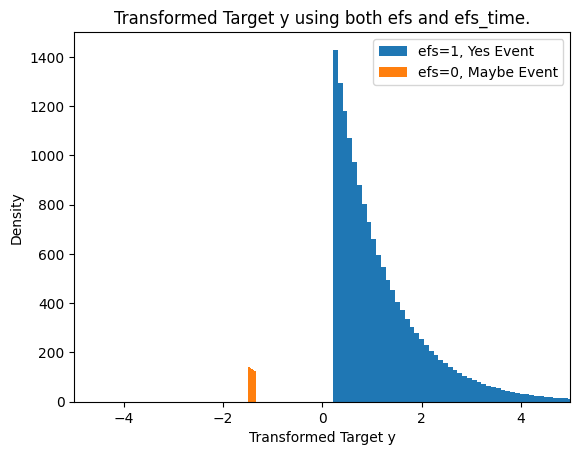

In [ ]:
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs==0,"y"] += 2*len(train)
train.y = train.y / train.y.max()
train.y = np.log( train.y )
train.y -= train.y.mean()
train.y *= -1.0

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlim((-5,5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [ ]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        CATS.append(c)
    elif not "age" in c:
        train[c] = train[c].astype("str")
        test[c] = test[c].astype("str")
        CATS.append(c)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']
In these features, there are 55 CATEGORI

In [ ]:
CAT_SIZE = []
CAT_EMB = []
NUMS = []

combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

print("We LABEL ENCODE the CATEGORICAL FEATURES: ")

for c in FEATURES:
    if c in CATS:
        # LABEL ENCODE
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        #combined[c] = combined[c].astype("category")

        n = combined[c].nunique()
        mn = combined[c].min()
        mx = combined[c].max()
        print(f'{c} has ({n}) unique values')

        CAT_SIZE.append(mx+1)
        CAT_EMB.append( int(np.ceil( np.sqrt(mx+1))) )
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

        m = combined[c].mean()
        s = combined[c].std()
        combined[c] = (combined[c]-m)/s
        combined[c] = combined[c].fillna(0)

        NUMS.append(c)

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: 
dri_score has (12) unique values
psych_disturb has (4) unique values
cyto_score has (8) unique values
diabetes has (4) unique values
hla_match_c_high has (4) unique values
hla_high_res_8 has (8) unique values
tbi_status has (8) unique values
arrhythmia has (4) unique values
hla_low_res_6 has (6) unique values
graft_type has (2) unique values
vent_hist has (3) unique values
renal_issue has (4) unique values
pulm_severe has (4) unique values
prim_disease_hct has (18) unique values
hla_high_res_6 has (7) unique values
cmv_status has (5) unique values
hla_high_res_10 has (9) unique values
hla_match_dqb1_high has (4) unique values
tce_imm_match has (9) unique values
hla_nmdp_6 has (6) unique values
hla_match_c_low has (4) unique values
rituximab has (3) unique values
hla_match_drb1_low has (3) unique values
hla_match_dqb1_low has (4) unique values
prod_type has (2) unique values
cyto_score_detail has (6) unique values
conditioning_intensity has (7)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding
from tensorflow.keras.layers import Concatenate, BatchNormalization
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold

print('TF Version',tf.__version__)

TF Version 2.16.1


Learning rate schedule: 0.01 to 0.01 to 0.0001


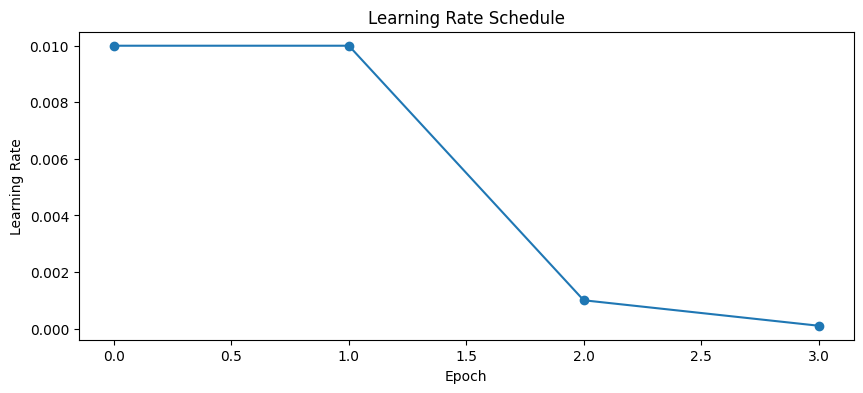

In [ ]:
EPOCHS = 4
LRS = [0.01]*2 + [0.001]*1 + [0.0001]*1

def lrfn(epoch):
    return LRS[epoch]

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
        format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)

In [ ]:
def build_model():

    # CATEGORICAL FEATURES
    x_input_cats = Input(shape=(len(CATS),))
    embs = []
    for j in range(len(CATS)):
        e = tf.keras.layers.Embedding(CAT_SIZE[j],CAT_EMB[j])
        x = e(x_input_cats[:,j])
        x = tf.keras.layers.Flatten()(x)
        embs.append(x)

    # NUMERICAL FEATURES
    x_input_nums = Input(shape=(len(NUMS),))

    # COMBINE
    x = tf.keras.layers.Concatenate(axis=-1)(embs+[x_input_nums])
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='linear')(x)

    model = Model(inputs=[x_input_cats,x_input_nums], outputs=x)

    return model

In [ ]:
%%time

REPEATS = 3
FOLDS = 5
kf = KFold(n_splits=FOLDS, random_state=42, shuffle=True)

oof_nn = np.zeros( len(train) )
pred_nn = np.zeros( len(test) )

#directory = "checkpoints"
#if not os.path.exists(directory):
#    os.makedirs(directory)

for r in range(REPEATS):
    VERBOSE = r==0
    print("#"*25)
    print(f"### REPEAT {r+1} ###")
    print("#"*25)

    for i, (train_index, test_index) in enumerate(kf.split(train)):

        X_train_cats = train.loc[train_index,CATS].values
        X_train_nums = train.loc[train_index,NUMS].values
        y_train = train.loc[train_index,"y"].values
        y_train2 = train.loc[train_index,"efs"].values

        X_valid_cats = train.loc[test_index,CATS].values
        X_valid_nums = train.loc[test_index,NUMS].values
        y_valid = train.loc[test_index,"y"].values
        y_valid2 = train.loc[test_index,"efs"].values

        X_test_cats = test[CATS].values
        X_test_nums = test[NUMS].values

        if VERBOSE:
            print(" ","#"*25)
            print(" ",f"### Fold {i+1} ###")
            print(" ","#"*25)

        # TRAIN MODEL
        K.clear_session()
        model = build_model()
        model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                      loss="mean_squared_error",
                     )
        v = 2 if VERBOSE else 0
        model.fit([X_train_cats,X_train_nums], [y_train],
                  validation_data = ([X_valid_cats,X_valid_nums], [y_valid]),
                  callbacks = [lr_callback],
                  batch_size=512, epochs=EPOCHS, verbose=v)
        #model.save_weights(f'{directory}/NN_f{i}_r{r}.weights.h5')

        # INFER OOF
        oof_nn[test_index] += model.predict([X_valid_cats,X_valid_nums], verbose=v, batch_size=512).flatten()
        # INFER TEST
        pred_nn += model.predict([X_test_cats,X_test_nums], verbose=v, batch_size=512).flatten()

oof_nn /= REPEATS
pred_nn /= (FOLDS*REPEATS)

#########################
### REPEAT 1 ###
#########################
  #########################
  ### Fold 1 ###
  #########################
Epoch 1/4
45/45 - 12s - 270ms/step - loss: 1.9974 - val_loss: 1.8583 - learning_rate: 0.0100
Epoch 2/4
45/45 - 0s - 9ms/step - loss: 1.8355 - val_loss: 1.8651 - learning_rate: 0.0100
Epoch 3/4
45/45 - 0s - 8ms/step - loss: 1.7661 - val_loss: 1.8291 - learning_rate: 0.0010
Epoch 4/4
45/45 - 0s - 8ms/step - loss: 1.7424 - val_loss: 1.8290 - learning_rate: 1.0000e-04
12/12 - 2s - 168ms/step
1/1 - 0s - 37ms/step
  #########################
  ### Fold 2 ###
  #########################
Epoch 1/4
45/45 - 12s - 268ms/step - loss: 1.9938 - val_loss: 1.8391 - learning_rate: 0.0100
Epoch 2/4
45/45 - 0s - 9ms/step - loss: 1.8387 - val_loss: 1.8225 - learning_rate: 0.0100
Epoch 3/4
45/45 - 0s - 8ms/step - loss: 1.7734 - val_loss: 1.8142 - learning_rate: 0.0010
Epoch 4/4
45/45 - 0s - 8ms/step - loss: 1.7533 - val_loss: 1.8106 - learning_rate: 1.0000e-04
12/12 

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_nn
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for NN =",m)


Overall CV for NN = 0.6696558311902632


In [ ]:
# 0.6820

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb_km_rmse) + rankdata(oof_cat_km_rmse) + rankdata(oof_cat_naf) + rankdata(oof_cat_quantile_rmse)\
                        + rankdata(oof_xgb_quantile_rmse) + rankdata(oof_xgb_quantile_mae) + rankdata(oof_xgb_naf_rmse) + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)\
                    + rankdata(oof_cat_aft) + rankdata(oof_xgb_ph_rmse) + rankdata(oof_cat_quantile_rmse_2) + rankdata(oof_cat_km_rmse_2) + rankdata(oof_cat_cox_2)\
                    + rankdata(oof_pred_nn) + rankdata(oof_nn)



m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)


Overall CV for Ensemble = 0.6831262788995551
